In [1]:
import os
import time
import pickle
import requests
import optuna
import csv
from scipy.stats import mannwhitneyu
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()

from rdkit import RDLogger
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, rdMolTransforms
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 300,300

from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, confusion_matrix, matthews_corrcoef
from sklearn.model_selection import StratifiedKFold
import networkx as nx

import torch
import torch.nn.functional as F
import torch_geometric
from torch_geometric.nn import SAGEConv, GCNConv, GATConv, GINConv
from torch_geometric.data import Data, Dataset, InMemoryDataset
from torch_geometric.loader import DataLoader
from torch.utils.data import Subset

##### Molecular Graph Generation

In [2]:
## Customised preprocessing (Mols-To-Graph function)

class Graph_basic(InMemoryDataset):
    def __init__(self, dataframe, root, smiles_col='smiles', label_col='label', test=False, transform=None, pre_transform=None):
        self.test = test
        self.dataframe = dataframe
        self.smiles_col = smiles_col
        self.label_col = label_col
        self._data = None
        self.error_indices = []
        super(Graph_basic, self).__init__(root, transform, pre_transform)
        
    @property
    def raw_file_names(self):
        return 'dataframe'

    @property
    def processed_file_names(self):
        return ['data_test.pt' if self.test else 'data.pt']

    def download(self):
        pass

    def process(self):
        data_list = []
        for index, mol in tqdm(self.dataframe.iterrows(), total=self.dataframe.shape[0]):
            try:
                mol_obj = Chem.MolFromSmiles(mol[self.smiles_col])
                node_feats = self._get_node_features(mol_obj)
                edge_feats = self._get_edge_features(mol_obj)
                edge_index = self._get_adjacency_info(mol_obj)
                label = self._get_labels(mol[self.label_col])

                data = Data(x=node_feats, 
                            edge_index=edge_index,
                            edge_attr=edge_feats,
                            y=label,
                            smiles=mol[self.smiles_col])
                data_list.append(data)
            except Exception as e:
                print(f"Error processing molecule at index {index}: {e}")
                self.error_indices.append(index)

        if self.test:
            torch.save(data_list, os.path.join(self.processed_dir, 'data_test.pt'))
        else:
            torch.save(data_list, os.path.join(self.processed_dir, 'data.pt'))

    def _get_node_features(self, mol):
        """ 
        Return a matrix / 2D array of the shape [Number of Nodes, Node Feature size]
        with atomic number as the only node feature.
        """
        all_node_feats = []

        for atom in mol.GetAtoms():
            node_feats = []    
            node_feats.append(atom.GetAtomicNum())
            all_node_feats.append(node_feats)

        all_node_feats = np.asarray(all_node_feats)
        return torch.tensor(all_node_feats, dtype=torch.float)

    def _get_edge_features(self, mol):
        """ 
        Return a matrix / 2D array of the shape [Number of edges, Edge Feature size]
        with bond type as the only edge feature.
        """
        all_edge_feats = []
        
        for bond in mol.GetBonds():
            edge_feats = []
            edge_feats.append(bond.GetBondTypeAsDouble())
            all_edge_feats += [edge_feats, edge_feats]

        all_edge_feats = np.asarray(all_edge_feats)
        return torch.tensor(all_edge_feats, dtype=torch.float)

    def _get_adjacency_info(self, mol):
        edge_indices = []
        for bond in mol.GetBonds():
            i = bond.GetBeginAtomIdx()
            j = bond.GetEndAtomIdx()
            edge_indices += [[i, j], [j, i]]

        edge_indices = torch.tensor(edge_indices)
        edge_indices = edge_indices.t().to(torch.long).view(2, -1)
        return edge_indices

    def _get_labels(self, label):
        label = np.asarray([[label]])
        return torch.tensor(label, dtype=torch.int64)

    def len(self):
        return self.dataframe.shape[0]

    def get(self, idx):
        if self._data is None:
            if self.test:
                self._data = torch.load(os.path.join(self.processed_dir, 'data_test.pt'))
            else:
                self._data = torch.load(os.path.join(self.processed_dir, 'data.pt'))
        return self._data[idx]

## Customised preprocessing (Mols-To-Graph function)

class Graph_custom(InMemoryDataset):
    def __init__(self, dataframe, root, smiles_col='smiles', label_col='label', test=False, transform=None, pre_transform=None):  # modified
        self.test = test
        self.dataframe = dataframe
        self.smiles_col = smiles_col
        self.label_col = label_col
        self._data = None
        self.error_indices = []  # bad indices: To keep track of error indices
        super(Graph_custom, self).__init__(root, transform, pre_transform)
        
    @property
    def raw_file_names(self):
        """
        (The download func. is not implemented here)  
        """
        return 'dataframe'

    @property
    def processed_file_names(self):
        """ If these files are found in raw_dir, processing is skipped"""
        return ['data_test.pt' if self.test else 'data.pt']

    def download(self):
        pass

    def process(self):
        data_list = []
        for index, mol in tqdm(self.dataframe.iterrows(), total=self.dataframe.shape[0]):
            try:
                mol_obj = Chem.MolFromSmiles(mol[self.smiles_col])
                mol_obj = Chem.AddHs(mol_obj)
                AllChem.EmbedMolecule(mol_obj, randomSeed=42, 
                                      useRandomCoords = True, maxAttempts = 5000 # Use this when Bad Conformer ID error
                                     )
                AllChem.MMFFOptimizeMolecule(mol_obj)
                mol_obj = Chem.RemoveHs(mol_obj)
                AllChem.ComputeGasteigerCharges(mol_obj)
                
                ################################################################
                node_feats = self._get_node_features(mol_obj)
                edge_feats = self._get_edge_features(mol_obj)
                edge_index = self._get_adjacency_info(mol_obj)
                label = self._get_labels(mol[self.label_col])

                data = Data(x=node_feats, 
                            edge_index=edge_index,
                            edge_attr=edge_feats,
                            y=label,
                            smiles=mol[self.smiles_col]
                            ) 
                data_list.append(data)
            except Exception as e:
                print(f"Error processing molecule at index {index}: {e}")
                self.error_indices.append(index)  # bad_indices: Track the index of the molecule that caused an error

        if self.test:
            torch.save(data_list, os.path.join(self.processed_dir, 'data_test.pt'))
        else:
            torch.save(data_list, os.path.join(self.processed_dir, 'data.pt'))

    def _get_node_features(self, mol):
        """ 
        This will return a matrix / 2d array of the shape
        [Number of Nodes, Node Feature size]
        """
        all_node_feats = []

        for atom in mol.GetAtoms():
            node_feats = []
            # Feature 1: Atomic number        
            node_feats.append(atom.GetAtomicNum())
            # Feature 2: Atom degree -> Number of directly-bonded neighbours
            node_feats.append(atom.GetDegree())
            # Feature 3: Formal charge -> charge of the atom
            node_feats.append(atom.GetFormalCharge())
            # Feature 4: Hybridization -> hybridization state i.e. sp3
            node_feats.append(atom.GetHybridization())
            # Feature 5: Aromaticity
            node_feats.append(atom.GetIsAromatic())
            # Feature 6: Total Num Hs
            node_feats.append(atom.GetTotalNumHs())
            # Feature 7: Radical Electrons
            node_feats.append(atom.GetNumRadicalElectrons())
            # Feature 8: In Ring
            node_feats.append(atom.IsInRing())
            # Feature 9: Chirality
            node_feats.append(atom.GetChiralTag())

            # Feature 10: Gasteiger Charges
            node_feats.append(atom.GetDoubleProp("_GasteigerCharge"))
            # Feature 11: Total Valence
            node_feats.append(atom.GetTotalValence())
            # Feature 12: Explicit Valence
            node_feats.append(atom.GetExplicitValence())

            # Append node features to matrix
            all_node_feats.append(node_feats)

        all_node_feats = np.asarray(all_node_feats)
        return torch.tensor(all_node_feats, dtype=torch.float)

    def _get_edge_features(self, mol):
        """ 
        This will return a matrix / 2d array of the shape
        [Number of edges, Edge Feature size]
        """
        conf = mol.GetConformer() # will be used to calculate bond length, force field optimised conformer
        all_edge_feats = []
        
        for bond in mol.GetBonds():
            edge_feats = []
            # Feature 1: Bond type (as double)
            edge_feats.append(bond.GetBondTypeAsDouble())
            # Feature 2: Bond length
            edge_feats.append(np.round(rdMolTransforms.GetBondLength(conf, bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()),3))
            # Feature 3: Rings
            edge_feats.append(bond.IsInRing())
            # Append node features to matrix (twice, per direction)
            all_edge_feats += [edge_feats, edge_feats]

        all_edge_feats = np.asarray(all_edge_feats)
        return torch.tensor(all_edge_feats, dtype=torch.float)

    def _get_adjacency_info(self, mol):
        edge_indices = []
        for bond in mol.GetBonds():
            i = bond.GetBeginAtomIdx()
            j = bond.GetEndAtomIdx()
            edge_indices += [[i, j], [j, i]]

        edge_indices = torch.tensor(edge_indices)
        edge_indices = edge_indices.t().to(torch.long).view(2, -1)
        return edge_indices

    def _get_labels(self, label):
        label = np.asarray([[label]])
        return torch.tensor(label, dtype=torch.int64)

    def len(self):
        return self.dataframe.shape[0]

    def get(self, idx):
        if self._data is None: 
            if self.test:
                self._data = torch.load(os.path.join(self.processed_dir, 'data_test.pt'))
            else:
                self._data = torch.load(os.path.join(self.processed_dir, 'data.pt'))
        return self._data[idx]

##### GNN Architecture

In [3]:
class GNNModel(torch.nn.Module):
    def __init__(self, conv_type, hidden_channels, num_features, batch_norm=False, weight_init=True, dropout_rate=0.0):
        super(GNNModel, self).__init__()
        self.conv1 = conv_type(num_features, hidden_channels*2)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels*2) if batch_norm else None #BatchNorm1D -> GraphNorm
        
        self.conv2 = conv_type(hidden_channels*2, hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels) if batch_norm else None
        
        self.conv3 = conv_type(hidden_channels, hidden_channels//2)
        
        self.dropout = torch.nn.Dropout(dropout_rate) if dropout_rate > 0 else None
        self.lin = torch.nn.Linear(hidden_channels//2, 1)
        if weight_init:
            self.apply(self._init_weights)

    def _init_weights(self, module):
        """Apply Xavier initialisation to the weights of a given module."""
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, torch_geometric.nn.MessagePassing):
            for param in module.parameters():
                if param.dim() > 1:
                    torch.nn.init.xavier_uniform_(param)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        if self.bn1:
            x = self.bn1(x)
        x = F.relu(x)
            
        x = self.conv2(x, edge_index)
        if self.bn2:
            x = self.bn2(x)
        x = F.relu(x)
            
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        if self.dropout:
            x = self.dropout(x)
            
        x = torch_geometric.nn.global_mean_pool(x, batch)
        x = self.lin(x)
        return x

class GINModel(torch.nn.Module):
    def __init__(self, hidden_channels, num_features, batch_norm=False, weight_init=True, dropout_rate=0.0):
        super(GINModel, self).__init__()
        # Define MLP for GINConv
        def mlp(input_dim, output_dim):
            return torch.nn.Sequential(
                torch.nn.Linear(input_dim, output_dim),
                torch.nn.ReLU(),
                torch.nn.Linear(output_dim, output_dim)
            )

        self.conv1 = torch_geometric.nn.GINConv(mlp(num_features, hidden_channels*2))
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels*2) if batch_norm else None
        
        self.conv2 = torch_geometric.nn.GINConv(mlp(hidden_channels*2, hidden_channels))
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels) if batch_norm else None
        
        self.conv3 = torch_geometric.nn.GINConv(mlp(hidden_channels, hidden_channels//2))
        
        self.dropout = torch.nn.Dropout(dropout_rate) if dropout_rate > 0 else None
        self.lin = torch.nn.Linear(hidden_channels//2, 1)

        if weight_init:
            self.apply(self._init_weights)

    def _init_weights(self, module):
        """Apply Xavier initialisation to the weights of a given module."""
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, GINConv):
            for layer in module.nn:
                if isinstance(layer, torch.nn.Linear):
                    torch.nn.init.xavier_uniform_(layer.weight)
                    if layer.bias is not None:
                        torch.nn.init.zeros_(layer.bias)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        if self.bn1:
            x = self.bn1(x)
            x = F.relu(x)
            
        x = self.conv2(x, edge_index)
        if self.bn2:
            x = self.bn2(x)
            x = F.relu(x)
            
        x = self.conv3(x, edge_index)
        if self.dropout:
            x = self.dropout(x)
            
        x = torch_geometric.nn.global_mean_pool(x, batch)
        x = self.lin(x)
        return x

def train(model, loader, optimiser, criterion, device, threshold = 0.5):
    model.train()
    total_loss = 0
    correct = 0
    for data in loader:
        data = data.to(device)
        optimiser.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y.view(-1, 1).float())
        loss.backward()
        optimiser.step()
        total_loss += loss.item()
        pred = (out > threshold).float()
        correct += pred.eq(data.y.view(-1, 1)).sum().item()
    return total_loss / len(loader), correct / len(loader.dataset)

def evaluate(model, loader, criterion, device, threshold = 0.5):
    model.eval()
    total_loss = 0
    correct = 0
    preds, labels = [], []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out, data.y.view(-1, 1).float())
            total_loss += loss.item()
            pred = (out > threshold).float()
            correct += pred.eq(data.y.view(-1, 1)).sum().item()
            preds.append(out)
            labels.append(data.y.view(-1, 1))
    preds = torch.cat(preds, dim=0)
    labels = torch.cat(labels, dim=0)
    return total_loss / len(loader), correct / len(loader.dataset), roc_auc_score(labels.cpu(), preds.cpu()), f1_score(labels.cpu(), (preds > threshold).float().cpu()), matthews_corrcoef(labels.cpu(), (preds > threshold).float().cpu())

class EarlyStopping:
    def __init__(self, patience=10, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0

    def __call__(self, val_score, model):
        score = -val_score
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_score, model)
        elif score < self.best_score - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_score, model)
            self.counter = 0

    def save_checkpoint(self, val_score, model):
        self.best_model = model

##### Model Reinitialisation and NestedCV with Warm Starts

In [4]:
def initialise_and_train_models(models, all_optimised_hyperparameters, pytorch_custom_dataset, seeds, use_early_stopping, num_epochs, patience, save_dir):
    """
    Initialise models with different seeds, train on inner folds with early stopping, evaluate, and save models.

    Args:
        models (dict): Dictionary of model names and classes.
        all_optimised_hyperparameters (dict): Optimised hyperparameters per model and outer fold.
        pytorch_custom_dataset (Dataset): PyTorch custom dataset.
        seeds (list): List of random seeds.
        num_epochs (int): Number of epochs to train.
        save_dir (str): Directory to save models.

    Returns:
        best_model_paths (dict): Dictionary of best model paths per model and outer fold.
        results_init (dict): Dictionary of recorded validation metrics per model, seed, outer fold, and inner fold.
    """
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    best_model_paths = {}  # To store best model paths per model and outer fold
    results_init = {name: {'seed': [], 'outer_fold': [], 'inner_fold': [], 'val_auc': [], 'val_accuracy': [], 'val_f1': [], 'val_mcc': []}
                    for name in models.keys()}

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    num_features = pytorch_custom_dataset[0].num_features
    
    for name, model_class in models.items():
        print(f"Initialising models for {name}...")
        best_model_paths[name] = []

        # Load datasets (note: batch size may differ per outer fold)
        outer_data_loaders = load_datasets(pytorch_custom_dataset, all_optimised_hyperparameters[name])

        for outer_fold in range(len(outer_data_loaders)):
            print(f"  Outer Fold {outer_fold +1}/{len(outer_data_loaders)}")
            optimised_params = all_optimised_hyperparameters[name][outer_fold]
            hidden_channels = int(optimised_params['hidden_channels'])
            dropout_rate = optimised_params['dropout_rate']
            batch_size = int(optimised_params['batch_size'])
            learning_rate = optimised_params['learning_rate']

            for seed in seeds:
                print(f"    Seed {seed}")
                # Set random seed
                torch.manual_seed(seed)
                #np.random.seed(seed)
                if torch.cuda.is_available():
                    torch.cuda.manual_seed(seed)

                if "GCN" in name:
                    conv_type = GCNConv
                elif "GAT" in name:
                    conv_type = GATConv
                elif "GraphSAGE" in name:
                    conv_type = SAGEConv
                else:
                    conv_type = None  # For GINModel, no conv_type is needed

                if model_class == GINModel:
                    model = model_class(
                        hidden_channels=hidden_channels,
                        num_features=num_features,
                        batch_norm=False,
                        weight_init=True,
                        dropout_rate=dropout_rate
                    ).to(device)
                else:
                    model = model_class(
                        conv_type=conv_type,
                        hidden_channels=hidden_channels,
                        num_features=num_features,
                        batch_norm=False,
                        weight_init=True,
                        dropout_rate=dropout_rate
                    ).to(device)

                optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
                criterion = torch.nn.BCEWithLogitsLoss()

                # Train on inner folds
                val_auc_list = []
                for inner_fold, (train_loader, val_loader, _) in enumerate(outer_data_loaders[outer_fold]):
                    print(f"      Inner Fold {inner_fold +1}/{len(outer_data_loaders[outer_fold])}")
                    
                    early_stopping = EarlyStopping(patience=patience, delta=0)

                    for epoch in range(1, num_epochs +1):
                        train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
                        val_loss, val_acc, val_auc, _, _ = evaluate(model, val_loader, criterion, device)
                    
                        if use_early_stopping:
                            early_stopping(val_auc, model)
                            if early_stopping.early_stop:
                                print(f"Early stopping at epoch {epoch}")
                                break
                                
                    best_model = early_stopping.best_model if use_early_stopping else model

                    # Evaluate on validation set
                    _, val_acc, val_auc, val_f1, val_mcc = evaluate(best_model, val_loader, criterion, device)
                    val_auc_list.append(val_auc) # stores 5 inner fold val_auc to print out in the training output

                    # Record results
                    results_init[name]['seed'].append(seed)
                    results_init[name]['outer_fold'].append(outer_fold)
                    results_init[name]['inner_fold'].append(inner_fold)
                    
                    results_init[name]['val_auc'].append(val_auc)
                    results_init[name]['val_accuracy'].append(val_acc)
                    results_init[name]['val_f1'].append(val_f1)
                    results_init[name]['val_mcc'].append(val_mcc)

                # Compute average validation AUC over inner folds
                avg_val_auc = np.mean(val_auc_list)
                #seed_val_auc_list.append((seed, avg_val_auc))
                print(f"  Average val_auc: {avg_val_auc}")

                # Save the model
                model_filepath = os.path.join(save_dir, f"{name}_outer{outer_fold}_seed{seed}.pt")
                torch.save(model.state_dict(), model_filepath)
                print(f"    Saved model with seed {seed} to {model_filepath}")

    
    with open(os.path.join(save_dir, 'results_init.pkl'), 'wb') as f:
        pickle.dump(results_init, f)
        
    return results_init


def load_best_models(models, best_model_paths, all_optimised_hyperparameters, pytorch_custom_dataset):
    """
    Load the best models for each outer fold.

    Args:
        models (dict): Dictionary of model names and classes.
        best_model_paths (dict): Dictionary of best model paths per model and outer fold.
        all_optimised_hyperparameters (dict): Optimised hyperparameters per model and outer fold.

    Returns:
        loaded_models (dict): Dictionary of loaded models per model.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    num_features = pytorch_custom_dataset[0].num_features
    loaded_models = {}
    
    for name, model_class in models.items():
        loaded_models[name] = []
        for outer_fold, model_path in enumerate(best_model_paths[name]):
            # Load the model
            optimised_params = all_optimised_hyperparameters[name][outer_fold]
            hidden_channels = int(optimised_params['hidden_channels'])
            dropout_rate = optimised_params['dropout_rate']

            if "GCN" in name:
                conv_type = GCNConv
            elif "GAT" in name:
                conv_type = GATConv
            elif "GraphSAGE" in name:
                conv_type = SAGEConv
            else:
                conv_type = None  # For GINModel, no conv_type is needed

            if model_class == GINModel:
                model = model_class(
                    hidden_channels=hidden_channels,
                    num_features=num_features,
                    batch_norm=False,
                    weight_init=True,
                    dropout_rate=dropout_rate
                ).to(device)
            else:
                model = model_class(
                    conv_type=conv_type,
                    hidden_channels=hidden_channels,
                    num_features=num_features,
                    batch_norm=False,
                    weight_init=True,
                    dropout_rate=dropout_rate
                ).to(device)

            # Load the model's weights
            model.load_state_dict(torch.load(model_path))
            model = model.to(device)
            loaded_models[name].append(model)
    return loaded_models


def nestedCV_with_warm_starts(loaded_models, all_optimised_hyperparameters, pytorch_custom_dataset, save_dir, num_runs=30, num_epochs=100, 
                                                          use_early_stopping=True, patience=10, alpha=0.05):
    results = {name: {'epoch': [], 'run_epoch': [], 'train_loss': [], 'val_loss': [],  # Recording loss and early stop epochs
                      'run': [], 'outer_fold': [], 'inner_fold': [],  # Evaluation metrics after early stop or full training
                      'val_accuracy': [], 'val_f1': [], 'val_auc': [], 'val_mcc': []}
               for name in loaded_models.keys()}
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    threshold = 0.5  # For binary classification

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # Sidak correction for multiple comparisons (m = 2)
    m = 2
    alpha_corrected = 1 - (1 - alpha) ** (1 / m)
    
    last_significant_run = {name: None for name in loaded_models.keys()}
    
    for name, models_list in loaded_models.items():
        print(f"\nRunning {name} model...")
        
        # load outer_data_loaders for each model according to the optimised batch sizes
        outer_data_loaders = load_datasets(pytorch_custom_dataset, all_optimised_hyperparameters[name])

        for run in range(1, num_runs + 1):  # Starting run number from 1
            print(f"Run {run}/{num_runs}")
            
            for outer_fold, inner_data_loaders in enumerate(outer_data_loaders):
                print(f"Outer Fold {outer_fold + 1}/{len(outer_data_loaders)}")
                start_time = time.time()
                
                # Set random seed for reproducibility
                seed = run
                torch.manual_seed(seed)
                #np.random.seed(seed)
                if torch.cuda.is_available():
                    torch.cuda.manual_seed(seed)
                
                for inner_fold, (train_loader, val_loader, _) in enumerate(inner_data_loaders):
                    print(f"  Inner Fold {inner_fold + 1}/{len(inner_data_loaders)}")
                    
                    model = models_list[outer_fold] 
                    model = model.to(device) 

                    optimised_params = all_optimised_hyperparameters[name][outer_fold]
                    learning_rate = optimised_params['learning_rate']

                    optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
                    criterion = torch.nn.BCEWithLogitsLoss()
                    
                    best_val_auc = 0
                    early_stopping = EarlyStopping(patience=patience, delta= 0)
                    
                    for epoch in range(1, num_epochs + 1):
                        train_loss, train_acc = train(model, train_loader, optimiser, criterion, device, threshold=threshold)
                        val_loss, val_acc, val_auc, _, _ = evaluate(model, val_loader, criterion, device, threshold=threshold)
                        
                        results[name]['epoch'].append(epoch)
                        results[name]['run_epoch'].append(seed)
                        results[name]['train_loss'].append(train_loss)
                        results[name]['val_loss'].append(val_loss)
                        
                        if use_early_stopping:
                            early_stopping(val_auc, model)
                            if early_stopping.early_stop:
                                print(f"Early stopping at epoch {epoch}")
                                break
                    
                    best_model = early_stopping.best_model if use_early_stopping else model

                    results[name]['run'].append(seed)
                    results[name]['outer_fold'].append(outer_fold)
                    results[name]['inner_fold'].append(inner_fold)

                    _, val_acc, val_auc, val_f1, val_mcc = evaluate(best_model, val_loader, criterion, device, threshold=threshold)

                    results[name]['val_auc'].append(val_auc)
                    results[name]['val_accuracy'].append(val_acc)
                    results[name]['val_f1'].append(val_f1)
                    results[name]['val_mcc'].append(val_mcc)

                    print(f"Run {run}, Outer Fold {outer_fold}, Inner Fold {inner_fold}, Val AUC: {val_auc:.4f}")
                    
                    # Save the trained model after every run
                    model_filepath = os.path.join(save_dir, f"{name}_outer{outer_fold}_inner{inner_fold}_run{run}.pt")
                    torch.save(best_model.state_dict(), model_filepath)
                    print(f"Saved model for run {run} to {model_filepath}")
                    
                    end_time = time.time()
                    total_time = (end_time - start_time) / 60
                    print(f"Inner Fold total time taken: {total_time:.2f} minutes")
            
            # Perform significance testing and stop warm starts
            if run >= 3:
                auc_run_current = results[name]['val_auc'][-20:]
                auc_run_prev_1 = results[name]['val_auc'][-40:-20]
                auc_run_prev_2 = results[name]['val_auc'][-60:-40]
                
                u_stat_1, p_value_1 = mannwhitneyu(auc_run_current, auc_run_prev_1, method="exact")
                u_stat_2, p_value_2 = mannwhitneyu(auc_run_current, auc_run_prev_2, method="exact")
                
                if p_value_1 > alpha_corrected and p_value_2 > alpha_corrected:
                    print(f"Run {run} stopped making significant improvements for model {name}. Stopping warm starts.")
                    last_significant_run[name] = run - 2
                    break
                    
    with open(os.path.join(save_dir, 'results.pkl'), 'wb') as f:
        pickle.dump(results, f)

    with open(os.path.join(save_dir, 'last_significant_run.pkl'), 'wb') as f:
        pickle.dump(last_significant_run, f)
        
    return results, last_significant_run

##### Functions to select the optimal hyperparameters and initialisations

In [2]:
def plot_hyperparameter_performance_ranking(hyperparam_df, ylim = (0.3, 0.75), save_dir = None, prefix = ''):
    """

    Ranking based on Median & Min validation auc
    
    Generates plots for hyperparameter performance and selects the best hyperparameters
    based on ranking of median_val_auc and min_val_auc.

    Parameters:
    - hyperparam_df: DataFrame containing the filtered results.

    Returns:
    - best_params_dict: Dictionary with best parameters for each model and outer fold.
    """

    full_names = {
        'GCN_Optimised': 'Graph Convolutional Network',
        'GAT_Optimised': 'Graph Attention Network',
        'GraphSAGE_Optimised': 'GraphSAGE',
        'GIN_Optimised': 'Graph Isomorphism Network'
    }    

    hyperparam_df['hyperparam_id'] = hyperparam_df.groupby(
        ['batch_size', 'hidden_channels', 'learning_rate', 'dropout_rate']
    ).ngroup()

    plot_data = hyperparam_df.groupby(
        ['model_name', 'outer_fold', 'hyperparam_id', 'batch_size', 'hidden_channels', 'learning_rate', 'dropout_rate']
    ).agg(
        mean_val_auc=('val_auc', 'mean'),
        std_val_auc=('val_auc', 'std'),
        median_val_auc=('val_auc', 'median'),
        max_val_auc=('val_auc', 'max'),
        min_val_auc=('val_auc', 'min')
    ).reset_index()

    models = ['GCN_Optimised', 'GAT_Optimised', 'GraphSAGE_Optimised', 'GIN_Optimised']
    outer_folds = sorted(plot_data['outer_fold'].unique())

    n_rows = len(models)
    n_cols = len(outer_folds)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20), sharey=True)
    if n_rows == 1:
        axes = [axes]

    best_params_dict = {}
    optimal_val_aucs = []

    for i, model in enumerate(models):
        best_params_dict[model] = {}
        for j, outer_fold in enumerate(outer_folds):
            ax = axes[i][j] if n_rows > 1 else axes[j]

            data = plot_data[(plot_data['model_name'] == model) & (plot_data['outer_fold'] == outer_fold)].copy()
            data['median_rank'] = data['median_val_auc'].rank(ascending=False, method='min')
            data['min_rank'] = data['min_val_auc'].rank(ascending=False, method='min')
            data['combined_rank'] = data['median_rank'] + data['min_rank']
            
            data = data.sort_values('combined_rank').reset_index(drop=True)

            yerr = [data['median_val_auc'] - data['min_val_auc'], data['max_val_auc'] - data['median_val_auc']]
            ax.errorbar(
                x=data.index,
                y=data['median_val_auc'],
                yerr=yerr,
                fmt='o',
                ecolor='gray', # ecolor = 'gray'
                alpha = 0.8,
                elinewidth=1,
                capsize=2,
                markersize = 2,
                label = 'Hyperparam Combinations'
            )

            best_idx = data.index[0]
            ax.plot(best_idx, data.loc[best_idx, 'median_val_auc'], 'ro', markersize=8, label = 'Optimal Hyperparam')

            median_val_auc = data.loc[best_idx, 'median_val_auc']
            min_val_auc = data.loc[best_idx, 'min_val_auc']
            max_val_auc = data.loc[best_idx, 'max_val_auc']
            ax.annotate(
                f"Optimal Hyperparam\nMedian: {median_val_auc:.3f}\nRange: [{min_val_auc:.3f}, {max_val_auc:.3f}]",
                xy=(0.05, 0.98),
                xycoords='axes fraction',
                ha='left',
                va='top',
                fontsize=10,
                color='red'
            )

            ax.set_ylim(ylim) 
            ax.set_title(f'{full_names[model]}, outer fold {outer_fold}')
            ax.set_xlabel('Hyperparameter Combination')
            if j == 0:
                ax.set_ylabel('Validation AUC (Median, Min/Max Range)')
            else:
                ax.set_ylabel('')
            ax.set_xticks([])

            best_params = data.loc[best_idx, ['learning_rate', 'hidden_channels', 'batch_size', 'dropout_rate']].to_dict()
            best_params_dict[model][outer_fold] = best_params

            optimal_params = best_params.copy()
            optimal_params['model_name'] = model
            optimal_params['outer_fold'] = outer_fold

            mask = (
                (hyperparam_df['model_name'] == model) &
                (hyperparam_df['outer_fold'] == outer_fold) &
                (hyperparam_df['learning_rate'] == optimal_params['learning_rate']) &
                (hyperparam_df['hidden_channels'] == optimal_params['hidden_channels']) &
                (hyperparam_df['batch_size'] == optimal_params['batch_size']) &
                (hyperparam_df['dropout_rate'] == optimal_params['dropout_rate'])
            )
            val_aucs = hyperparam_df[mask]['val_auc'].tolist()
            optimal_val_aucs.extend(val_aucs)

        if optimal_val_aucs:
            #print(optimal_val_aucs)
            mean_auc = np.mean(optimal_val_aucs)
            std_auc = np.std(optimal_val_aucs)
            print(f"For model {model.replace('_Optimised','')}, mean val_auc of optimal hyperparameters across 20 inner folds: {mean_auc:.3f} ± {std_auc:.3f}")
        else:
            print(f"No validation AUC data found for model {full_names[model]}")

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', fontsize='large', ncol=2, frameon=True, framealpha=0.7, bbox_to_anchor=(0.5, 1.0))
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    
    if save_dir:
        filename = f"{prefix}_hyperparameter.jpg"
        plt.savefig(os.path.join(save_dir, filename), dpi = 300)
    else:
        plt.show()

    return best_params_dict


def select_best_models(results_init, save_dir):
    """
    Select the best outer fold model based on median & min rank
    """
    results_list = []
    for model_name, results in results_init.items():
        for i in range(len(results['seed'])):
            results_list.append({
                'model_name': model_name,
                'seed': results['seed'][i],
                'outer_fold': results['outer_fold'][i],
                'inner_fold': results['inner_fold'][i],
                'val_auc': results['val_auc'][i],
                'val_accuracy': results['val_accuracy'][i],
                'val_f1': results['val_f1'][i],
                'val_mcc': results['val_mcc'][i]
            })

    results_df = pd.DataFrame(results_list)

    agg_results = results_df.groupby(['model_name', 'outer_fold', 'seed']).agg(
        median_val_auc=('val_auc', 'median'),
        min_val_auc=('val_auc', 'min')
    ).reset_index()

    agg_results['median_rank'] = agg_results.groupby(['model_name', 'outer_fold'])['median_val_auc'].rank(ascending=False, method='min')
    agg_results['min_rank'] = agg_results.groupby(['model_name', 'outer_fold'])['min_val_auc'].rank(ascending=False, method='min')
    agg_results['combined_rank'] = agg_results['median_rank'] + agg_results['min_rank']

    best_models_df = agg_results.loc[agg_results.groupby(['model_name', 'outer_fold'])['combined_rank'].idxmin()].reset_index(drop=True)

    best_model_paths = {}
    for model_name in results_init.keys():
        model_paths = []
        for _, row in best_models_df[best_models_df['model_name'] == model_name].iterrows():
            model_paths.append(os.path.join(save_dir, f"{model_name}_outer{row['outer_fold']}_seed{row['seed']}.pt"))
        best_model_paths[model_name] = model_paths

    return best_model_paths

def plot_seed_performance(results_init, best_model_paths, ylim = (0.5, 0.9), save_dir=None, prefix = ''):
    """
    Generates 4x4 plots (rows: GNN models, cols: outer folds)
    Each plot displays median with min and max error bars for all 10 seeds
    and highlights the best seed (which agrees with the best_model_paths).
    
    Additionally, for each GNN model, retrieves the best models' val_auc values across all outer folds (5 inner x 4 outer = 20 val_auc)
    and prints the mean val_auc with standard deviation.
    
    Args:
        results_init (dict): Dictionary of recorded validation metrics per model, seed, outer_fold, inner_fold.
        best_model_paths (dict): Dictionary of best model paths per model and outer fold.
        save_dir (str, optional): Directory to save the plot. If None, the plot is displayed.
    """
    
    full_names = {
        'GCN_Optimised': 'Graph Convolutional Network',
        'GAT_Optimised': 'Graph Attention Network',
        'GraphSAGE_Optimised': 'GraphSAGE',
        'GIN_Optimised': 'Graph Isomorphism Network'
    }    
    
    models = list(results_init.keys())
    num_models = len(models)
    outer_folds = sorted(set(results_init[models[0]]['outer_fold']))
    num_outer_folds = len(outer_folds)

    fig, axes = plt.subplots(nrows=num_models, ncols=num_outer_folds, figsize=(20, 20), sharey=True)

    for i, model_name in enumerate(models):
        model_results = results_init[model_name]
        best_seeds = []
        for path in best_model_paths[model_name]:
            filename = os.path.basename(path)
            parts = filename.split('_')
            seed_part = parts[-1] 
            seed_str = seed_part.replace('seed', '').replace('.pt', '')
            best_seed = int(seed_str)
            best_seeds.append(best_seed)

        for j, outer_fold in enumerate(outer_folds):
            ax = axes[i, j] if num_models > 1 else axes[j]
            seeds = sorted(set(model_results['seed']))
            seed_medians = []
            seed_mins = []
            seed_maxs = []

            for seed in seeds:
                val_aucs = [auc for s, of, auc in zip(model_results['seed'], model_results['outer_fold'], model_results['val_auc'])
                            if s == seed and of == outer_fold]
                if len(val_aucs) == 0:
                    continue 
                median_auc = np.median(val_aucs)
                min_auc = np.min(val_aucs)
                max_auc = np.max(val_aucs)
                seed_medians.append((seed, median_auc))
                seed_mins.append((seed, min_auc))
                seed_maxs.append((seed, max_auc))

            seeds_plot = [s for s, _ in seed_medians]
            medians_plot = [m for _, m in seed_medians]
            mins_plot = [m for _, m in seed_mins]
            maxs_plot = [m for _, m in seed_maxs]

            if len(seeds_plot) == 0:
                ax.set_title(f"{model_name}, Outer Fold {outer_fold}")
                ax.set_xlabel("Seed")
                if j == 0:
                    ax.set_ylabel("Validation AUC (Median, Min/Max Range)")
                ax.text(0.5, 0.5, 'No Data', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
                continue

            lower_errors = [median - min_ for median, min_ in zip(medians_plot, mins_plot)]
            upper_errors = [max_ - median for median, max_ in zip(medians_plot, maxs_plot)]
            asymmetric_error = [lower_errors, upper_errors]

            ax.errorbar(seeds_plot, medians_plot, yerr=asymmetric_error, fmt='o', ecolor='gray', # ecolor = 'gray'
                        alpha = 0.8, capsize=5, markersize = 3, label='Seeds')

            try:
                best_seed = best_seeds[j]
            except IndexError:
                print(f"No best seed found for model {model_name}, outer fold {outer_fold}")
                best_seed = None

            if best_seed in seeds_plot:
                idx = seeds_plot.index(best_seed)
                ax.scatter(seeds_plot[idx], medians_plot[idx], color='red', s=100, label='Best Seed')

                median = medians_plot[idx]
                min_ = mins_plot[idx]
                max_ = maxs_plot[idx]
                ax.annotate(f"Best Seed\nMedian: {median:.3f}\nRange: [{min_:.3f}, {max_:.3f}]",
                            xy=(0.05, 0.95),
                            xycoords='axes fraction',
                            ha='left', va='top', fontsize=10,
                            color='red')
            else:
                print(f"Best seed {best_seed} not found in seeds_plot for model {model_name}, outer fold {outer_fold}")

            ax.set_ylim(ylim)
            ax.set_title(f"{full_names[model_name]}, Outer Fold {outer_fold}")
            ax.set_xlabel("Seed")
            if j == 0:
                ax.set_ylabel("Validation AUC (Median, Min/Max Range)")
            ax.set_xticks(seeds_plot)

        best_val_aucs = []
        for seed, outer_fold in zip(best_seeds, outer_folds):
            val_aucs = [auc for s, of, auc in zip(model_results['seed'], model_results['outer_fold'], model_results['val_auc'])
                        if s == seed and of == outer_fold]
            if len(val_aucs) == 0:
                continue  
            #print(val_aucs)
            best_val_aucs.append(val_aucs)

        if best_val_aucs:
            mean_auc = np.mean(best_val_aucs)
            std_auc = np.std(best_val_aucs)
            print(f"For model {model_name.replace('_Optimised','')}, mean val_auc of the best seed across 20 inner folds: {mean_auc:.3f} ± {std_auc:.3f}")
        else:
            print(f"No val_auc data for model {model_name}")
            
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', fontsize='large', ncol=2, frameon=True, framealpha=0.7, bbox_to_anchor=(0.5, 1.0))
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    
    if save_dir:
        filename = f"{prefix}_seed.jpg"
        plt.savefig(os.path.join(save_dir, filename), dpi = 300)
    else:
        plt.show()


##### Functions for Trained models to compute Val_auc and Test_auc

In [3]:
def plot_median_val_auc_with_error_bars(results, last_significant_run, num_folds=20, ylim = (0.5, 1.01), save_dir=None, prefix = ''):
    full_names = {
        'GCN_Optimised': 'Graph Convolutional Network',
        'GAT_Optimised': 'Graph Attention Network',
        'GraphSAGE_Optimised': 'GraphSAGE',
        'GIN_Optimised': 'Graph Isomorphism Network'
    }    
    num_models = len(results)
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))
    axs = axs.flatten()
    
    for i, (model_name, metrics) in enumerate(results.items()):
        val_auc = metrics['val_auc']
        total_val_auc = len(val_auc)
        
        num_runs = total_val_auc // num_folds
        if total_val_auc % num_folds != 0:
            print(f"Warning: Number of val_auc values ({total_val_auc}) is not evenly divisible by {num_folds}.")
            continue
        
        val_auc_by_runs = np.reshape(val_auc, (num_runs, num_folds))

        median_val_auc_per_run = np.median(val_auc_by_runs, axis=1)
        min_val_auc_per_run = np.min(val_auc_by_runs, axis=1)
        max_val_auc_per_run = np.max(val_auc_by_runs, axis=1)

        lower_error = median_val_auc_per_run - min_val_auc_per_run
        upper_error = max_val_auc_per_run - median_val_auc_per_run
        asymmetric_error = [lower_error, upper_error]

        median_line = axs[i].errorbar(range(1, num_runs + 1), median_val_auc_per_run, yerr=asymmetric_error, fmt='o-', label="Median, Min/Max", capsize=5, 
                                      alpha = 0.8, markersize = 5, color = 'gray') #ecolor = 'gray'

        last_run_idx = last_significant_run[model_name] - 1
        median_val = median_val_auc_per_run[last_run_idx]

        last_significant_marker = axs[i].plot(last_significant_run[model_name], median_val, marker='o', color='red', markersize=12, label="Last Significant Run")

        axs[i].annotate(f"Last Significant Run: {last_significant_run[model_name]}\nMedian: {median_val:.3f}\nRange: [{min_val_auc_per_run[last_run_idx]:.3f}, {max_val_auc_per_run[last_run_idx]:.3f}]",
                        (last_significant_run[model_name], median_val), 
                        #xytext=(5, 5), textcoords='offset points', color='red')
                        xytext=(0.50, 0.05), textcoords='axes fraction', ha='center', va = 'bottom', color='red', fontsize=10)

        axs[i].set_title(full_names[model_name])
        axs[i].set_xlabel("Run Number")
        axs[i].set_ylabel("Validation AUC (Median, Min/Max Range)")
        axs[i].set_ylim(ylim) 
        axs[i].xaxis.set_major_locator(plt.MaxNLocator(integer=True))

        val_auc_last_run = val_auc_by_runs[last_run_idx]
        mean_auc = np.mean(val_auc_last_run)
        std_auc = np.std(val_auc_last_run)
        print(f"For model {model_name.replace('_Optimised','')}, mean val_auc of the last significant run across 20 inner folds: {mean_auc:.3f} ± {std_auc:.3f}")
        
    for j in range(i + 1, 4):
        fig.delaxes(axs[j])

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    handles = [last_significant_marker[0], median_line]
    labels = ["Last Significant Run", "Sequential Runs"]
    fig.legend(handles, labels, loc='upper center', fontsize='large', ncol=2, frameon=True, framealpha=0.7, bbox_to_anchor=(0.5, 1.0))
    
    if save_dir:
        filename = f"{prefix}_significant_runs_median.jpg"
        plt.savefig(os.path.join(save_dir, filename), dpi = 300)
    else:
        plt.show()

def test_final_models_on_outer_cv(loaded_models, all_optimised_hyperparameters, pytorch_custom_dataset, last_significant_run, save_dir):
    results = {name: {'outer_fold': [], 'inner_fold': [], 'test_accuracy': [], 'test_f1': [], 'test_auc': [], 'test_mcc': []}
               for name in loaded_models.keys()}
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    threshold = 0.5 

    for name, models_list in loaded_models.items():
        print(f"\nTesting final {name} model on outer CV test sets...")
        last_run = last_significant_run[name]  

        outer_data_loaders = load_datasets(pytorch_custom_dataset, all_optimised_hyperparameters[name])
        for outer_fold, inner_data_loaders in enumerate(outer_data_loaders):
            print(f"  Outer Fold {outer_fold + 1}/{len(outer_data_loaders)}")
            
            model = models_list[outer_fold] 
            model = model.to(device) 
            
            for inner_fold, (_, _, test_loader) in enumerate(inner_data_loaders):
                print(f"    Inner Fold {inner_fold + 1}/{len(inner_data_loaders)}")

                model_filepath = f"{save_dir}/{name}_outer{outer_fold}_inner{inner_fold}_run{last_run}.pt"
                print(f"Loading model from {model_filepath}")
                model.load_state_dict(torch.load(model_filepath))
                model = model.to(device)
                criterion = torch.nn.BCEWithLogitsLoss()

                test_loss, test_acc, test_auc, test_f1, test_mcc = evaluate(model, test_loader, criterion, device, threshold=threshold)

                results[name]['outer_fold'].append(outer_fold)
                results[name]['inner_fold'].append(inner_fold)
                results[name]['test_accuracy'].append(test_acc)
                results[name]['test_f1'].append(test_f1)
                results[name]['test_auc'].append(test_auc)
                results[name]['test_mcc'].append(test_mcc)
                
                print(f"Outer Fold {outer_fold + 1}, Inner Fold {inner_fold + 1}: Test AUC: {test_auc:.4f}, Test Accuracy: {test_acc:.4f}, Test F1: {test_f1:.4f}, Test MCC: {test_mcc:.4f}")

    print("\nSummary of Metrics (Mean ± Std) for Each Model:")
    header_format = "{:<26} {:<17} {:<25} {:<23} {:<20}"
    row_format = "{:<26} {:.4f} ± {:.4f} \t {:.4f} ± {:.4f} \t {:.4f} ± {:.4f} \t {:.4f} ± {:.4f}"

    print(header_format.format("Model", "AUC", "Accuracy", "F1", "MCC"))

    for name in loaded_models.keys():
        auc_mean = np.mean(results[name]['test_auc'])
        auc_std = np.std(results[name]['test_auc'])
        
        acc_mean = np.mean(results[name]['test_accuracy'])
        acc_std = np.std(results[name]['test_accuracy'])
        
        f1_mean = np.mean(results[name]['test_f1'])
        f1_std = np.std(results[name]['test_f1'])
        
        mcc_mean = np.mean(results[name]['test_mcc'])
        mcc_std = np.std(results[name]['test_mcc'])
        
        print(row_format.format(name, auc_mean, auc_std, acc_mean, acc_std, f1_mean, f1_std, mcc_mean, mcc_std))
    
    return results

##### Preloading the dataset

In [4]:
# Loading train / val / test data
def load_datasets(pytorch_custom_dataset, all_optimised_hyperparameters, seed=42):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

    num_samples = len(pytorch_custom_dataset)
    indices = np.arange(num_samples)
    skf_outer = StratifiedKFold(n_splits=4, shuffle=True, random_state=seed)
    targets = [data.y.item() for data in pytorch_custom_dataset]

    outer_data_loaders = []

    for outer_fold, (train_indices, test_indices) in enumerate(skf_outer.split(indices, targets)):
        train_dataset = Subset(pytorch_custom_dataset, train_indices)
        test_dataset = Subset(pytorch_custom_dataset, test_indices)

        skf_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
        
        inner_data_loaders = []
        for inner_train_indices, val_indices in skf_inner.split(train_indices, np.array(targets)[train_indices]):
            inner_train_dataset = Subset(train_dataset, inner_train_indices)
            val_dataset = Subset(train_dataset, val_indices)

            batch_size = int(all_optimised_hyperparameters[outer_fold]['batch_size'])

            inner_train_loader = DataLoader(inner_train_dataset, batch_size=batch_size, shuffle=False)  
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  
            test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  

            inner_data_loaders.append((inner_train_loader, val_loader, test_loader))  # [train, val, test] x 5 inner fold
                                                                                      # (test is the same, repeated 5 times)
        outer_data_loaders.append(inner_data_loaders)  # [train, val, test] x 4 outer fold
        
    return outer_data_loaders

### Drug-induced Liver injury (DILI)

In [8]:
# Generated from DILIGeNN Data Preprocessing.ipynb
df_dili_filtered_cleaned = pd.read_csv('chem_data/DILI/DILIst_standardised_cleaned.csv', index_col = 0)

dlst_min = Graph_basic(dataframe = df_dili_filtered_cleaned,
                              smiles_col = 'smiles',
                             label_col = 'label',
                             root = 'custom_data/minimal_feature/dlst_min'
                            )
dlst_cus_2_std = Graph_custom(dataframe = df_dili_filtered_cleaned,
                              smiles_col = 'smiles_std',
                             label_col = 'label',
                             root = 'custom_data/DILI/cus2_std/'
                            )

##### Basic molecular graph

For model GCN, mean val_auc of optimal hyperparameters across 20 inner folds: 0.536 ± 0.056
For model GAT, mean val_auc of optimal hyperparameters across 20 inner folds: 0.535 ± 0.056
For model GraphSAGE, mean val_auc of optimal hyperparameters across 20 inner folds: 0.543 ± 0.053
For model GIN, mean val_auc of optimal hyperparameters across 20 inner folds: 0.548 ± 0.050


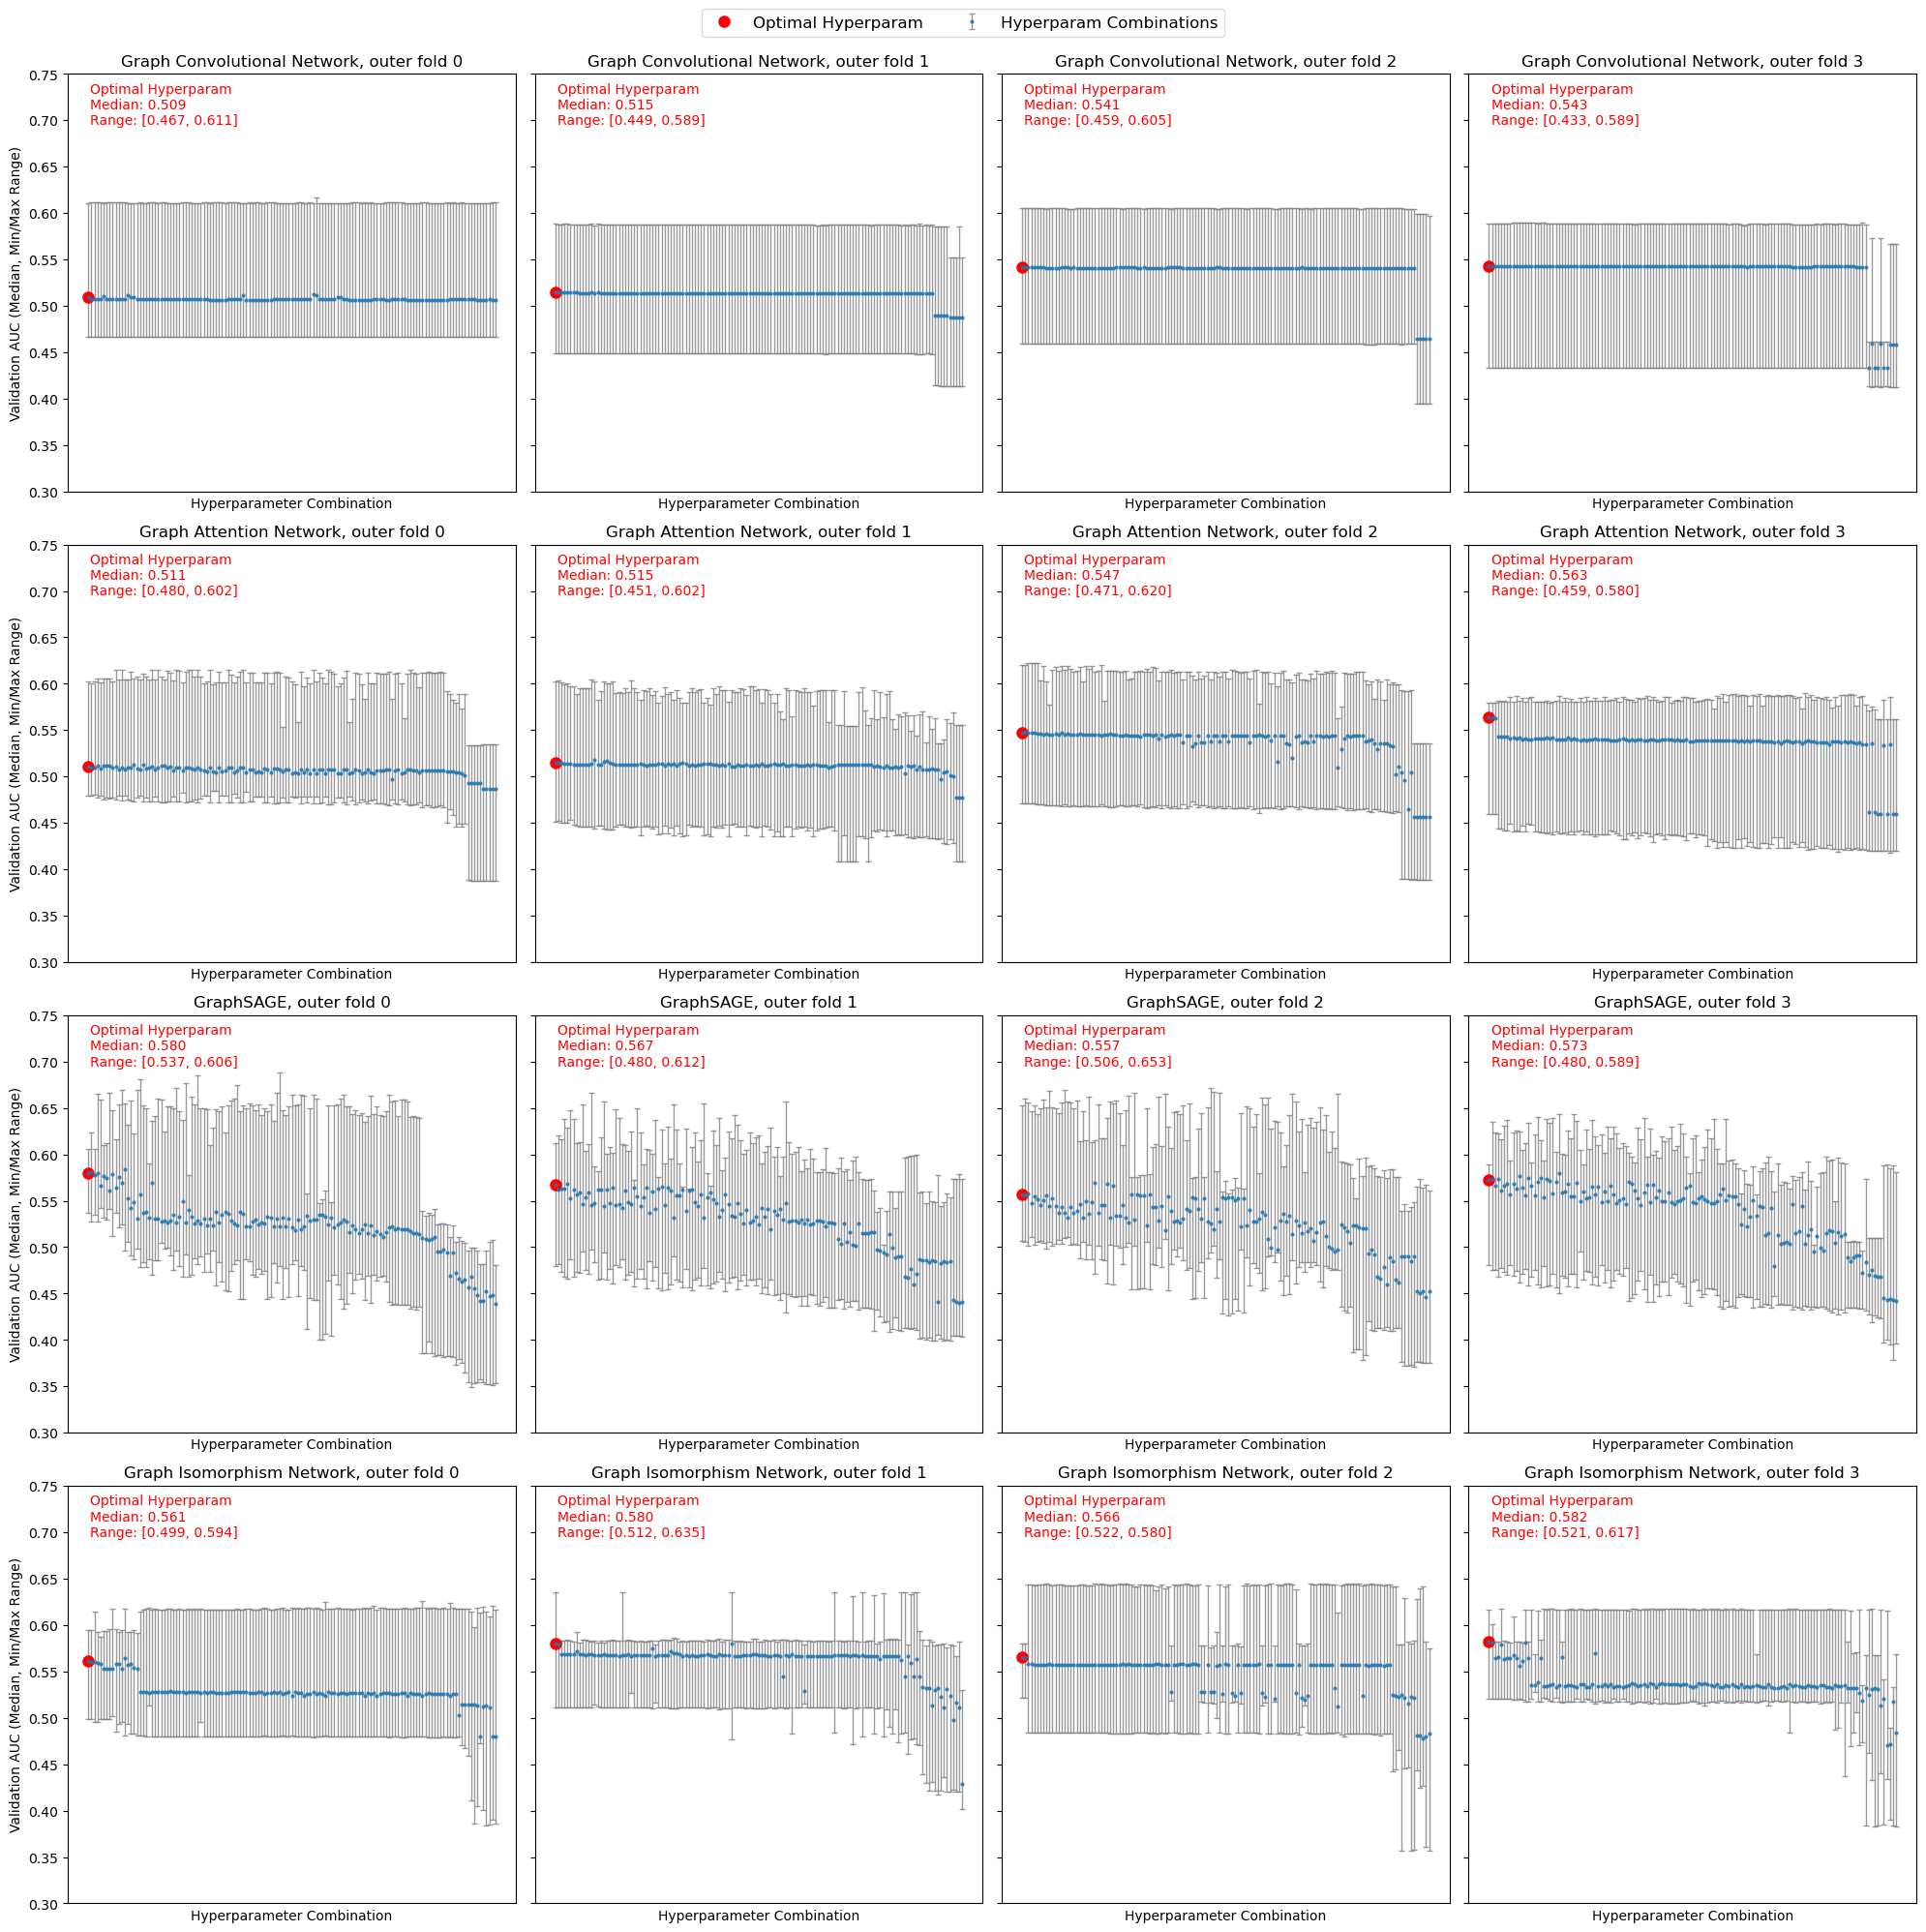

In [9]:
results_dir = 'results/grid_search/dlst_min'
hyperparam_df = pd.read_csv(os.path.join(results_dir, 'grid_search_results.csv'))
grid_search_hyperparameters_ranking = plot_hyperparameter_performance_ranking(hyperparam_df, save_dir = results_dir, prefix = 'DILI_min')

For model GCN, mean val_auc of the best seed across 20 inner folds: 0.548 ± 0.046
For model GAT, mean val_auc of the best seed across 20 inner folds: 0.561 ± 0.041
For model GraphSAGE, mean val_auc of the best seed across 20 inner folds: 0.604 ± 0.042
For model GIN, mean val_auc of the best seed across 20 inner folds: 0.553 ± 0.031


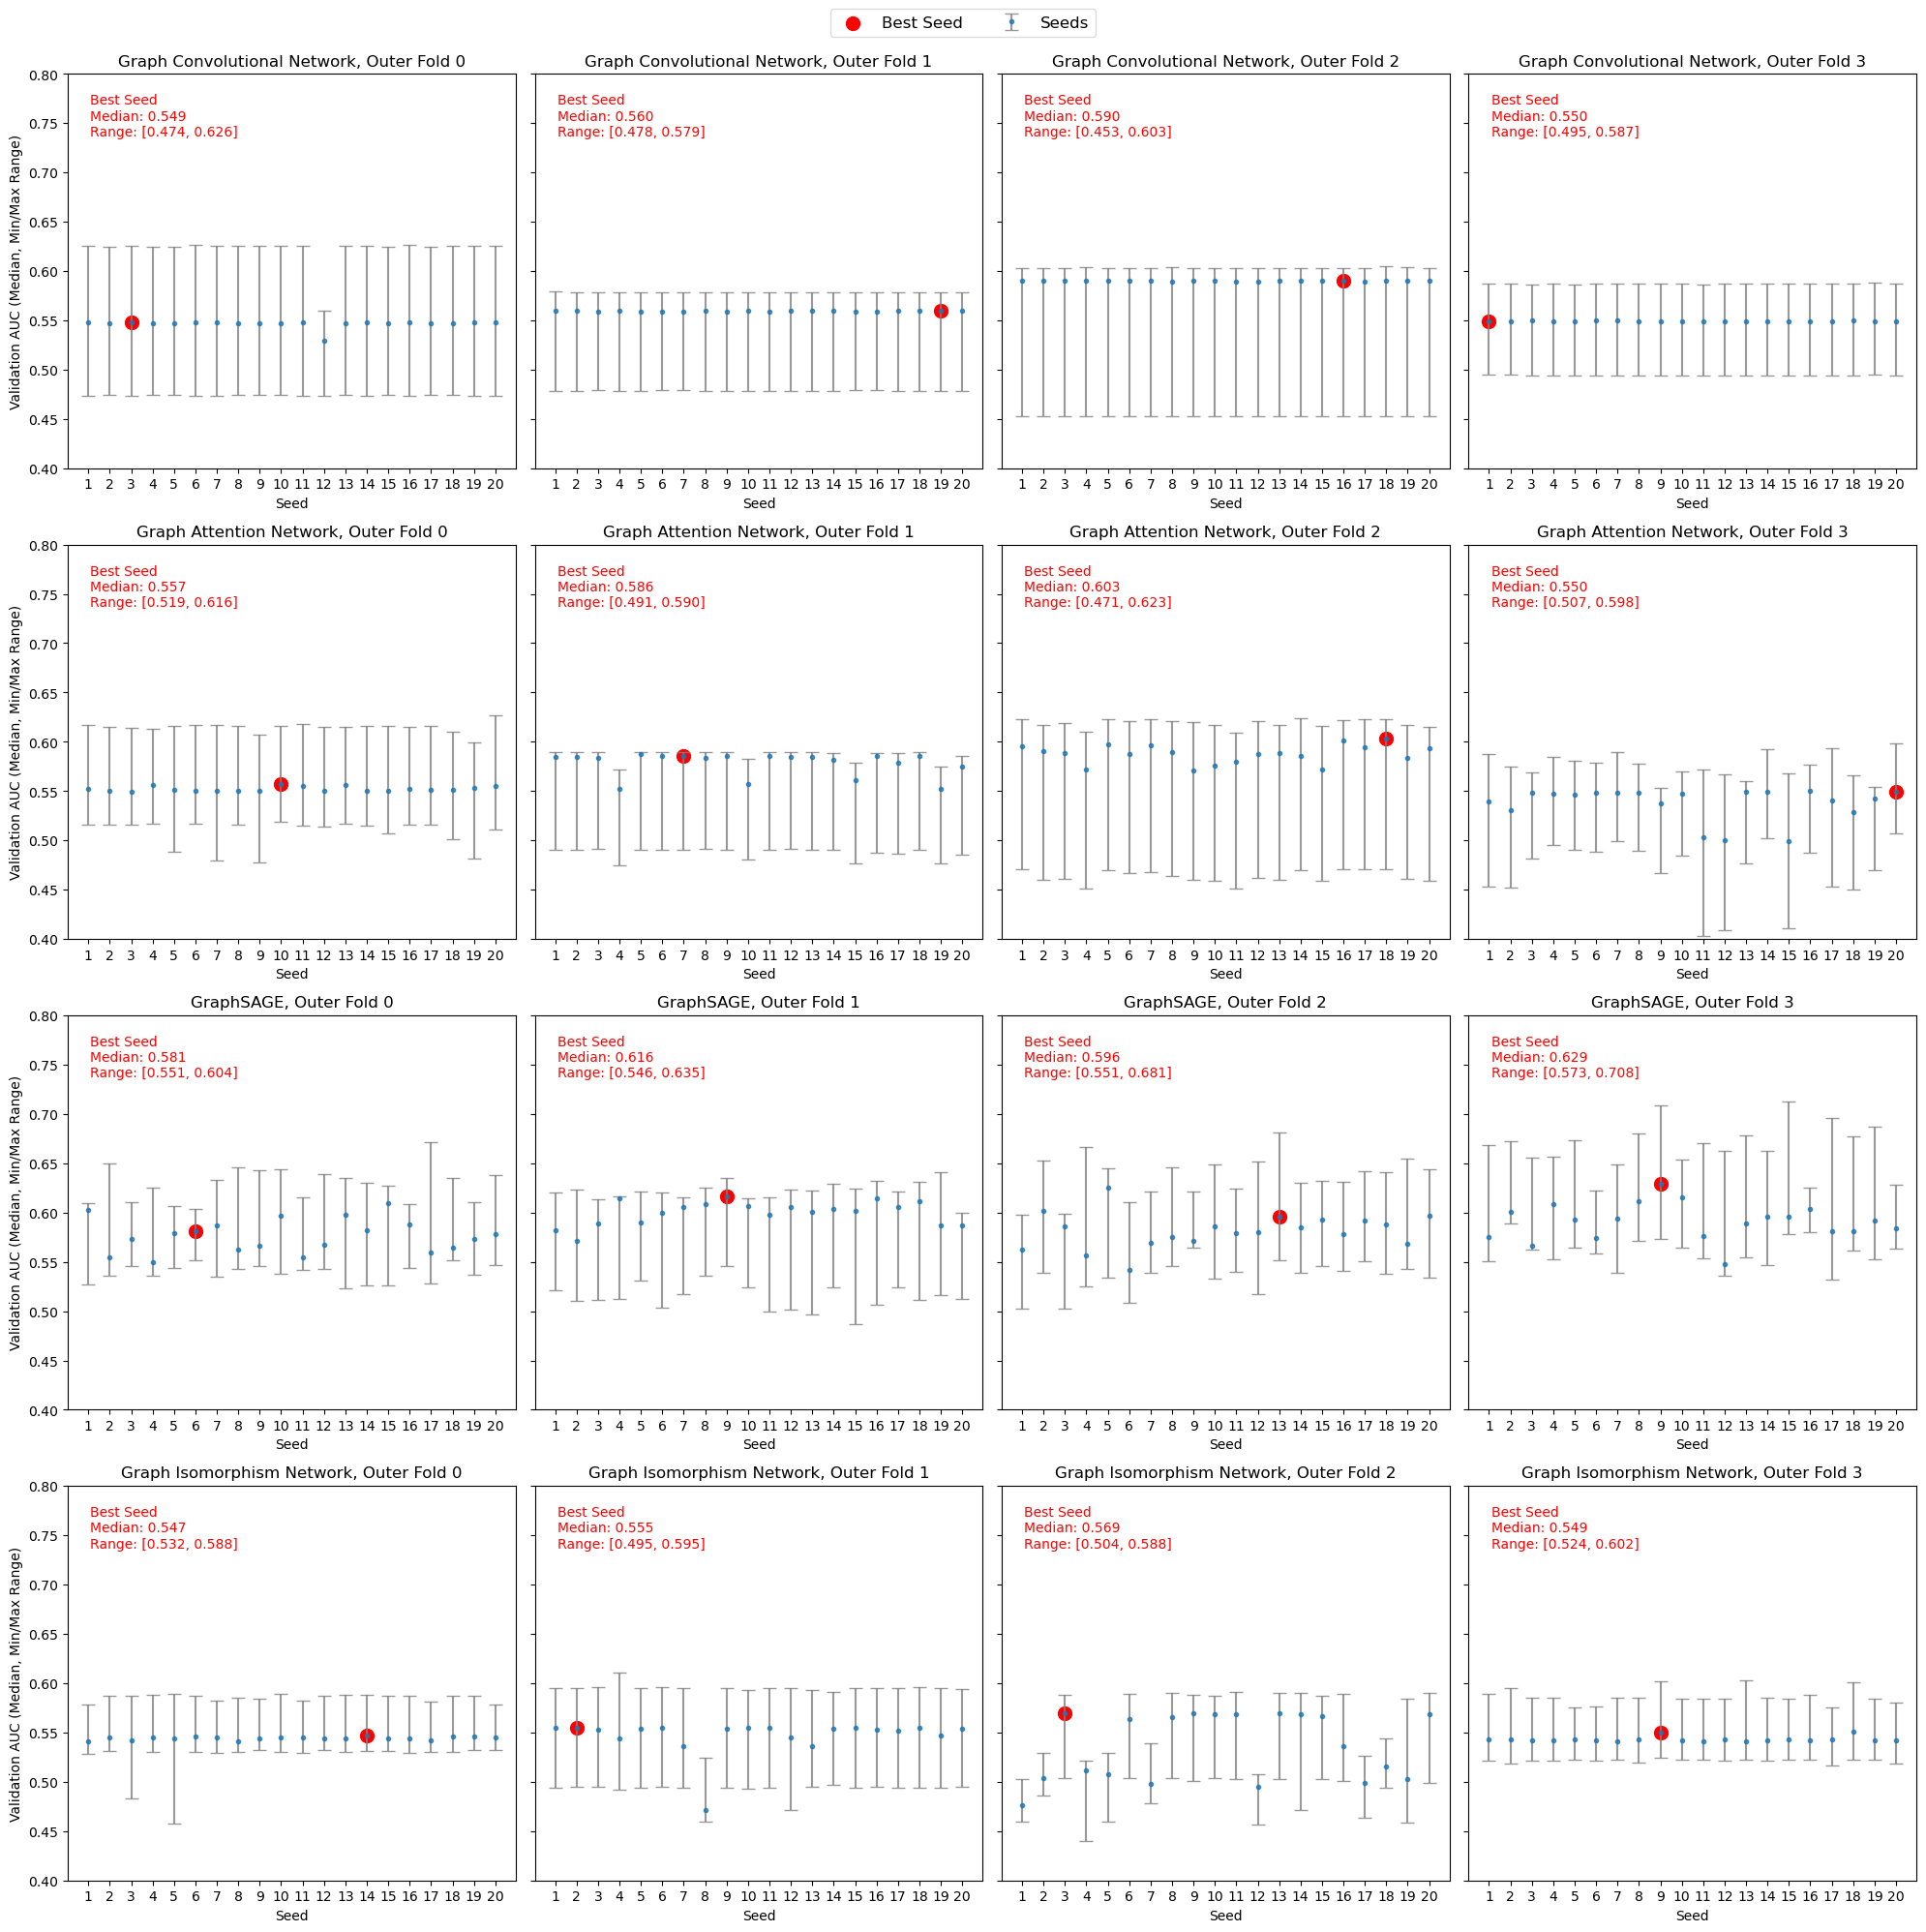

In [10]:
save_dir="results/grid_search/dlst_min/initial_model_p20_20"
with open(os.path.join(save_dir, 'results_init.pkl'), 'rb') as f:
    results_init = pickle.load(f)
    
best_model_paths = select_best_models(results_init, save_dir)
plot_seed_performance(results_init, best_model_paths, save_dir = save_dir, ylim = (0.4, 0.8), prefix = 'DILI_min')

{'GCN_Optimised': 1, 'GAT_Optimised': 1, 'GraphSAGE_Optimised': 2, 'GIN_Optimised': 1} 

For model GCN, mean val_auc of the last significant run across 20 inner folds: 0.549 ± 0.046
For model GAT, mean val_auc of the last significant run across 20 inner folds: 0.565 ± 0.043
For model GraphSAGE, mean val_auc of the last significant run across 20 inner folds: 0.681 ± 0.065
For model GIN, mean val_auc of the last significant run across 20 inner folds: 0.517 ± 0.041


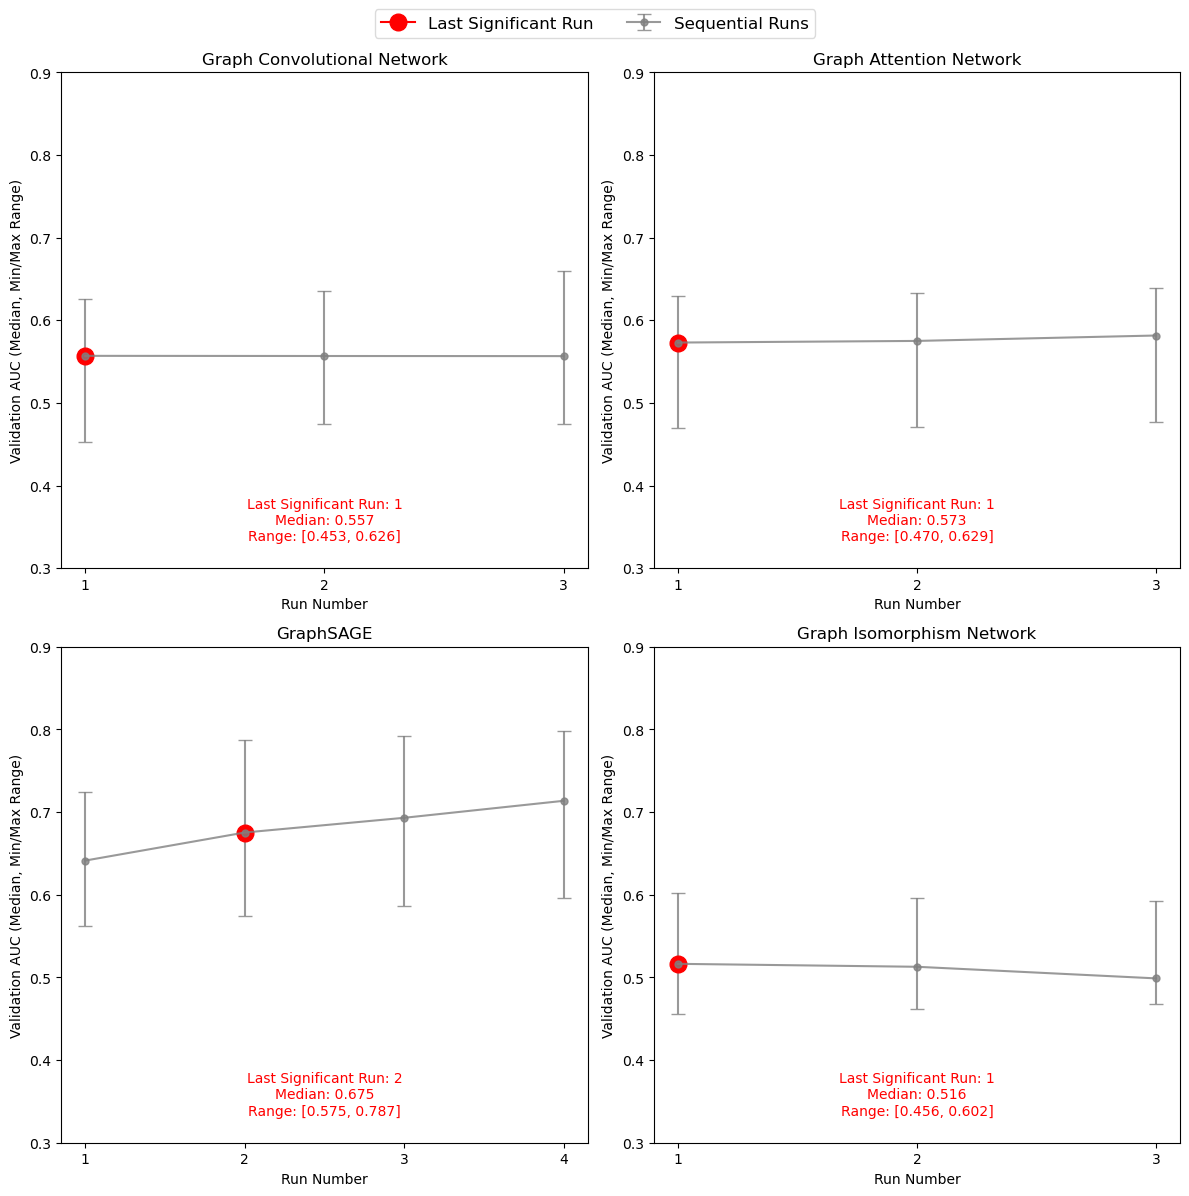

In [11]:
save_dir_ws = os.path.join(save_dir, 'warm_starts_p50')
with open(os.path.join(save_dir_ws, 'last_significant_run.pkl'), 'rb') as f:
   last_significant_run = pickle.load(f)
with open(os.path.join(save_dir_ws, 'results.pkl'), 'rb') as f:
    results = pickle.load(f)
print(last_significant_run,'\n')
plot_median_val_auc_with_error_bars(results, last_significant_run, ylim = (0.3, 0.9), save_dir = save_dir_ws, prefix = 'DILI_min')

In [12]:
models = {
    'GCN_Optimised': GNNModel,
    'GAT_Optimised': GNNModel,
    'GraphSAGE_Optimised': GNNModel,
    'GIN_Optimised': GINModel
}

loaded_models = load_best_models(
    models=models,
    best_model_paths=best_model_paths,
    all_optimised_hyperparameters=grid_search_hyperparameters_ranking,
    pytorch_custom_dataset = dlst_min
)

final_test_results = test_final_models_on_outer_cv(
    loaded_models=loaded_models, 
    all_optimised_hyperparameters=grid_search_hyperparameters_ranking, 
    pytorch_custom_dataset=dlst_min,
    last_significant_run=last_significant_run,
    save_dir=save_dir_ws
)


Testing final GCN_Optimised model on outer CV test sets...
  Outer Fold 1/4
    Inner Fold 1/5
Loading model from results/grid_search/dlst_min/initial_model_p20_20/warm_starts_p50/GCN_Optimised_outer0_inner0_run1.pt
Outer Fold 1, Inner Fold 1: Test AUC: 0.5263, Test Accuracy: 0.3801, Test F1: 0.0000, Test MCC: 0.0000
    Inner Fold 2/5
Loading model from results/grid_search/dlst_min/initial_model_p20_20/warm_starts_p50/GCN_Optimised_outer0_inner1_run1.pt
Outer Fold 1, Inner Fold 2: Test AUC: 0.5264, Test Accuracy: 0.3801, Test F1: 0.0000, Test MCC: 0.0000
    Inner Fold 3/5
Loading model from results/grid_search/dlst_min/initial_model_p20_20/warm_starts_p50/GCN_Optimised_outer0_inner2_run1.pt
Outer Fold 1, Inner Fold 3: Test AUC: 0.5263, Test Accuracy: 0.3801, Test F1: 0.0000, Test MCC: 0.0000
    Inner Fold 4/5
Loading model from results/grid_search/dlst_min/initial_model_p20_20/warm_starts_p50/GCN_Optimised_outer0_inner3_run1.pt
Outer Fold 1, Inner Fold 4: Test AUC: 0.5264, Test Acc

##### Custom molecular graph

For model GCN, mean val_auc of optimal hyperparameters across 20 inner folds: 0.627 ± 0.034
For model GAT, mean val_auc of optimal hyperparameters across 20 inner folds: 0.627 ± 0.031
For model GraphSAGE, mean val_auc of optimal hyperparameters across 20 inner folds: 0.624 ± 0.032
For model GIN, mean val_auc of optimal hyperparameters across 20 inner folds: 0.626 ± 0.032


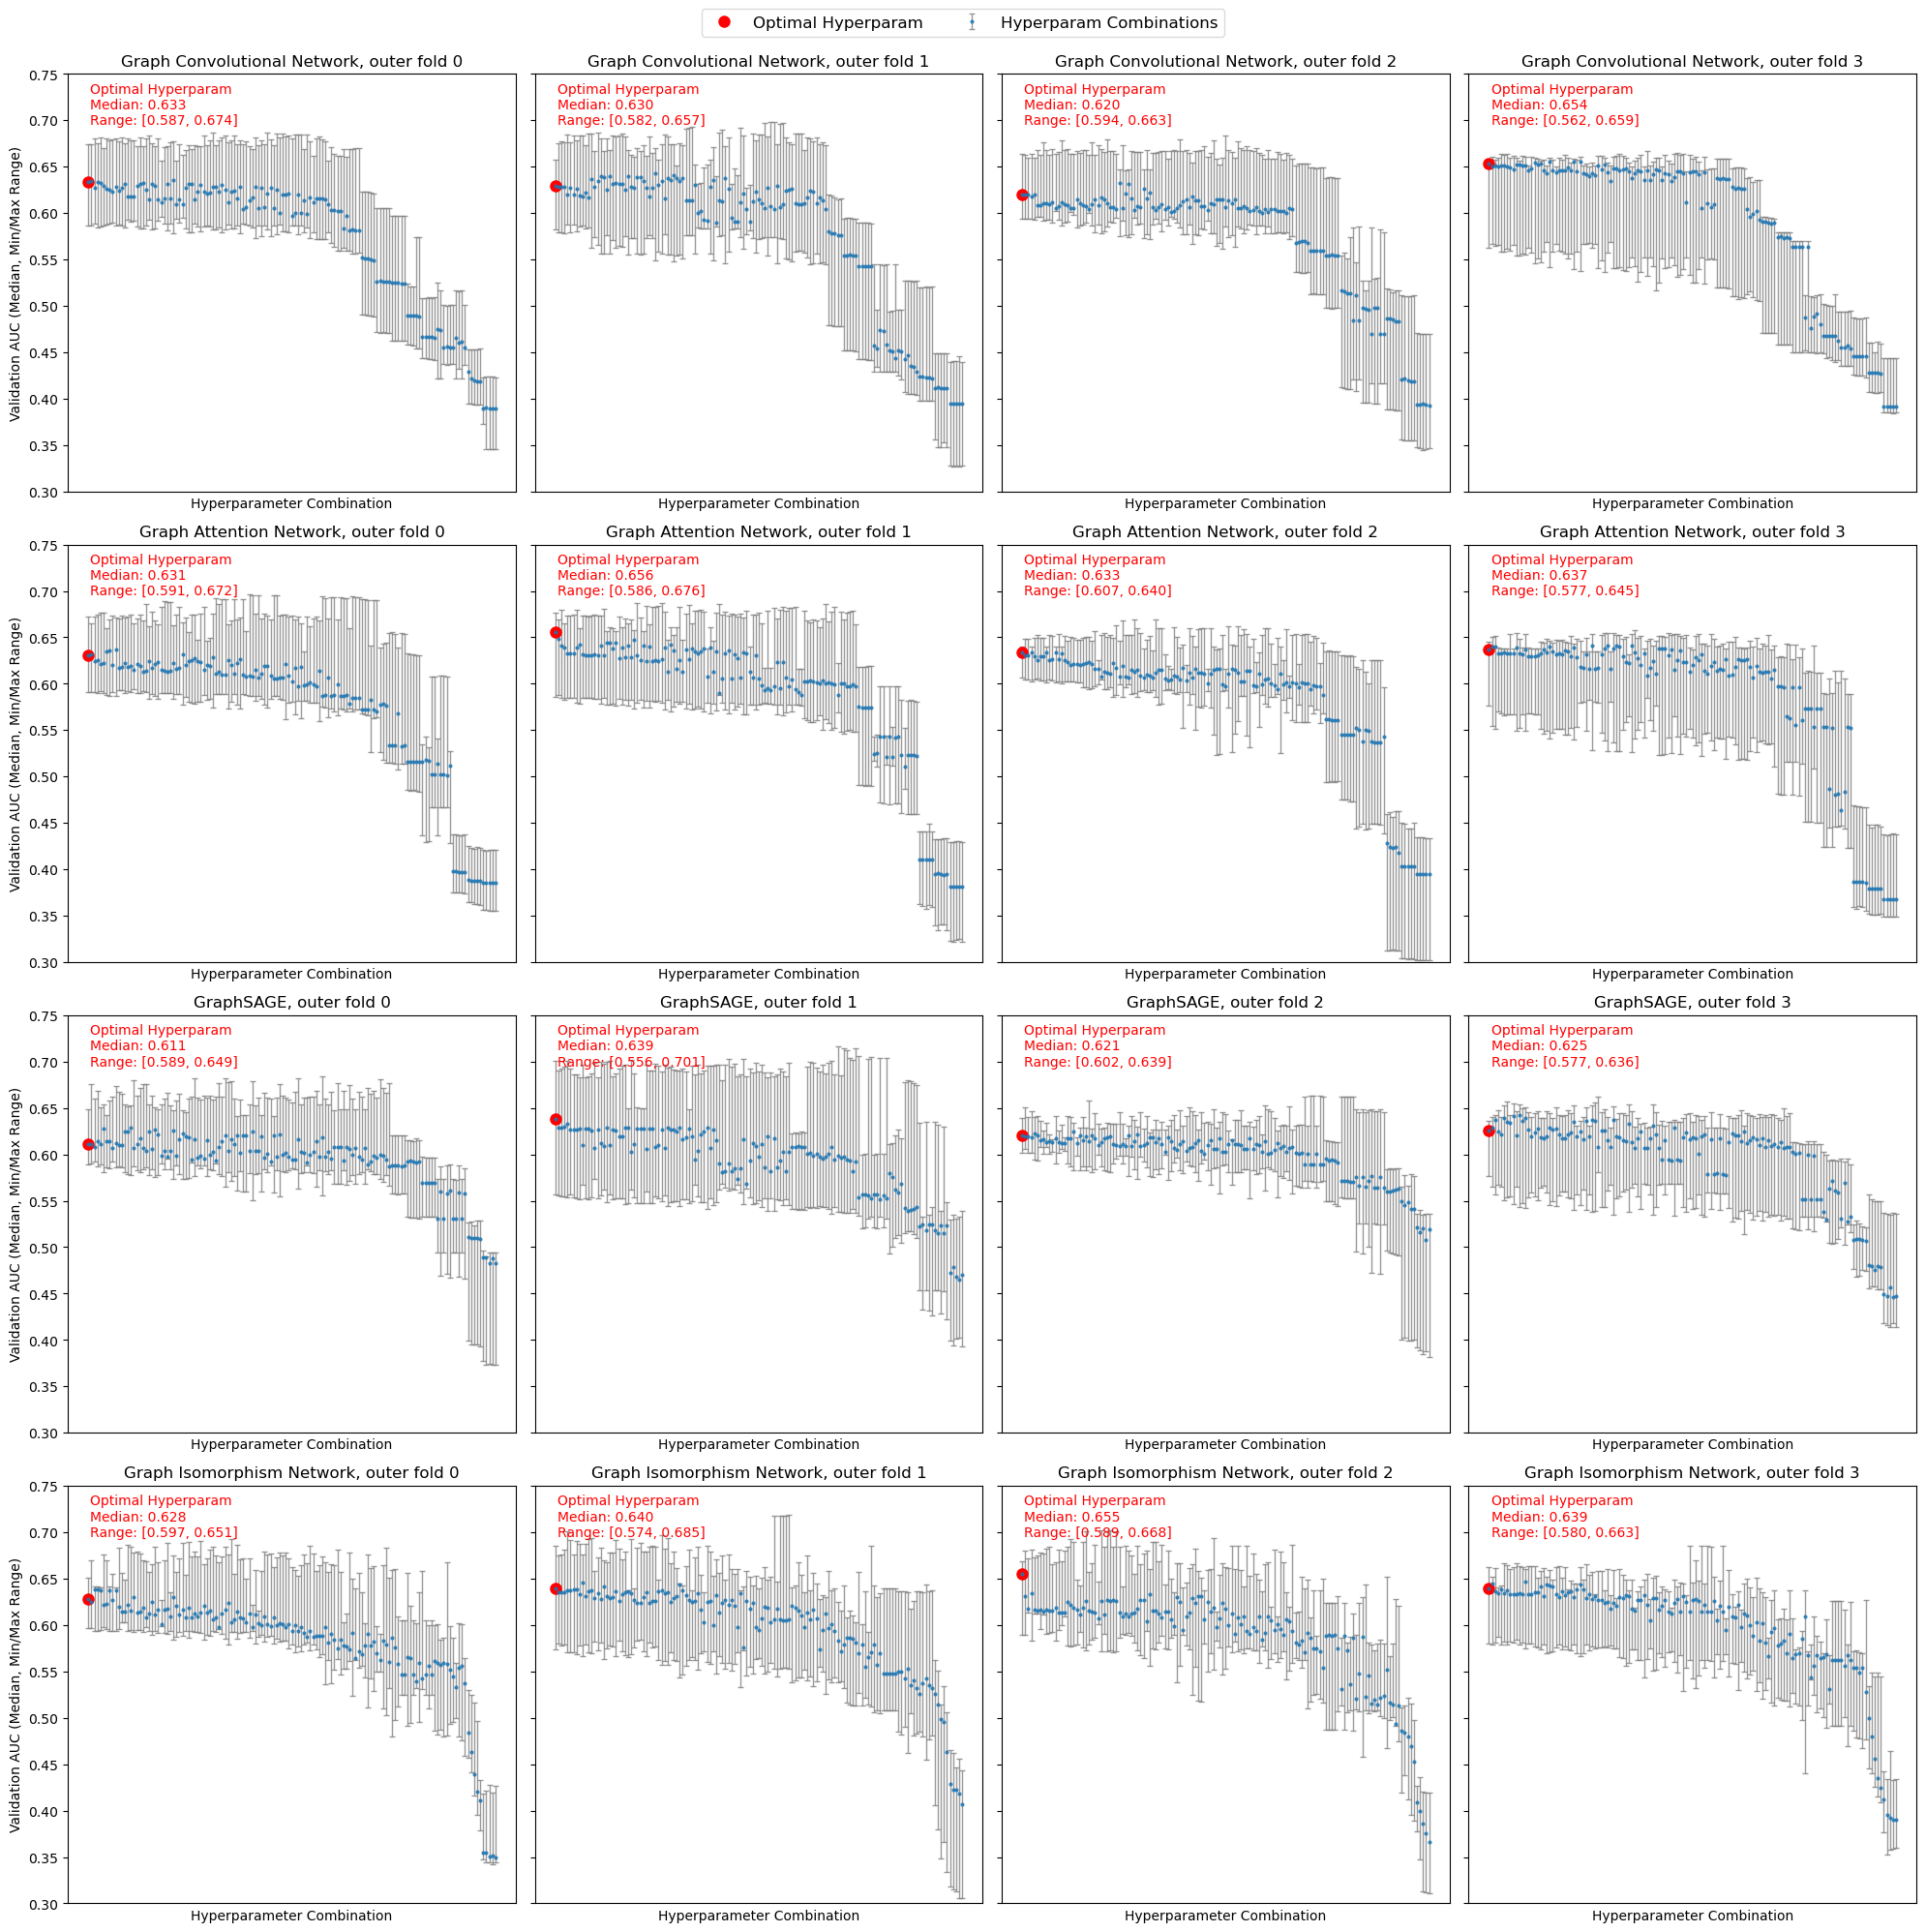

In [13]:
results_dir = 'results/grid_search/dlst'
hyperparam_df = pd.read_csv(os.path.join(results_dir, 'grid_search_results.csv'))
grid_search_hyperparameters_ranking = plot_hyperparameter_performance_ranking(hyperparam_df, save_dir = results_dir, prefix = 'DILI')

For model GCN, mean val_auc of the best seed across 20 inner folds: 0.670 ± 0.037
For model GAT, mean val_auc of the best seed across 20 inner folds: 0.695 ± 0.047
For model GraphSAGE, mean val_auc of the best seed across 20 inner folds: 0.692 ± 0.043
For model GIN, mean val_auc of the best seed across 20 inner folds: 0.671 ± 0.033


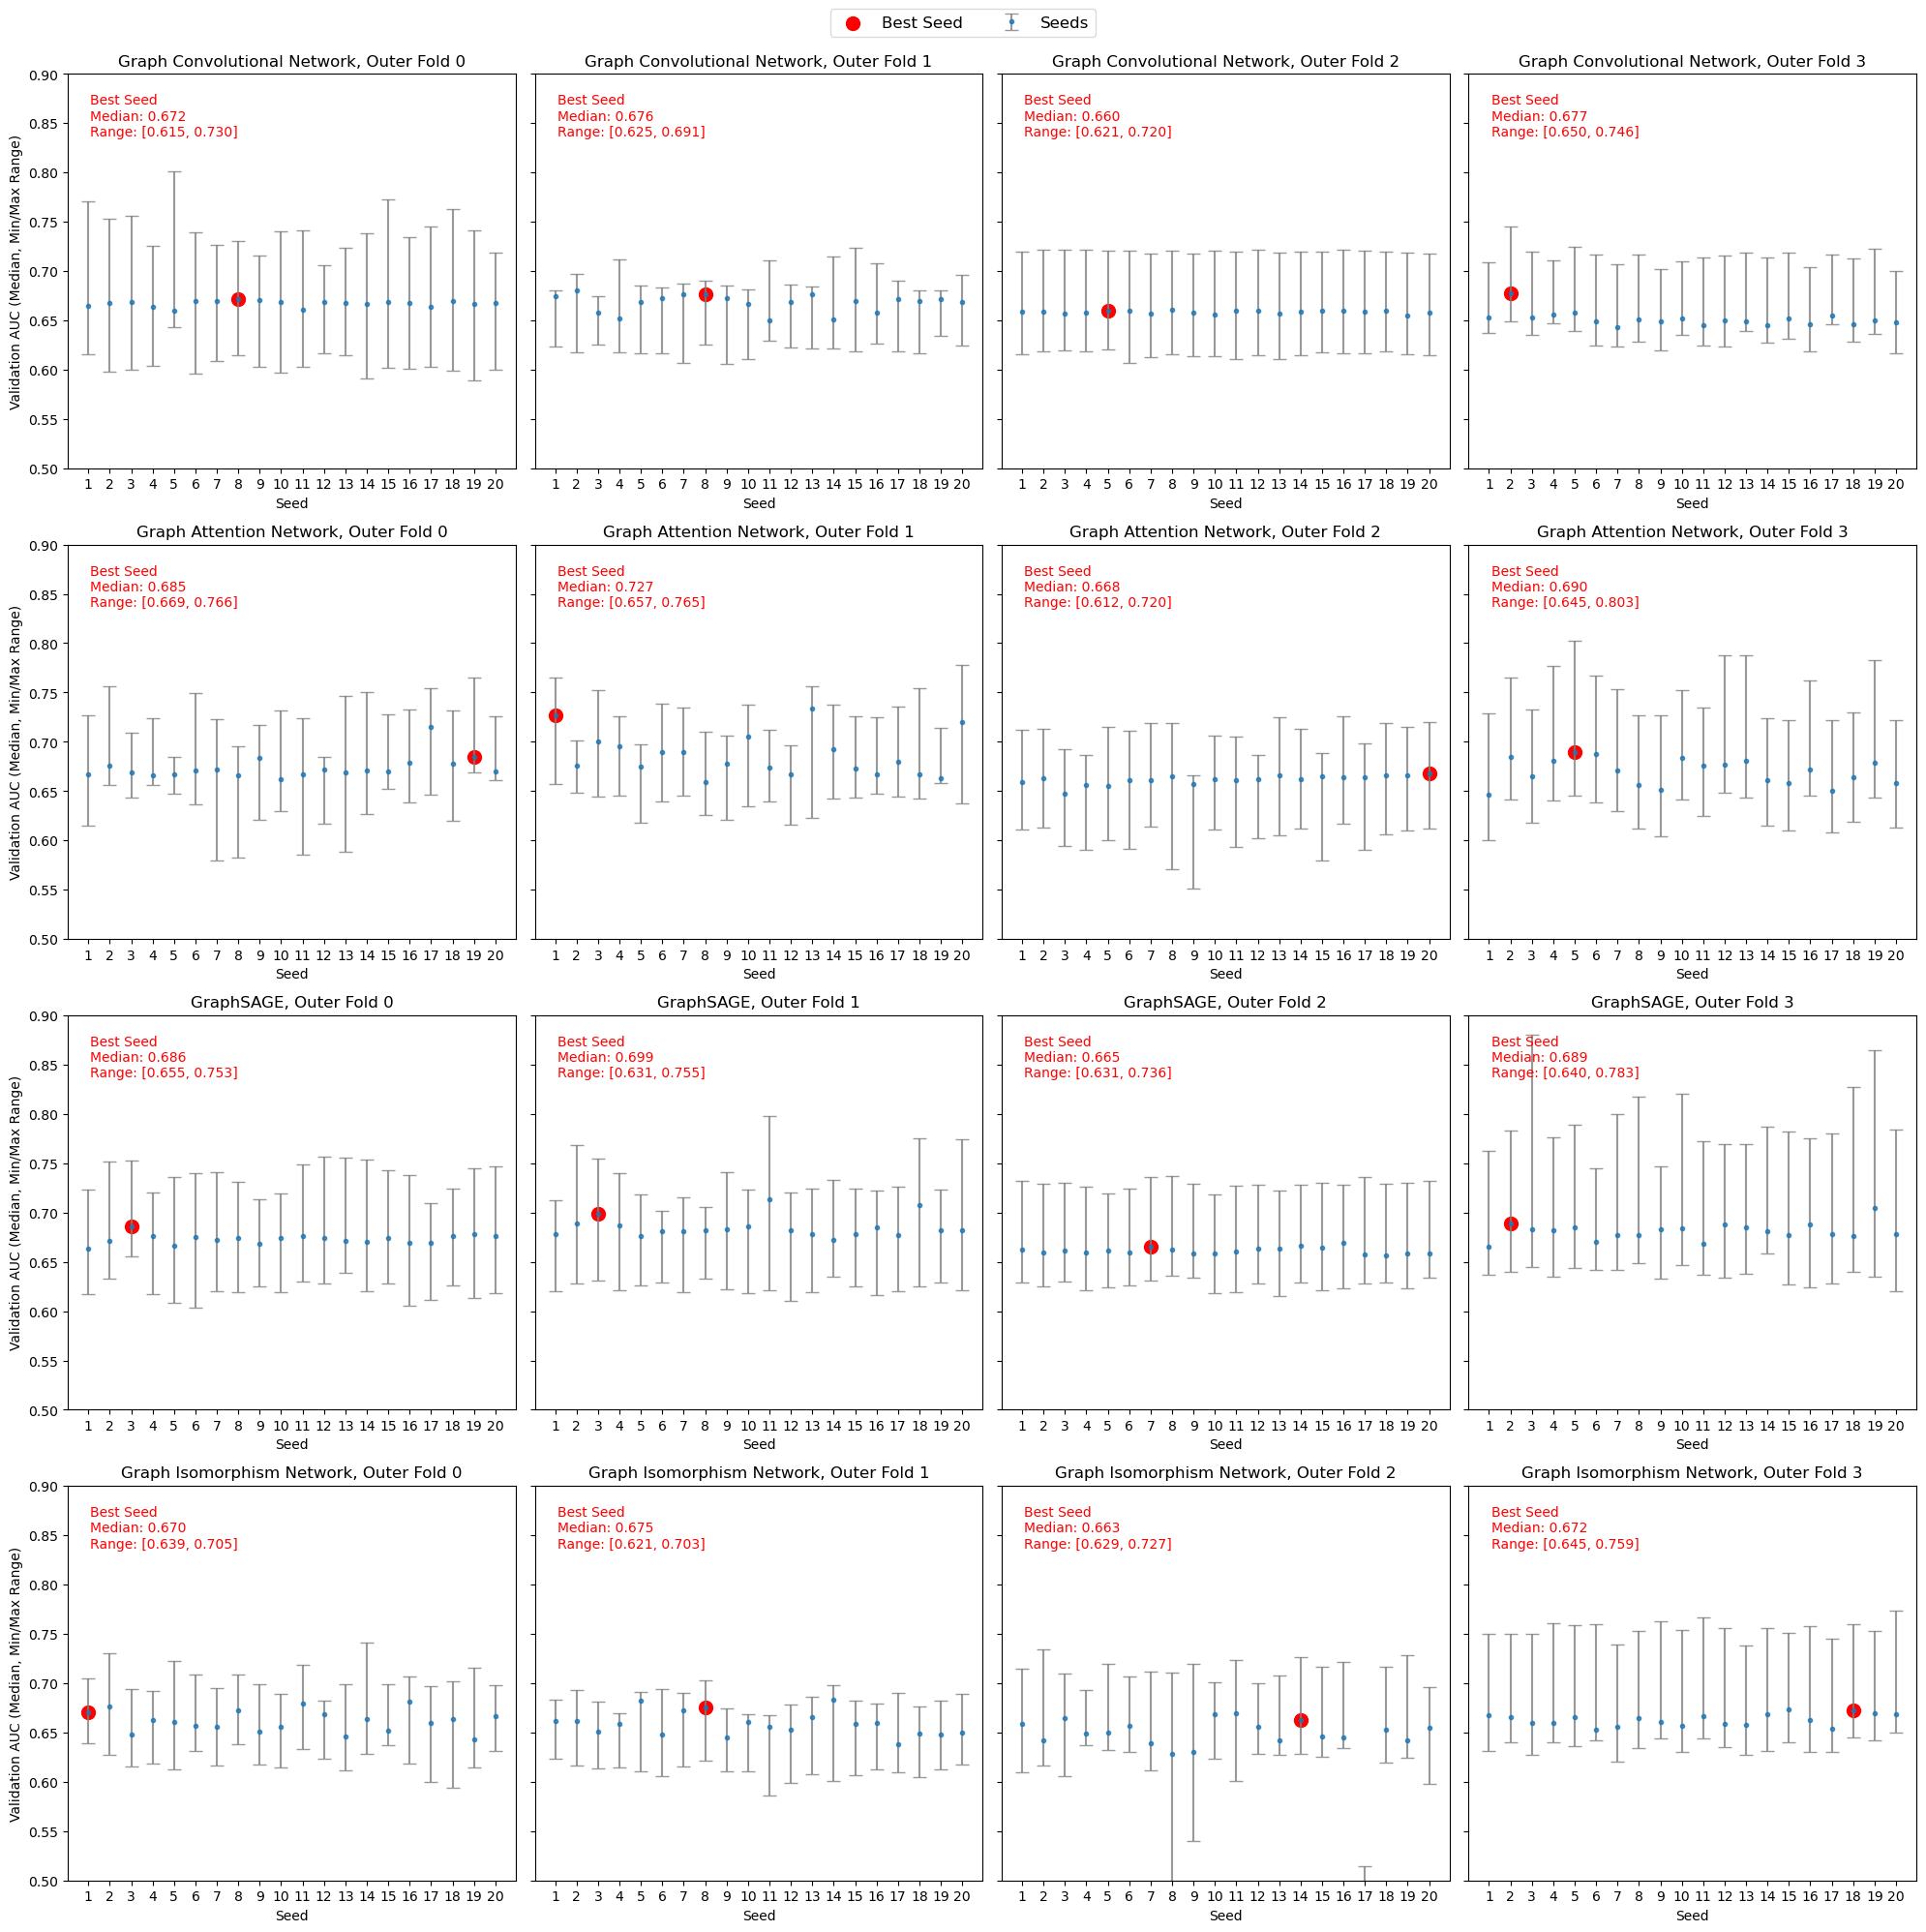

In [14]:
save_dir="results/grid_search/dlst/initial_model_p20_20"
with open(os.path.join(save_dir, 'results_init.pkl'), 'rb') as f:
    results_init = pickle.load(f)
    
best_model_paths = select_best_models(results_init, save_dir)
plot_seed_performance(results_init, best_model_paths, save_dir = save_dir, prefix = 'DILI')

{'GCN_Optimised': 4, 'GAT_Optimised': 1, 'GraphSAGE_Optimised': 3, 'GIN_Optimised': 5} 

For model GCN, mean val_auc of the last significant run across 20 inner folds: 0.881 ± 0.062
For model GAT, mean val_auc of the last significant run across 20 inner folds: 0.728 ± 0.054
For model GraphSAGE, mean val_auc of the last significant run across 20 inner folds: 0.953 ± 0.061
For model GIN, mean val_auc of the last significant run across 20 inner folds: 0.916 ± 0.051


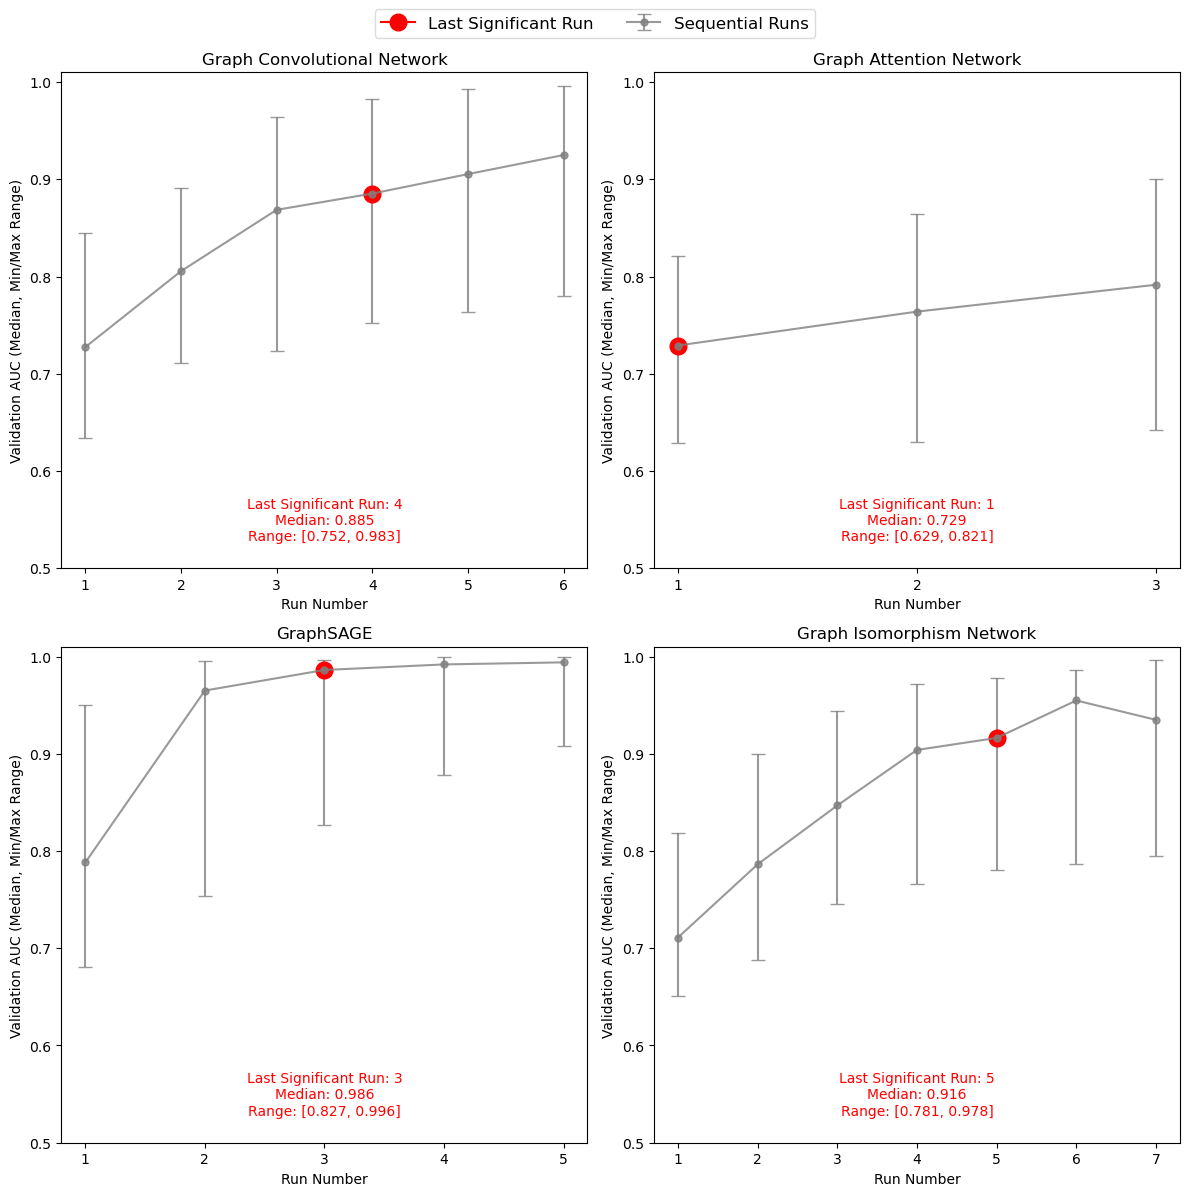

In [15]:
save_dir_ws = os.path.join(save_dir, 'warm_starts_p50')
with open(os.path.join(save_dir_ws, 'last_significant_run.pkl'), 'rb') as f:
   last_significant_run = pickle.load(f)
with open(os.path.join(save_dir_ws, 'results.pkl'), 'rb') as f:
    results = pickle.load(f)
print(last_significant_run, '\n')
plot_median_val_auc_with_error_bars(results, last_significant_run, save_dir = save_dir_ws, prefix = 'DILI')

In [16]:
models = {
    'GCN_Optimised': GNNModel,
    'GAT_Optimised': GNNModel,
    'GraphSAGE_Optimised': GNNModel,
    'GIN_Optimised': GINModel
}

loaded_models = load_best_models(
    models=models,
    best_model_paths=best_model_paths,
    all_optimised_hyperparameters=grid_search_hyperparameters_ranking,
    pytorch_custom_dataset = dlst_cus_2_std
)

final_test_results = test_final_models_on_outer_cv(
    loaded_models=loaded_models, 
    all_optimised_hyperparameters=grid_search_hyperparameters_ranking, 
    pytorch_custom_dataset=dlst_cus_2_std,
    last_significant_run=last_significant_run,
    save_dir=save_dir_ws
)


Testing final GCN_Optimised model on outer CV test sets...
  Outer Fold 1/4
    Inner Fold 1/5
Loading model from results/grid_search/dlst/initial_model_p20_20/warm_starts_p50/GCN_Optimised_outer0_inner0_run4.pt
Outer Fold 1, Inner Fold 1: Test AUC: 0.9151, Test Accuracy: 0.8288, Test F1: 0.8476, Test MCC: 0.6756
    Inner Fold 2/5
Loading model from results/grid_search/dlst/initial_model_p20_20/warm_starts_p50/GCN_Optimised_outer0_inner1_run4.pt
Outer Fold 1, Inner Fold 2: Test AUC: 0.9218, Test Accuracy: 0.8082, Test F1: 0.8217, Test MCC: 0.6596
    Inner Fold 3/5
Loading model from results/grid_search/dlst/initial_model_p20_20/warm_starts_p50/GCN_Optimised_outer0_inner2_run4.pt
Outer Fold 1, Inner Fold 3: Test AUC: 0.9228, Test Accuracy: 0.8253, Test F1: 0.8401, Test MCC: 0.6848
    Inner Fold 4/5
Loading model from results/grid_search/dlst/initial_model_p20_20/warm_starts_p50/GCN_Optimised_outer0_inner3_run4.pt
Outer Fold 1, Inner Fold 4: Test AUC: 0.9079, Test Accuracy: 0.8322, T

### Blood Brain Barrier Penetration (BBBP)

In [21]:
# Generated from DILIGeNN Data Preprocessing.ipynb
df_bbbp_filtered_cleaned = pd.read_csv('chem_data/bbbp_standardised_cleaned.csv', index_col = 0)

bbbp_min = Graph_basic(dataframe = df_bbbp_filtered_cleaned,
                              smiles_col = 'smiles',
                             label_col = 'label',
                             root = 'custom_data/minimal_feature/bbbp_min'
                            )
bbbp_cus_2_std = Graph_custom(dataframe = df_bbbp_filtered_cleaned,
                              smiles_col = 'smiles_std',
                             label_col = 'label',
                             root = 'custom_data/bbbp/cus2_std/'
                            )


##### Basic molecular graph

For model GCN, mean val_auc of optimal hyperparameters across 20 inner folds: 0.425 ± 0.096
For model GAT, mean val_auc of optimal hyperparameters across 20 inner folds: 0.506 ± 0.119
For model GraphSAGE, mean val_auc of optimal hyperparameters across 20 inner folds: 0.561 ± 0.127
For model GIN, mean val_auc of optimal hyperparameters across 20 inner folds: 0.560 ± 0.112


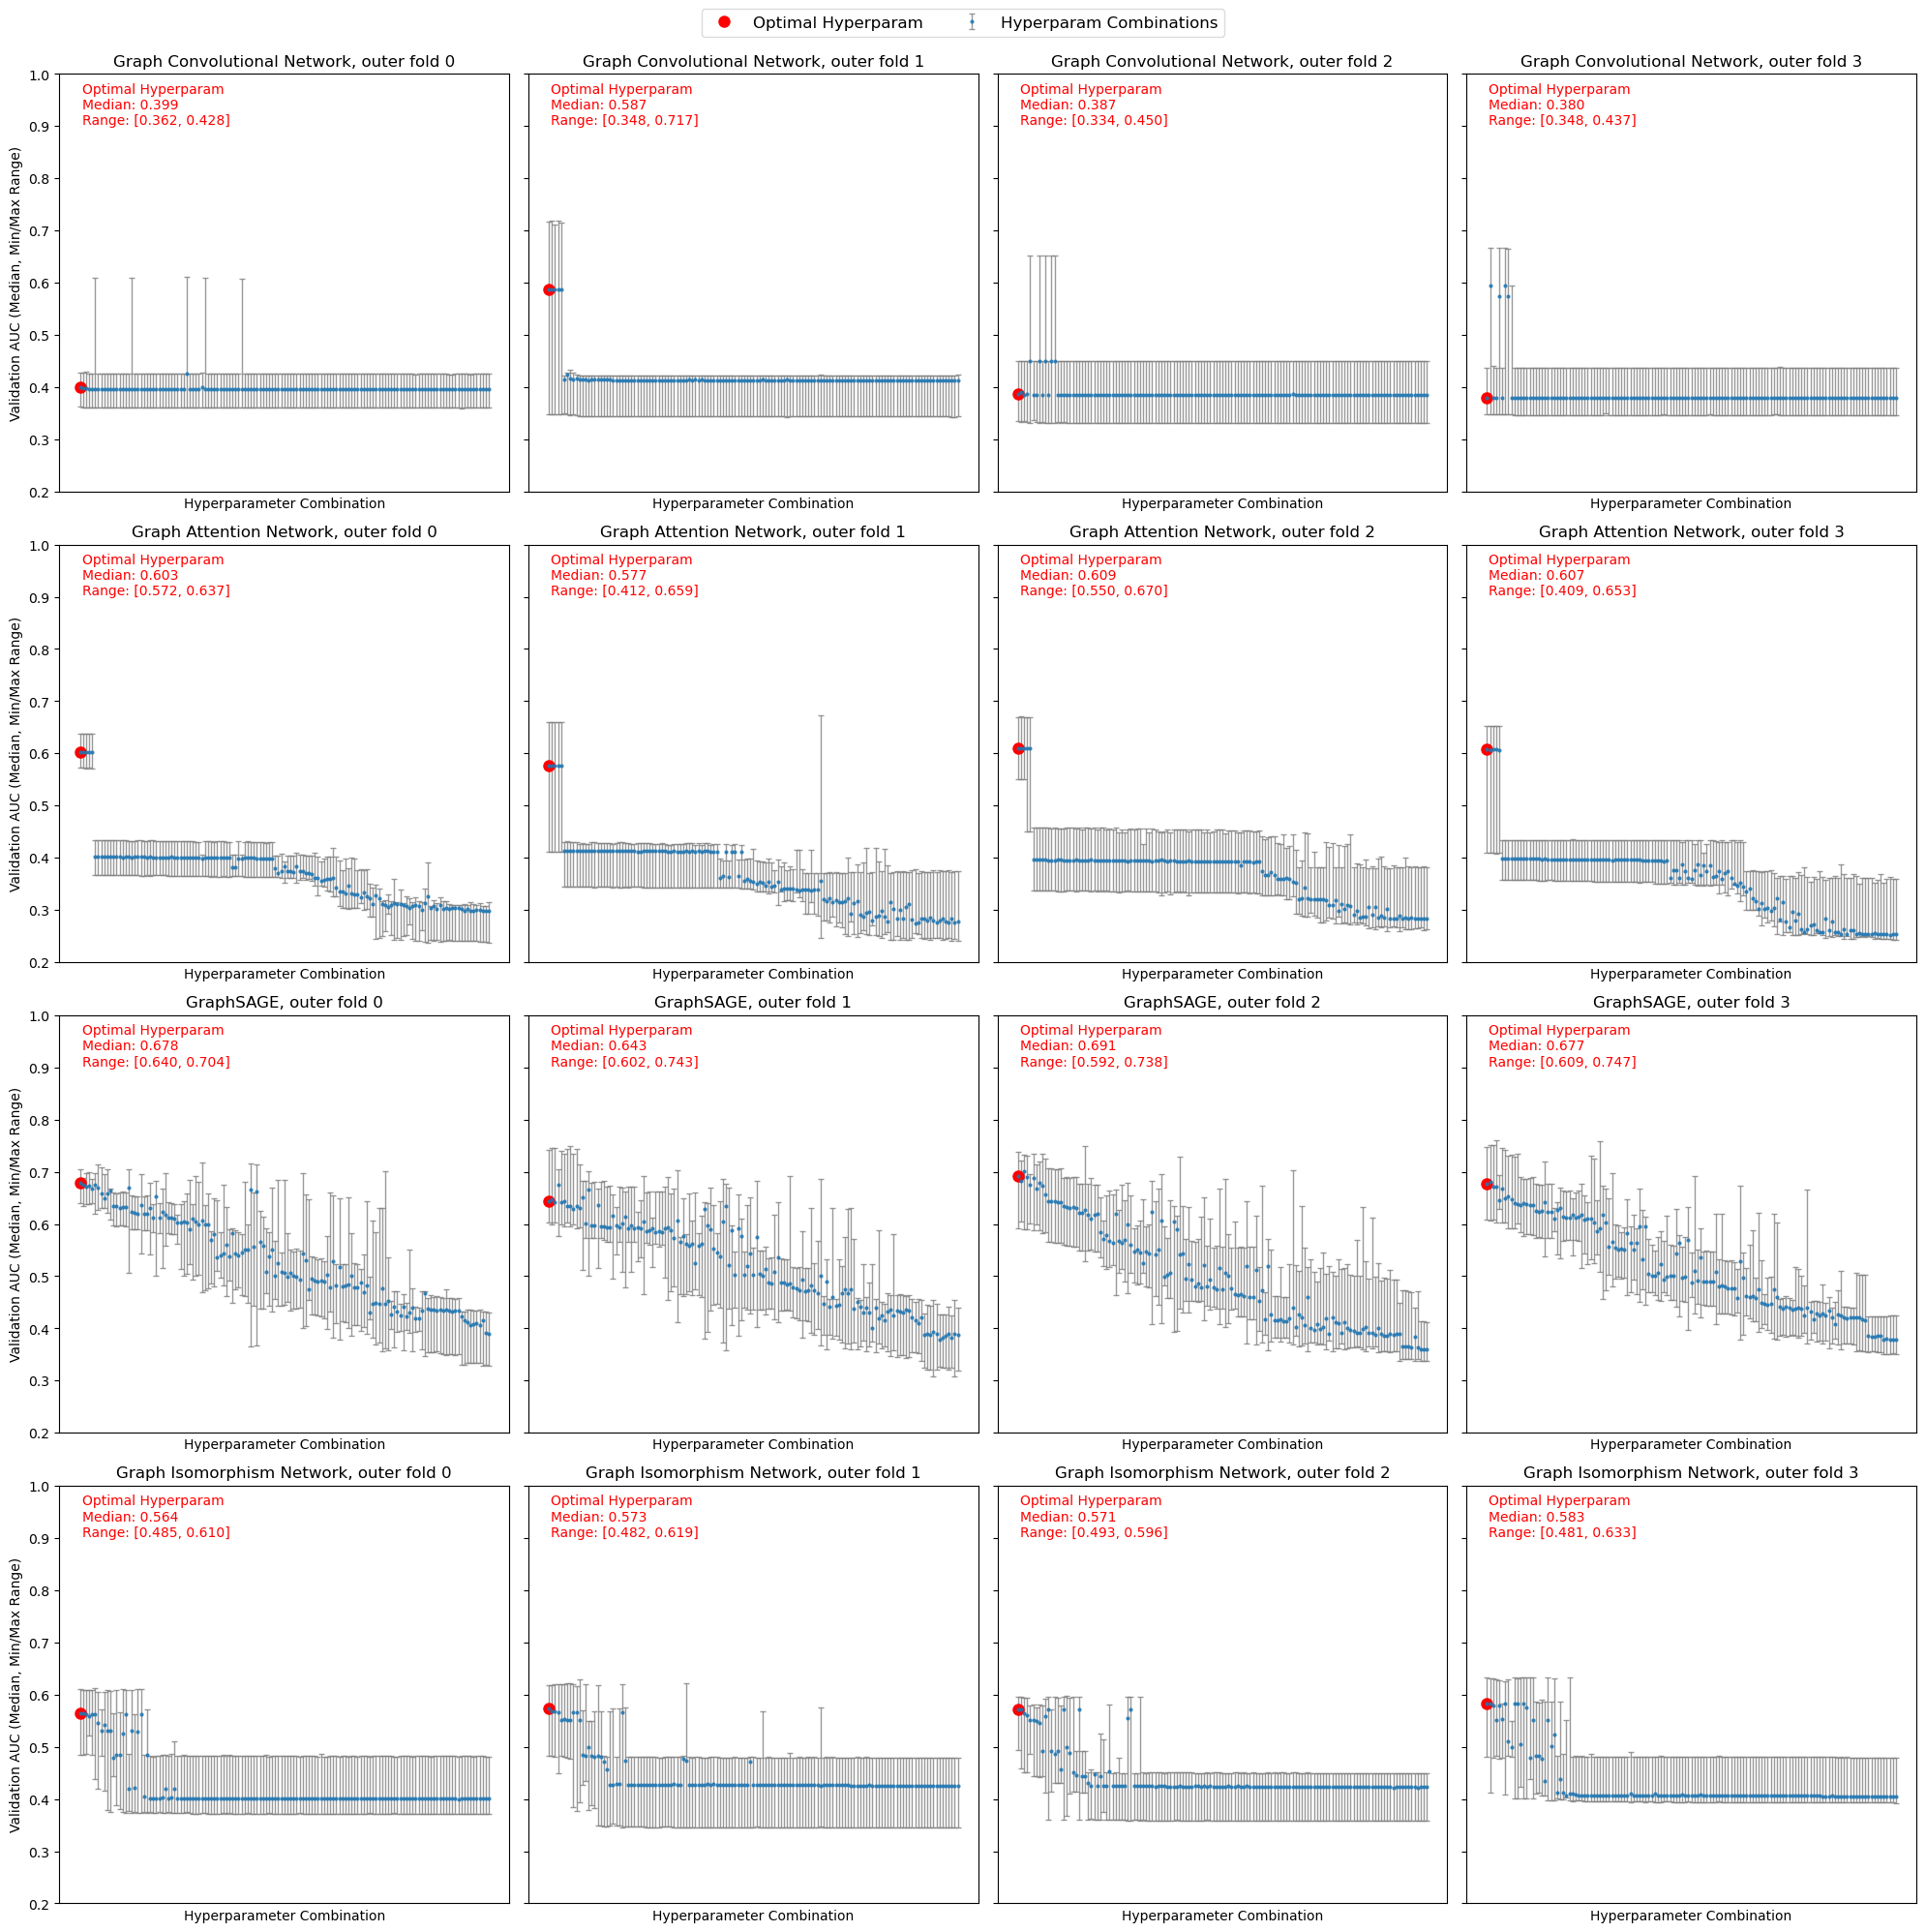

In [17]:
results_dir = 'results/grid_search/bbbp_min'
hyperparam_df = pd.read_csv(os.path.join(results_dir, 'grid_search_results.csv'))
grid_search_hyperparameters_ranking = plot_hyperparameter_performance_ranking(hyperparam_df, save_dir = results_dir, 
                                                                              ylim = (0.2, 1), prefix = 'BBBP_min')

For model GCN, mean val_auc of the best seed across 20 inner folds: 0.586 ± 0.119
For model GAT, mean val_auc of the best seed across 20 inner folds: 0.421 ± 0.071
For model GraphSAGE, mean val_auc of the best seed across 20 inner folds: 0.684 ± 0.044
For model GIN, mean val_auc of the best seed across 20 inner folds: 0.551 ± 0.036


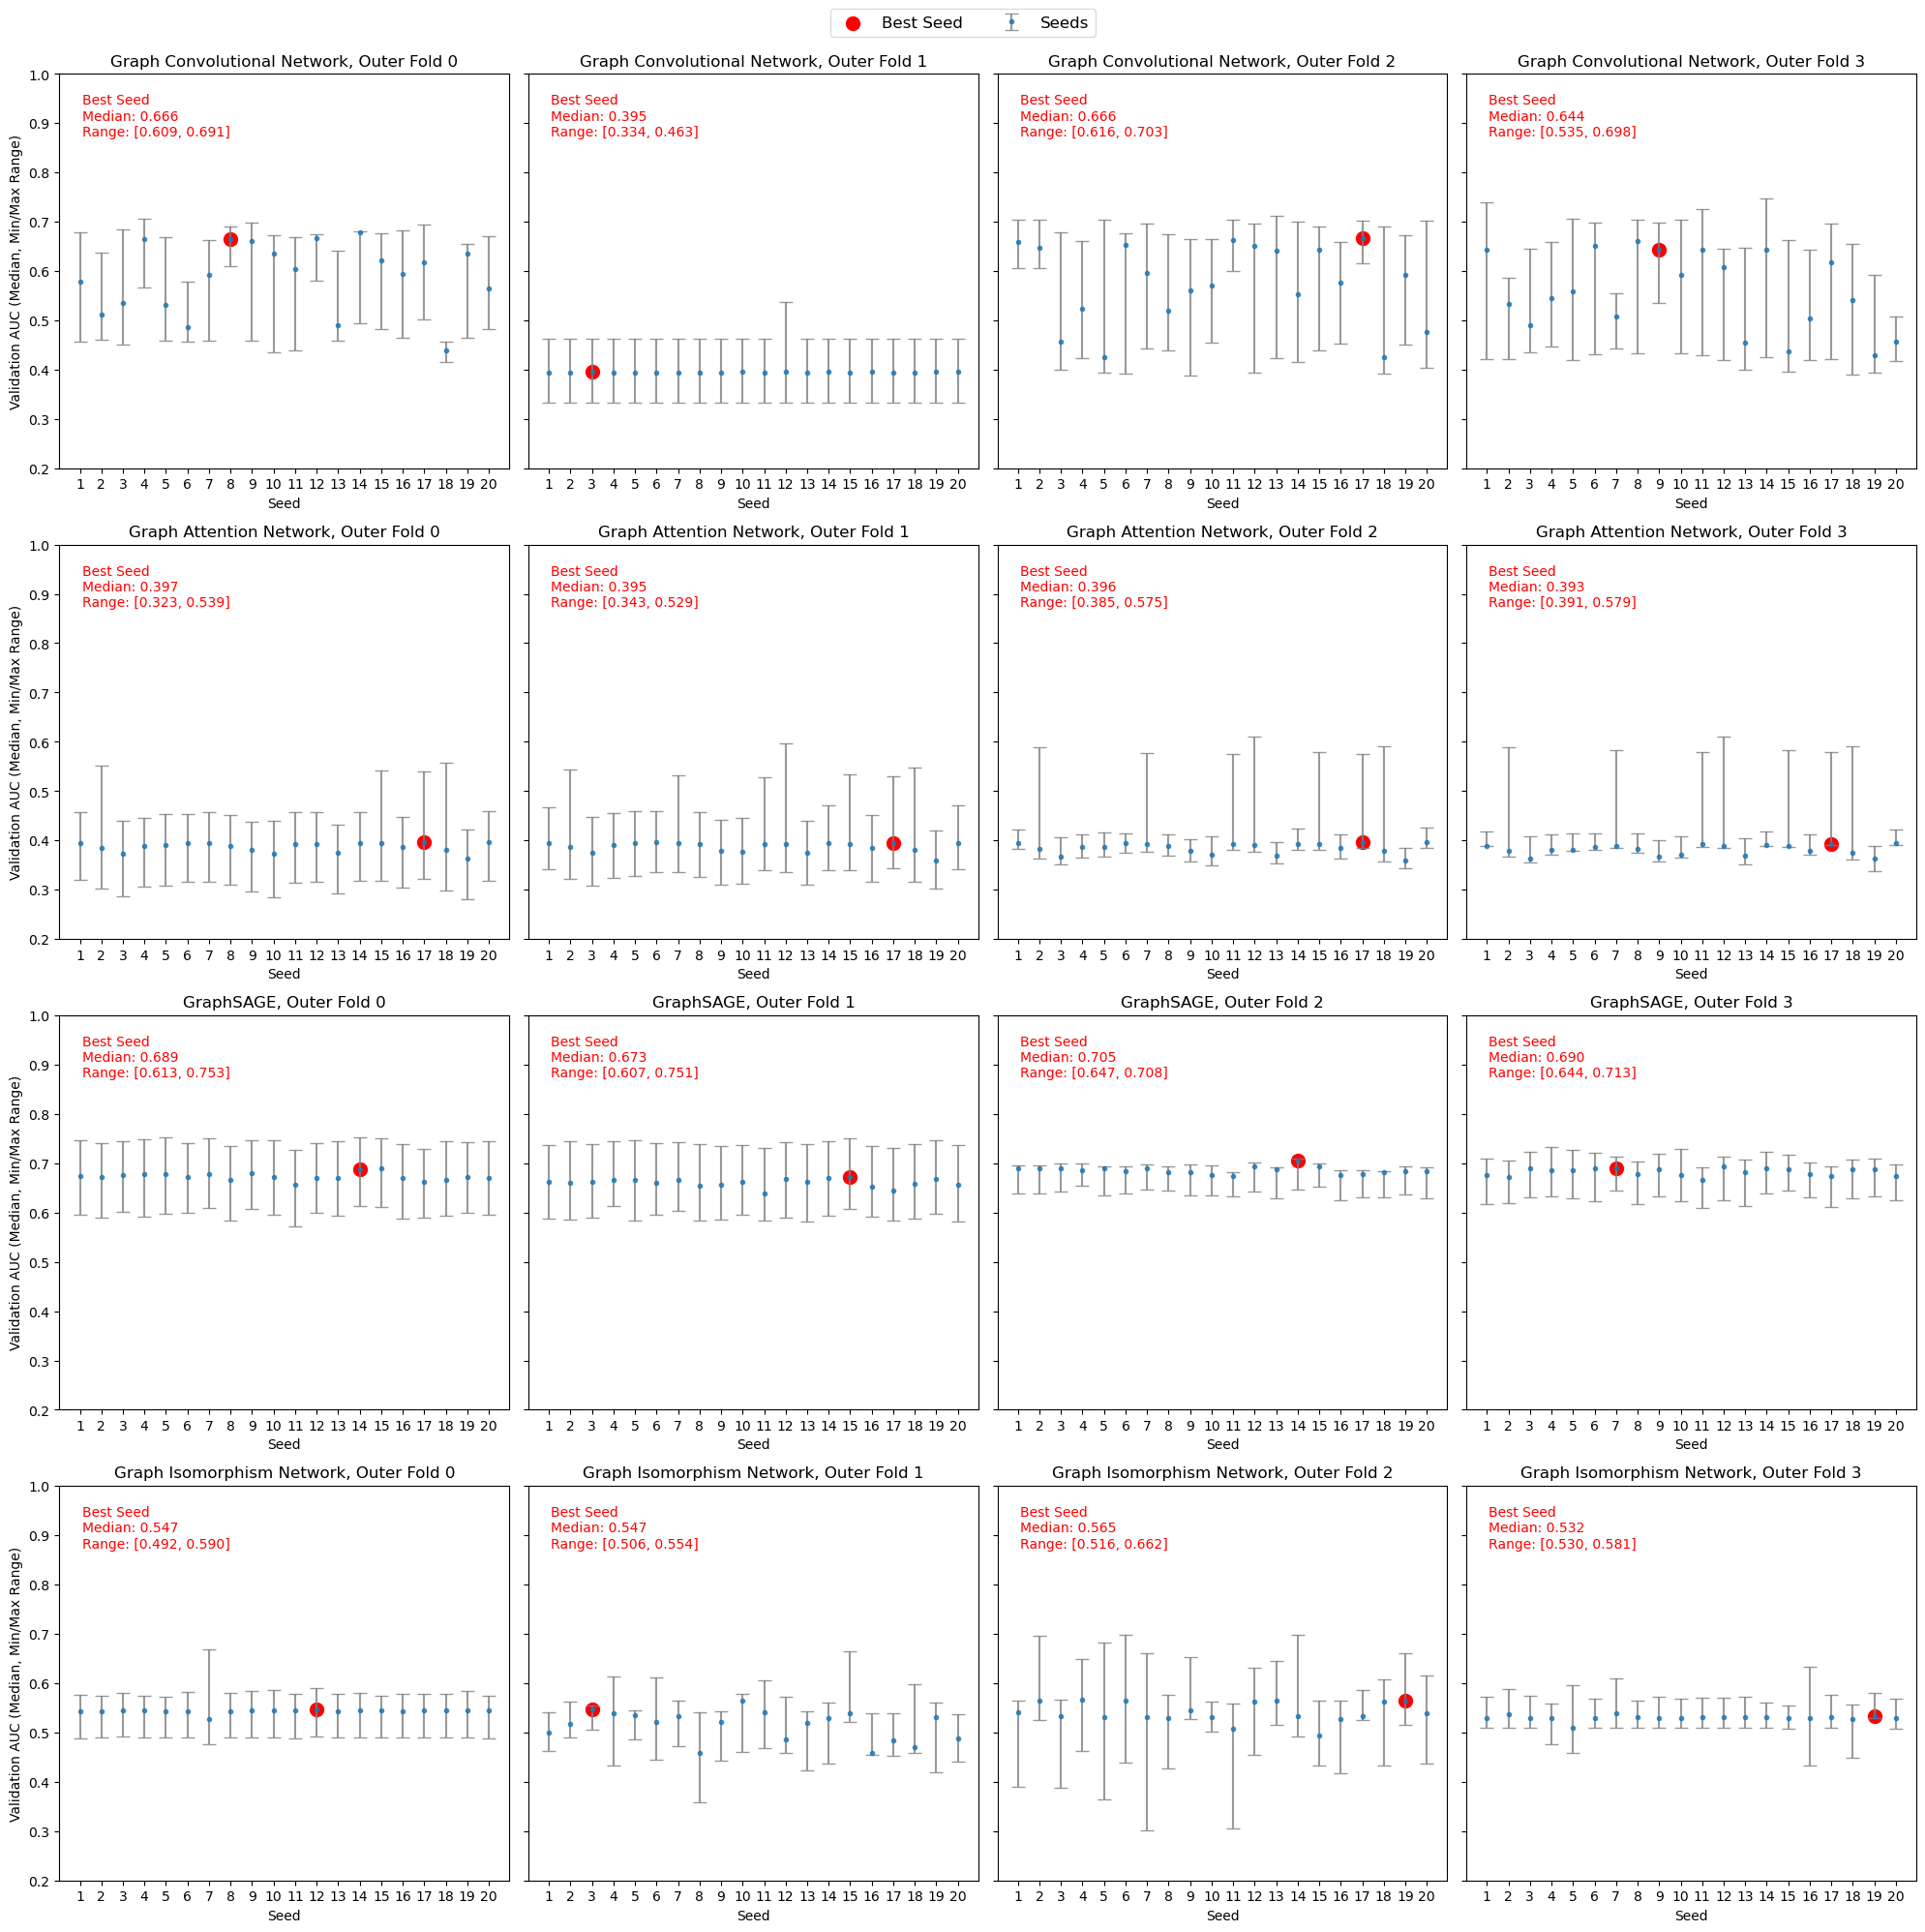

In [18]:
save_dir="results/grid_search/bbbp_min/initial_model_p20_20"
with open(os.path.join(save_dir, 'results_init.pkl'), 'rb') as f:
    results_init = pickle.load(f)
    
best_model_paths = select_best_models(results_init, save_dir)
plot_seed_performance(results_init, best_model_paths, save_dir = save_dir, ylim = (0.2, 1), prefix = 'BBBP_min')

{'GCN_Optimised': 1, 'GAT_Optimised': 2, 'GraphSAGE_Optimised': 8, 'GIN_Optimised': 1} 

For model GCN, mean val_auc of the last significant run across 20 inner folds: 0.491 ± 0.092
For model GAT, mean val_auc of the last significant run across 20 inner folds: 0.370 ± 0.044
For model GraphSAGE, mean val_auc of the last significant run across 20 inner folds: 0.854 ± 0.023
For model GIN, mean val_auc of the last significant run across 20 inner folds: 0.510 ± 0.079


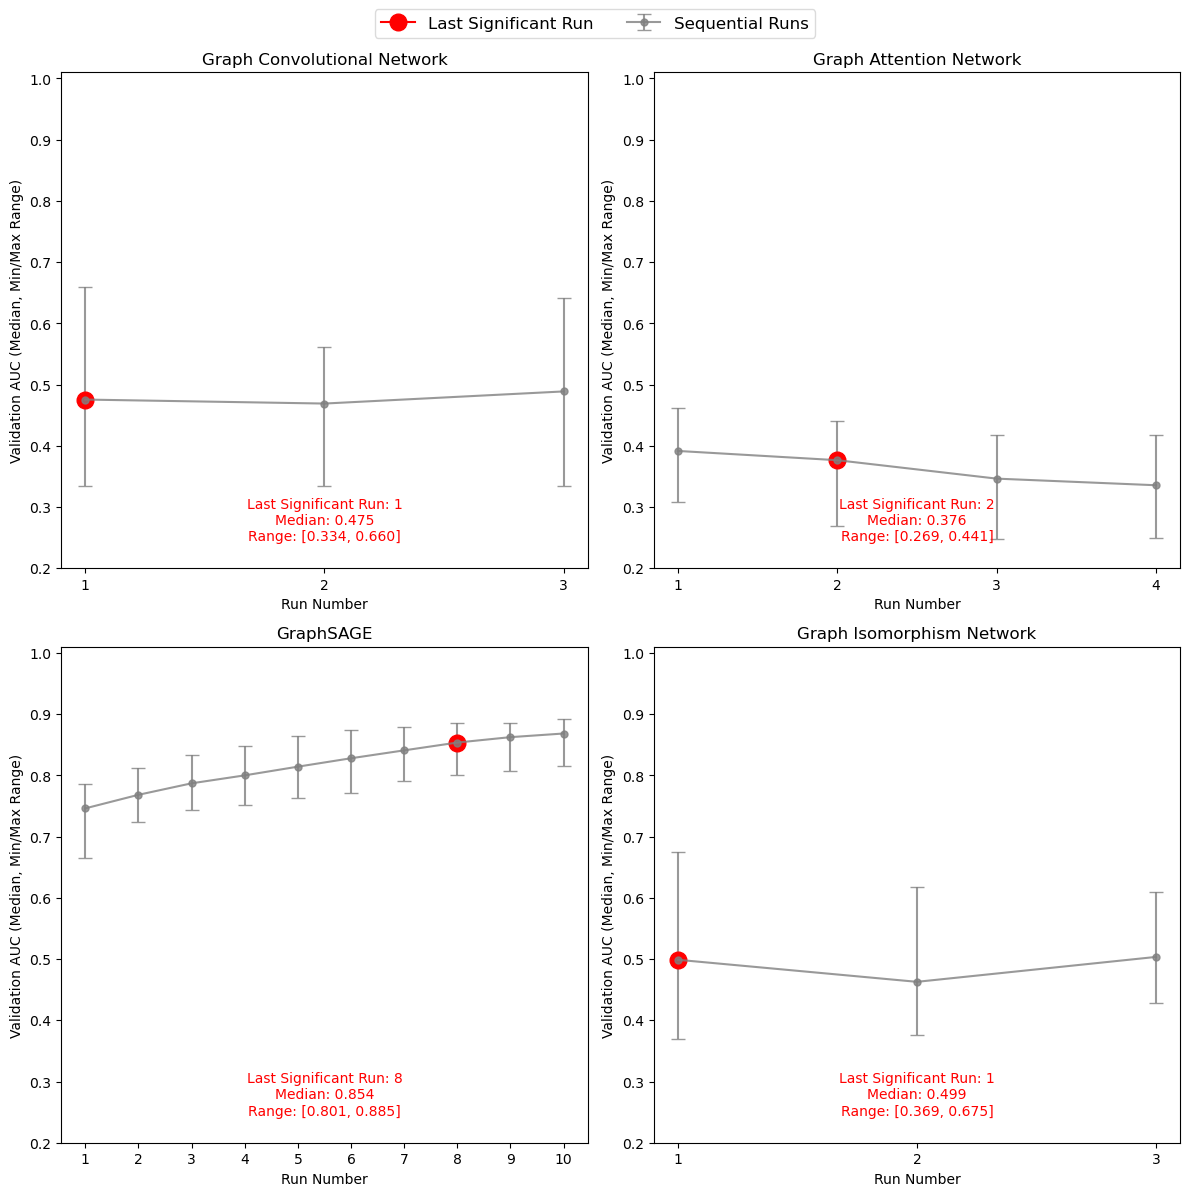

In [19]:
save_dir_ws = os.path.join(save_dir, 'warm_starts_p50')
with open(os.path.join(save_dir_ws, 'last_significant_run.pkl'), 'rb') as f:
   last_significant_run = pickle.load(f)
with open(os.path.join(save_dir_ws, 'results.pkl'), 'rb') as f:
    results = pickle.load(f)
print(last_significant_run,'\n')
plot_median_val_auc_with_error_bars(results, last_significant_run, save_dir = save_dir_ws, ylim = (0.2, 1.01), prefix = 'BBBP_min')

In [22]:
models = {
    'GCN_Optimised': GNNModel,
    'GAT_Optimised': GNNModel,
    'GraphSAGE_Optimised': GNNModel,
    'GIN_Optimised': GINModel
}

loaded_models = load_best_models(
    models=models,
    best_model_paths=best_model_paths,
    all_optimised_hyperparameters=grid_search_hyperparameters_ranking,
    pytorch_custom_dataset = bbbp_min
)

final_test_results = test_final_models_on_outer_cv(
    loaded_models=loaded_models, 
    all_optimised_hyperparameters=grid_search_hyperparameters_ranking, 
    pytorch_custom_dataset=bbbp_min,
    last_significant_run=last_significant_run,
    save_dir=save_dir_ws
)


Testing final GCN_Optimised model on outer CV test sets...
  Outer Fold 1/4
    Inner Fold 1/5
Loading model from results/grid_search/bbbp_min/initial_model_p20_20/warm_starts_p50/GCN_Optimised_outer0_inner0_run1.pt
Outer Fold 1, Inner Fold 1: Test AUC: 0.6458, Test Accuracy: 0.7703, Test F1: 0.8702, Test MCC: 0.0000
    Inner Fold 2/5
Loading model from results/grid_search/bbbp_min/initial_model_p20_20/warm_starts_p50/GCN_Optimised_outer0_inner1_run1.pt
Outer Fold 1, Inner Fold 2: Test AUC: 0.4951, Test Accuracy: 0.7703, Test F1: 0.8702, Test MCC: 0.0000
    Inner Fold 3/5
Loading model from results/grid_search/bbbp_min/initial_model_p20_20/warm_starts_p50/GCN_Optimised_outer0_inner2_run1.pt
Outer Fold 1, Inner Fold 3: Test AUC: 0.4904, Test Accuracy: 0.7703, Test F1: 0.8702, Test MCC: 0.0000
    Inner Fold 4/5
Loading model from results/grid_search/bbbp_min/initial_model_p20_20/warm_starts_p50/GCN_Optimised_outer0_inner3_run1.pt
Outer Fold 1, Inner Fold 4: Test AUC: 0.4203, Test Acc

##### Custom molecular graph

For model GCN, mean val_auc of optimal hyperparameters across 20 inner folds: 0.748 ± 0.026
For model GAT, mean val_auc of optimal hyperparameters across 20 inner folds: 0.744 ± 0.028
For model GraphSAGE, mean val_auc of optimal hyperparameters across 20 inner folds: 0.742 ± 0.028
For model GIN, mean val_auc of optimal hyperparameters across 20 inner folds: 0.738 ± 0.031


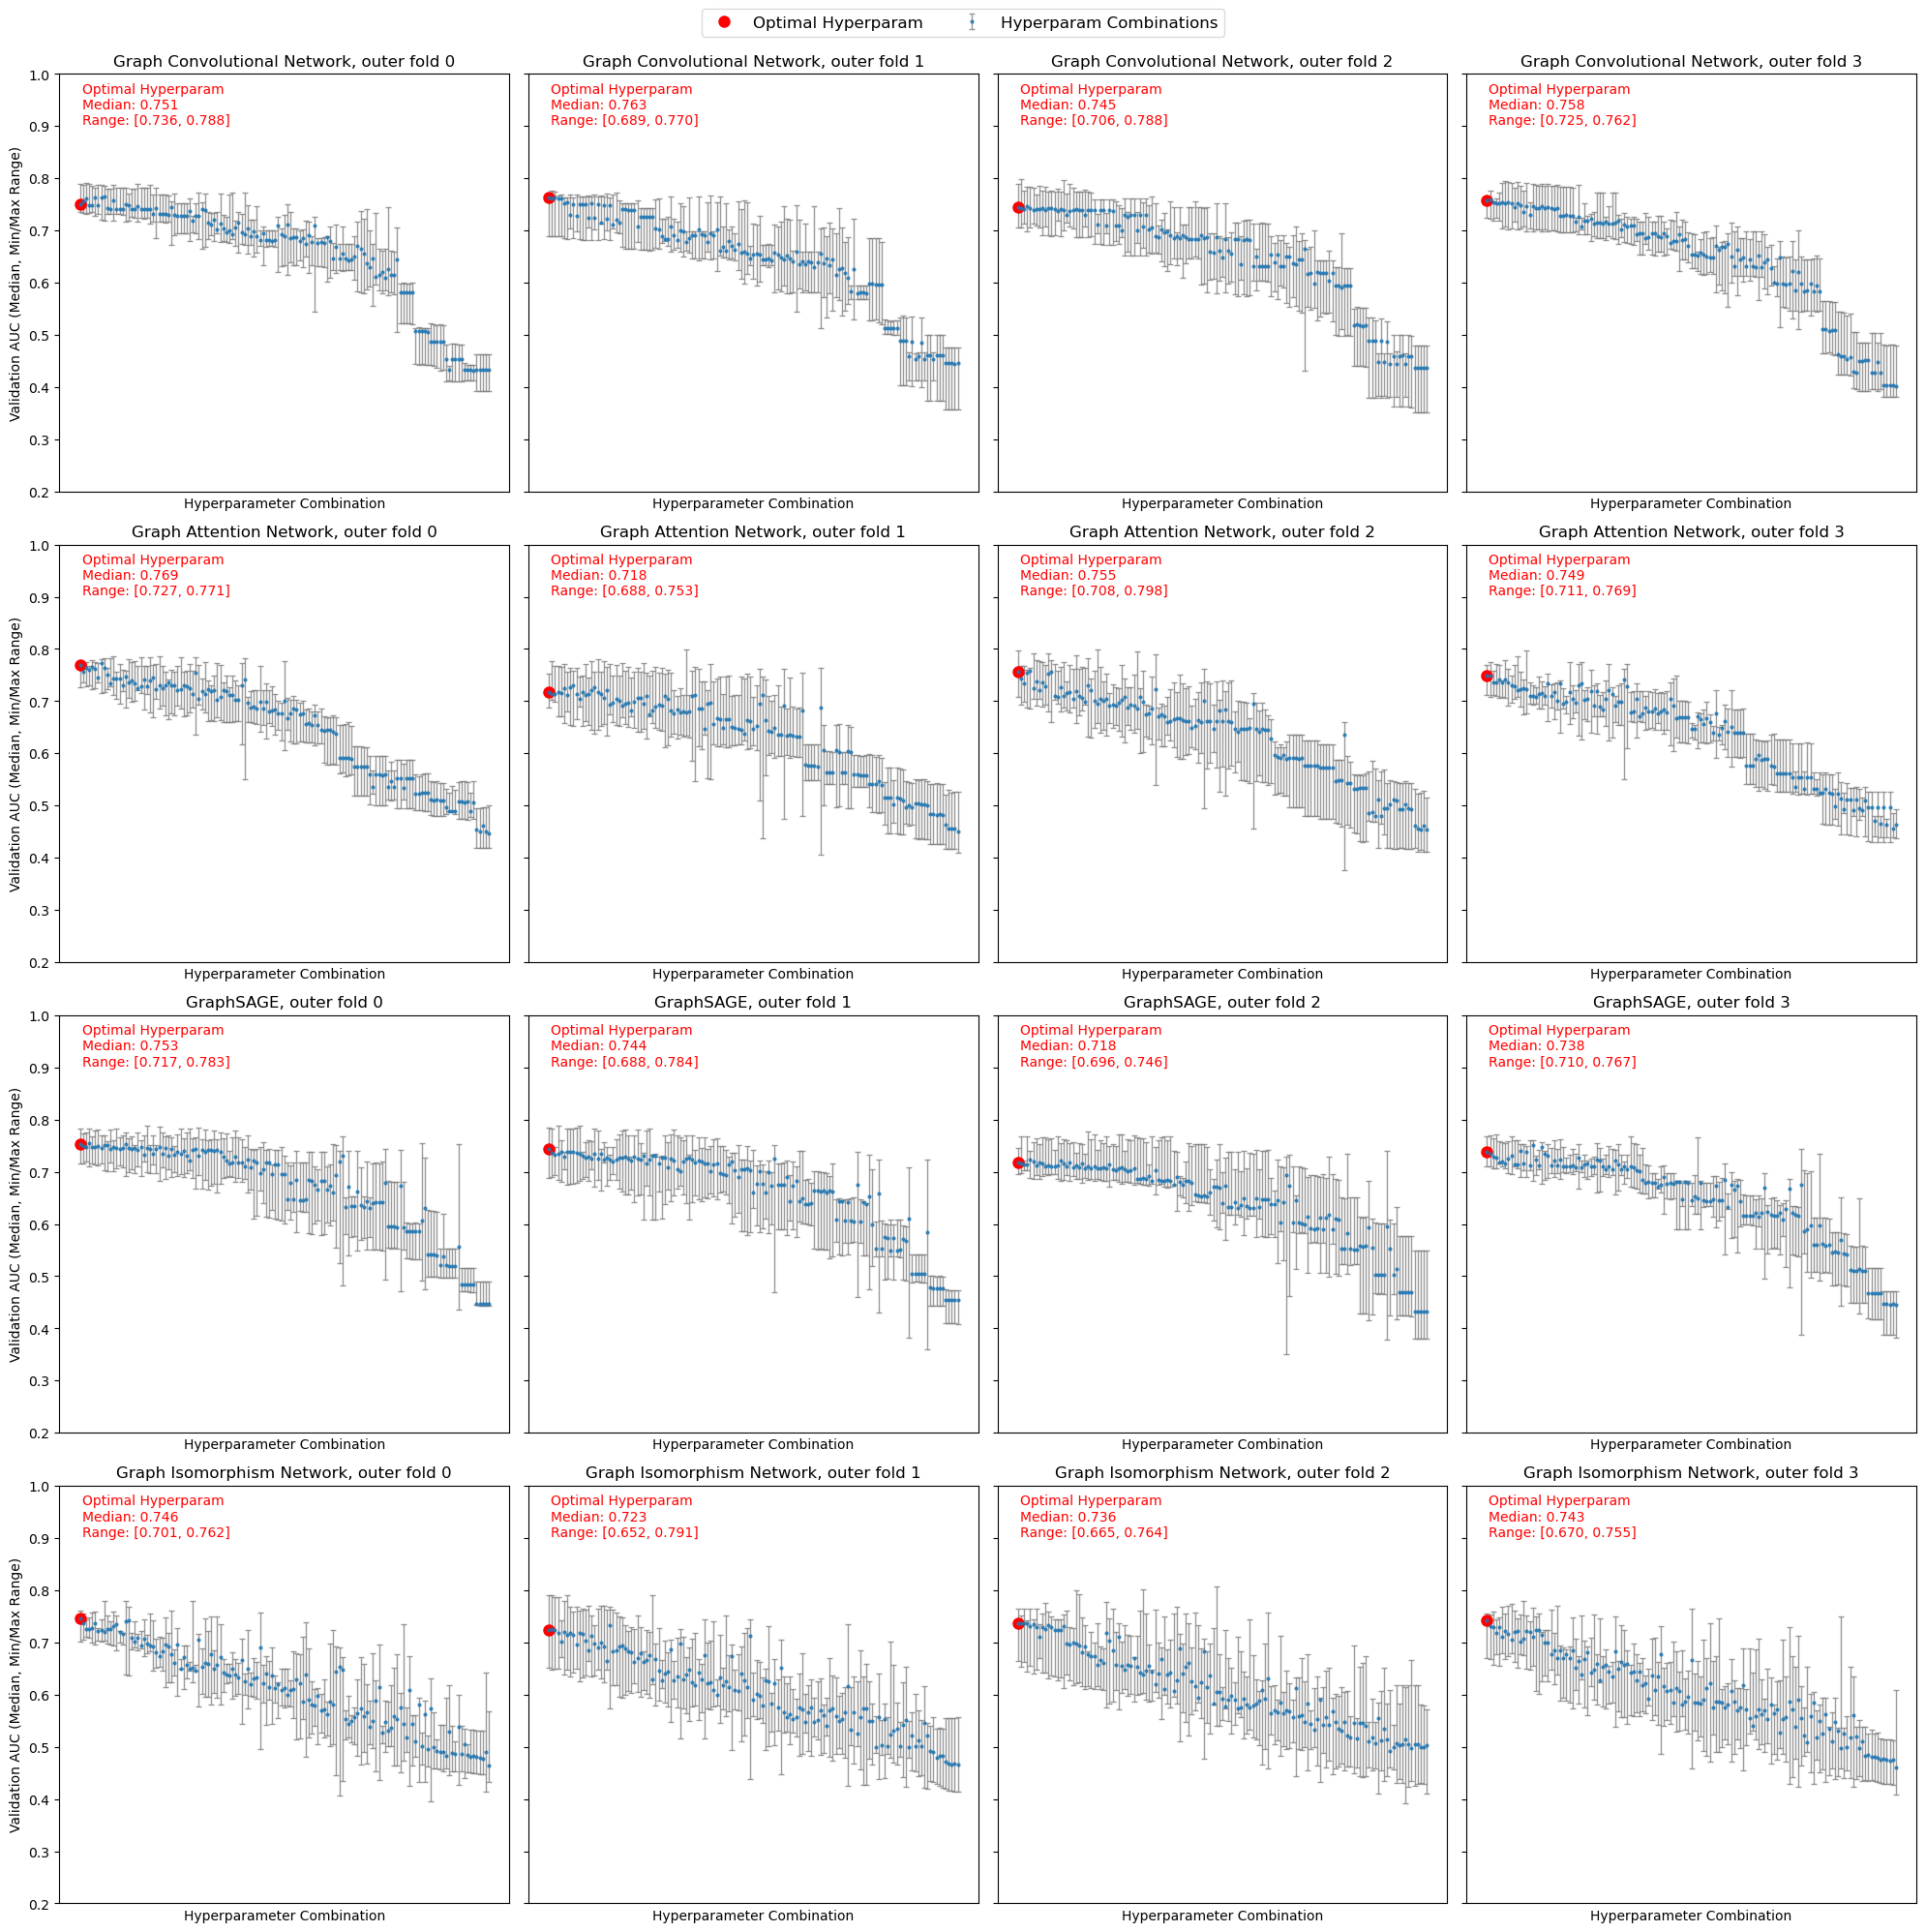

In [23]:
results_dir = 'results/grid_search/bbbp'
hyperparam_df = pd.read_csv(os.path.join(results_dir, 'grid_search_results.csv'))
grid_search_hyperparameters_ranking = plot_hyperparameter_performance_ranking(hyperparam_df, save_dir = results_dir, 
                                                                              ylim = (0.2, 1), prefix = 'BBBP')

For model GCN, mean val_auc of the best seed across 20 inner folds: 0.779 ± 0.027
For model GAT, mean val_auc of the best seed across 20 inner folds: 0.804 ± 0.040
For model GraphSAGE, mean val_auc of the best seed across 20 inner folds: 0.796 ± 0.040
For model GIN, mean val_auc of the best seed across 20 inner folds: 0.791 ± 0.039


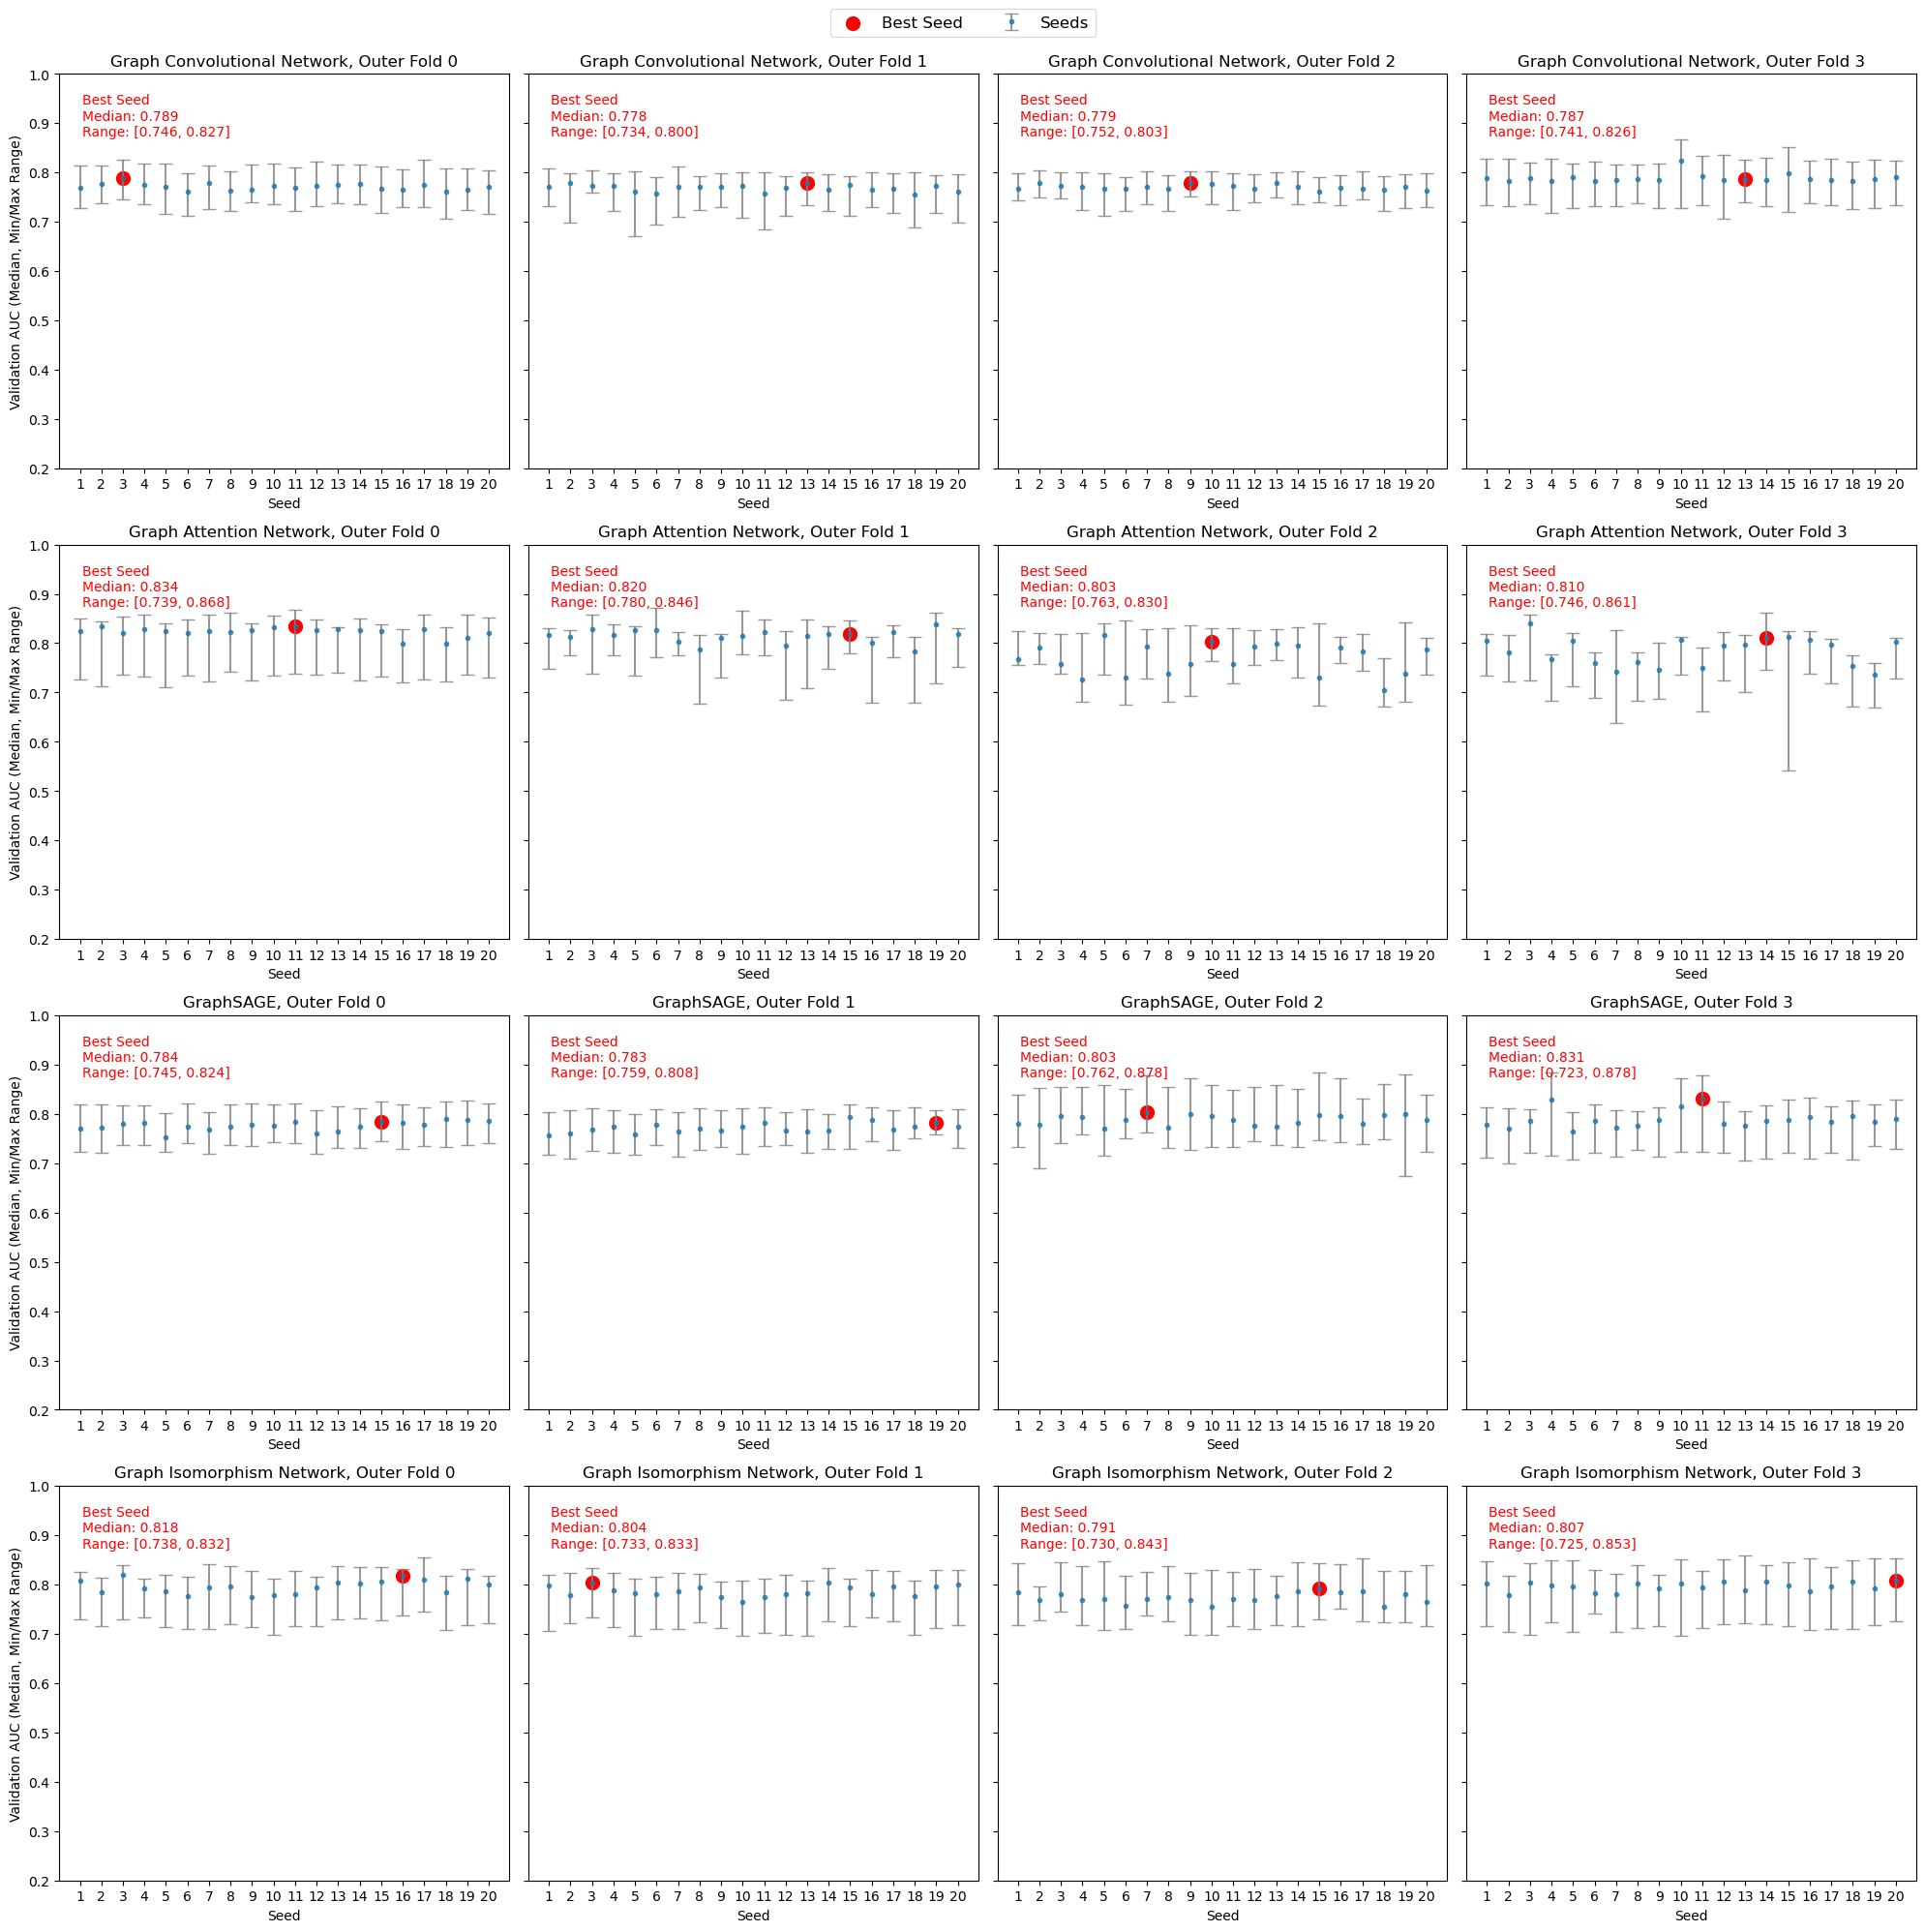

In [24]:
save_dir="results/grid_search/bbbp/initial_model_p20_20"
with open(os.path.join(save_dir, 'results_init.pkl'), 'rb') as f:
    results_init = pickle.load(f)
    
best_model_paths = select_best_models(results_init, save_dir)
plot_seed_performance(results_init, best_model_paths, save_dir = save_dir, ylim = (0.2, 1), prefix = 'BBBP')

{'GCN_Optimised': 10, 'GAT_Optimised': 4, 'GraphSAGE_Optimised': 6, 'GIN_Optimised': 7} 

For model GCN, mean val_auc of the last significant run across 20 inner folds: 0.987 ± 0.010
For model GAT, mean val_auc of the last significant run across 20 inner folds: 0.951 ± 0.030
For model GraphSAGE, mean val_auc of the last significant run across 20 inner folds: 0.998 ± 0.002
For model GIN, mean val_auc of the last significant run across 20 inner folds: 0.976 ± 0.021


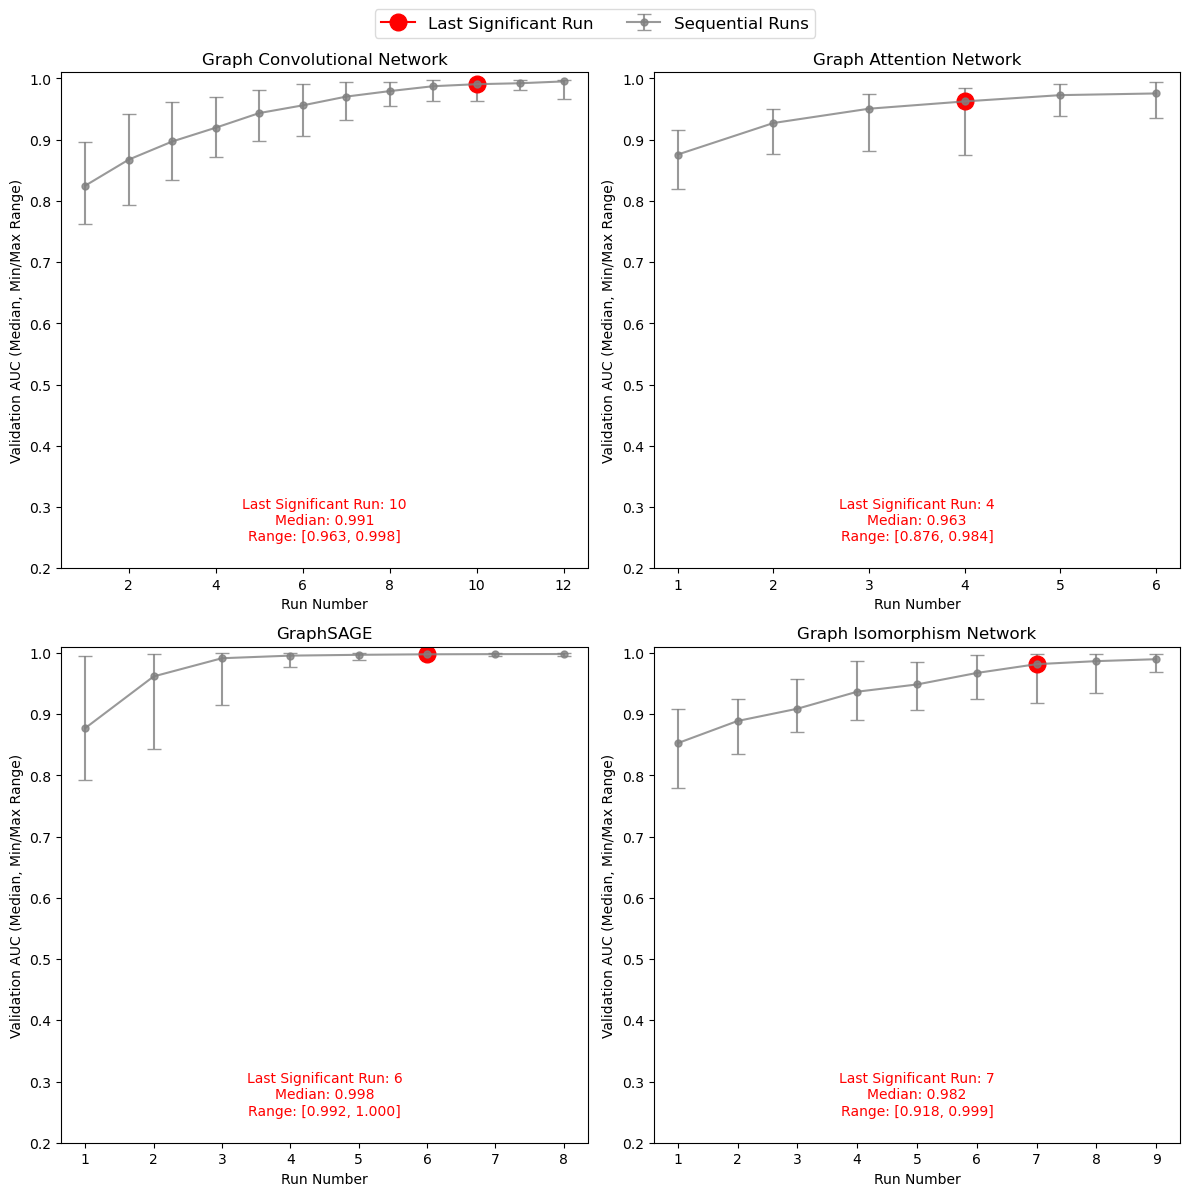

In [25]:
save_dir_ws = os.path.join(save_dir, 'warm_starts_p50')
with open(os.path.join(save_dir_ws, 'last_significant_run.pkl'), 'rb') as f:
   last_significant_run = pickle.load(f)
with open(os.path.join(save_dir_ws, 'results.pkl'), 'rb') as f:
    results = pickle.load(f)
print(last_significant_run,'\n')
plot_median_val_auc_with_error_bars(results, last_significant_run, save_dir = save_dir_ws, 
                                    ylim = (0.2, 1.01), prefix = 'BBBP')

In [26]:
models = {
    'GCN_Optimised': GNNModel,
    'GAT_Optimised': GNNModel,
    'GraphSAGE_Optimised': GNNModel,
    'GIN_Optimised': GINModel
}

loaded_models = load_best_models(
    models=models,
    best_model_paths=best_model_paths,
    all_optimised_hyperparameters=grid_search_hyperparameters_ranking,
    pytorch_custom_dataset = bbbp_cus_2_std
)

final_test_results = test_final_models_on_outer_cv(
    loaded_models=loaded_models, 
    all_optimised_hyperparameters=grid_search_hyperparameters_ranking, 
    pytorch_custom_dataset=bbbp_cus_2_std,
    last_significant_run=last_significant_run,
    save_dir=save_dir_ws
)


Testing final GCN_Optimised model on outer CV test sets...
  Outer Fold 1/4
    Inner Fold 1/5
Loading model from results/grid_search/bbbp/initial_model_p20_20/warm_starts_p50/GCN_Optimised_outer0_inner0_run10.pt
Outer Fold 1, Inner Fold 1: Test AUC: 0.9940, Test Accuracy: 0.9644, Test F1: 0.9770, Test MCC: 0.8983
    Inner Fold 2/5
Loading model from results/grid_search/bbbp/initial_model_p20_20/warm_starts_p50/GCN_Optimised_outer0_inner1_run10.pt
Outer Fold 1, Inner Fold 2: Test AUC: 0.9955, Test Accuracy: 0.9703, Test F1: 0.9807, Test MCC: 0.9158
    Inner Fold 3/5
Loading model from results/grid_search/bbbp/initial_model_p20_20/warm_starts_p50/GCN_Optimised_outer0_inner2_run10.pt
Outer Fold 1, Inner Fold 3: Test AUC: 0.9958, Test Accuracy: 0.9723, Test F1: 0.9820, Test MCC: 0.9222
    Inner Fold 4/5
Loading model from results/grid_search/bbbp/initial_model_p20_20/warm_starts_p50/GCN_Optimised_outer0_inner3_run10.pt
Outer Fold 1, Inner Fold 4: Test AUC: 0.9953, Test Accuracy: 0.976

### Beta-secretase enzyme activity (BACE)

In [31]:
# Generated from DILIGeNN Data Preprocessing.ipynb
df_bace_filtered_cleaned = pd.read_csv('chem_data/bace_standardised_cleaned.csv', index_col = 0)

bace_min = Graph_basic(dataframe = df_bace_filtered_cleaned,
                              smiles_col = 'smiles',
                             label_col = 'label',
                             root = 'custom_data/minimal_feature/bace_min'
                            )
bace_cus_2_std = Graph_custom(dataframe = df_bace_filtered_cleaned,
                              smiles_col = 'smiles_std',
                             label_col = 'label',
                             root = 'custom_data/bace/cus2_std/'
                            )


##### Basic molecular graph

For model GCN, mean val_auc of optimal hyperparameters across 20 inner folds: 0.533 ± 0.032
For model GAT, mean val_auc of optimal hyperparameters across 20 inner folds: 0.536 ± 0.045
For model GraphSAGE, mean val_auc of optimal hyperparameters across 20 inner folds: 0.547 ± 0.045
For model GIN, mean val_auc of optimal hyperparameters across 20 inner folds: 0.548 ± 0.042


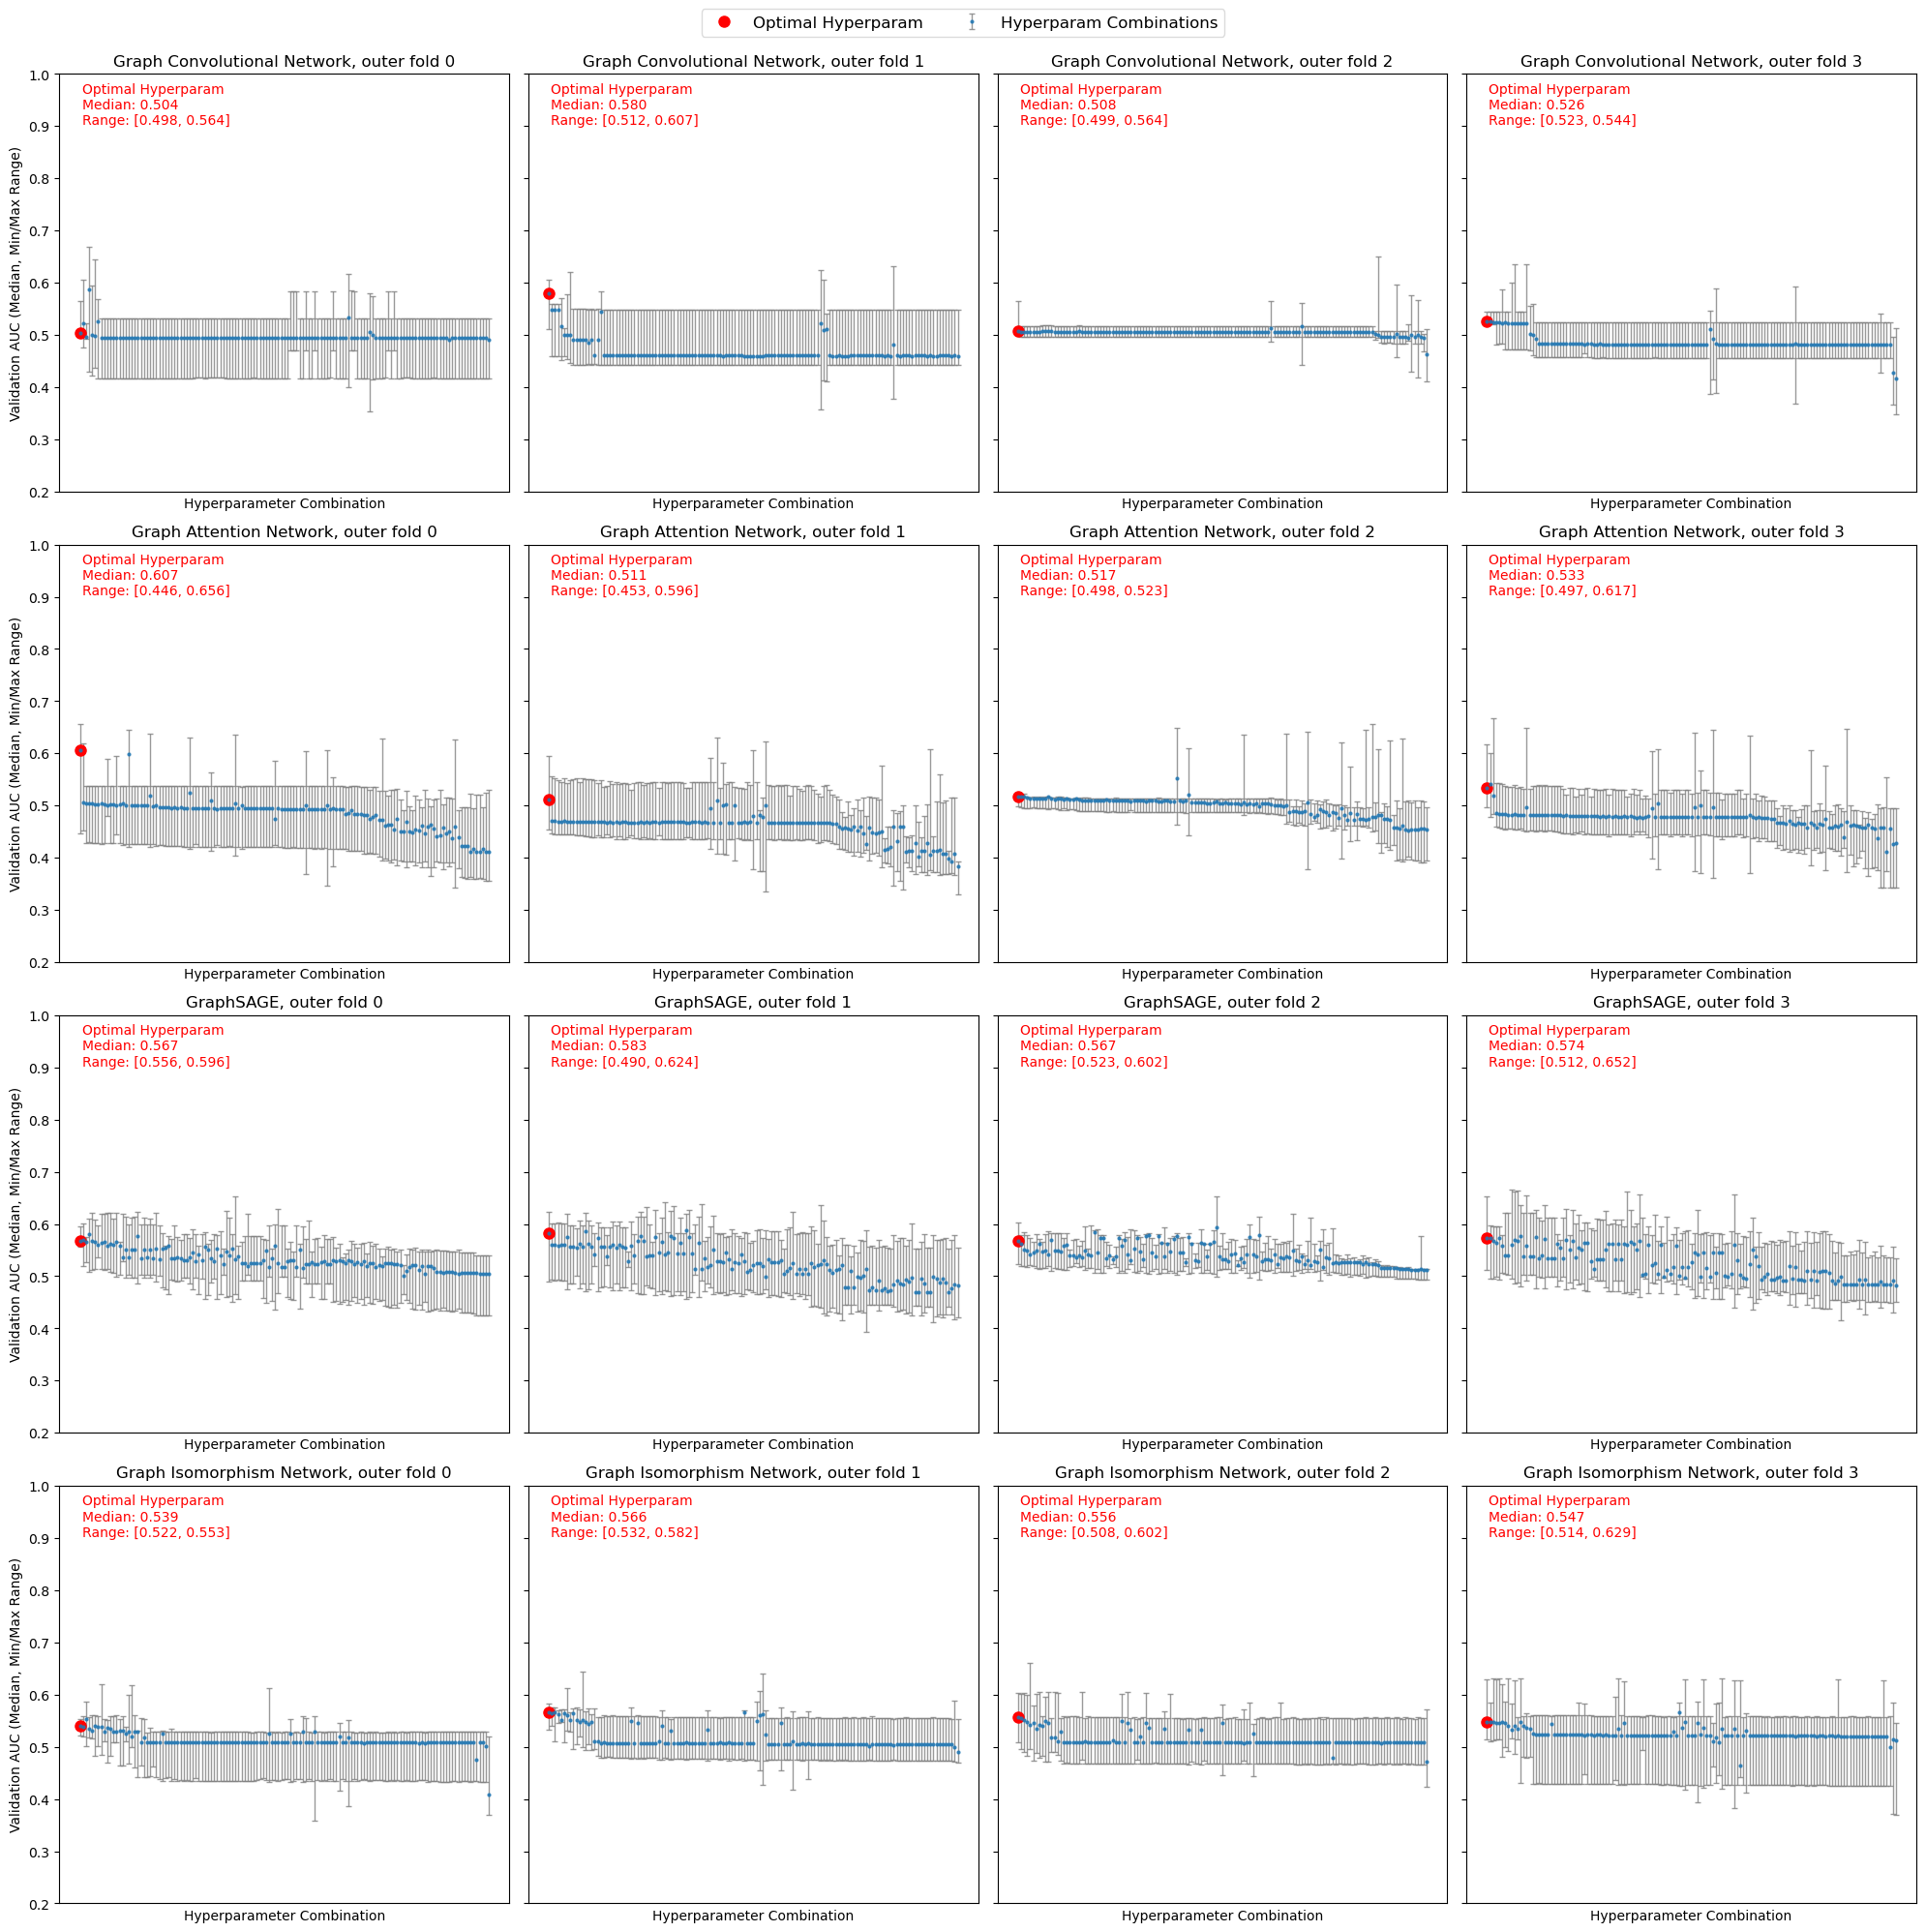

In [27]:
results_dir = 'results/grid_search/bace_min'
hyperparam_df = pd.read_csv(os.path.join(results_dir, 'grid_search_results.csv'))
grid_search_hyperparameters_ranking = plot_hyperparameter_performance_ranking(hyperparam_df, save_dir = results_dir, 
                                                                              ylim = (0.2, 1), prefix = 'BACE_min')

For model GCN, mean val_auc of the best seed across 20 inner folds: 0.528 ± 0.047
For model GAT, mean val_auc of the best seed across 20 inner folds: 0.582 ± 0.058
For model GraphSAGE, mean val_auc of the best seed across 20 inner folds: 0.597 ± 0.045
For model GIN, mean val_auc of the best seed across 20 inner folds: 0.516 ± 0.060


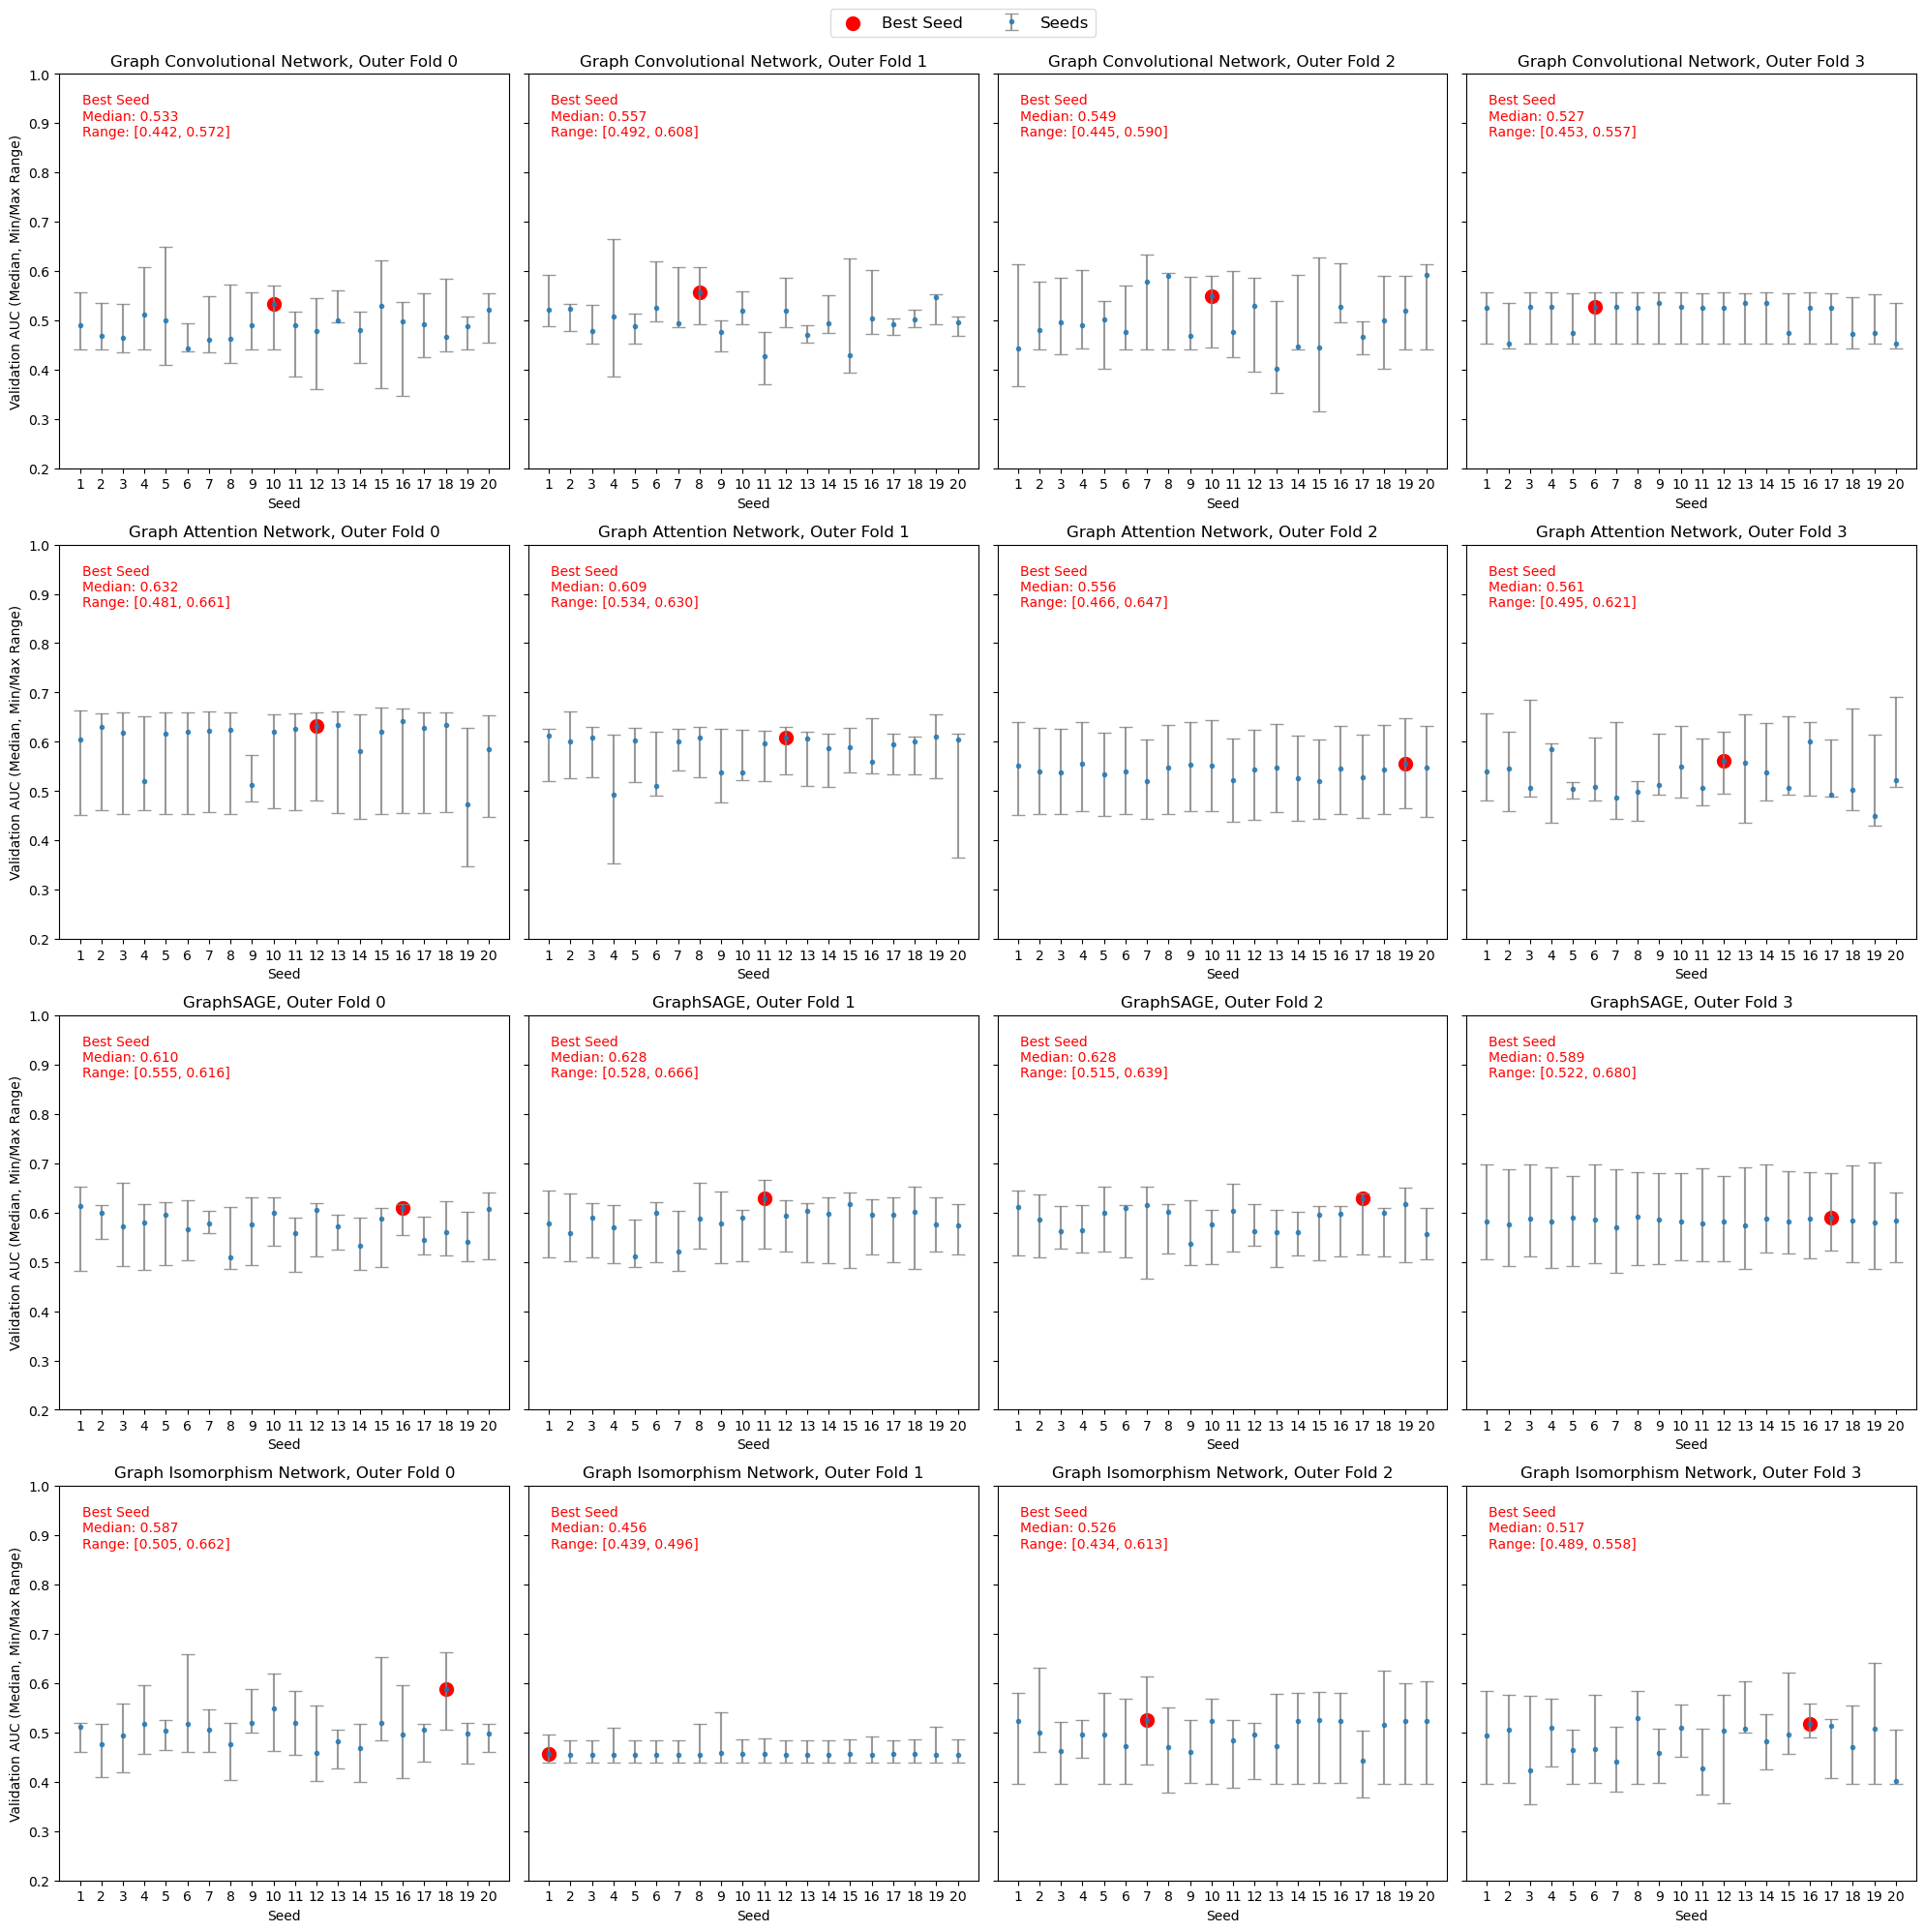

In [28]:
save_dir="results/grid_search/bace_min/initial_model_p20_20"
with open(os.path.join(save_dir, 'results_init.pkl'), 'rb') as f:
    results_init = pickle.load(f)
    
best_model_paths = select_best_models(results_init, save_dir)
plot_seed_performance(results_init, best_model_paths, save_dir = save_dir, ylim = (0.2, 1), prefix = 'BACE_min')

{'GCN_Optimised': 1, 'GAT_Optimised': 1, 'GraphSAGE_Optimised': 1, 'GIN_Optimised': 1} 

For model GCN, mean val_auc of the last significant run across 20 inner folds: 0.523 ± 0.063
For model GAT, mean val_auc of the last significant run across 20 inner folds: 0.537 ± 0.070
For model GraphSAGE, mean val_auc of the last significant run across 20 inner folds: 0.590 ± 0.049
For model GIN, mean val_auc of the last significant run across 20 inner folds: 0.518 ± 0.058


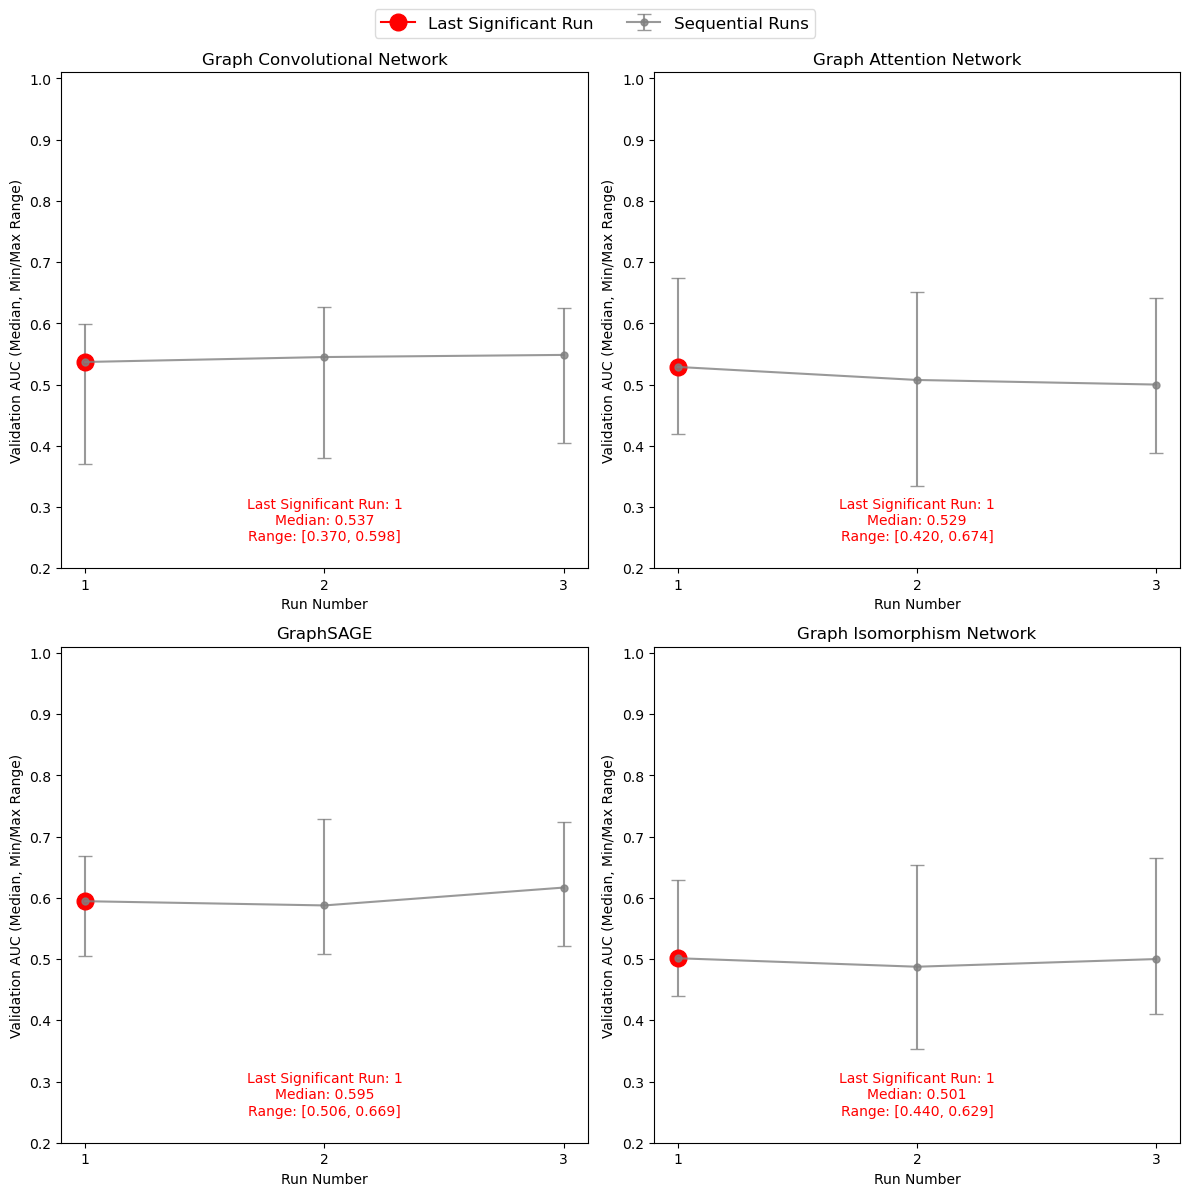

In [29]:
save_dir_ws = os.path.join(save_dir, 'warm_starts_p50')
with open(os.path.join(save_dir_ws, 'last_significant_run.pkl'), 'rb') as f:
   last_significant_run = pickle.load(f)
with open(os.path.join(save_dir_ws, 'results.pkl'), 'rb') as f:
    results = pickle.load(f)
print(last_significant_run,'\n')
plot_median_val_auc_with_error_bars(results, last_significant_run, save_dir = save_dir_ws, 
                                    ylim = (0.2, 1.01), prefix = 'BACE_min')

In [32]:
models = {
    'GCN_Optimised': GNNModel,
    'GAT_Optimised': GNNModel,
    'GraphSAGE_Optimised': GNNModel,
    'GIN_Optimised': GINModel
}

loaded_models = load_best_models(
    models=models,
    best_model_paths=best_model_paths,
    all_optimised_hyperparameters=grid_search_hyperparameters_ranking,
    pytorch_custom_dataset = bace_min
)

final_test_results = test_final_models_on_outer_cv(
    loaded_models=loaded_models, 
    all_optimised_hyperparameters=grid_search_hyperparameters_ranking, 
    pytorch_custom_dataset=bace_min,
    last_significant_run=last_significant_run,
    save_dir=save_dir_ws
)


Testing final GCN_Optimised model on outer CV test sets...
  Outer Fold 1/4
    Inner Fold 1/5
Loading model from results/grid_search/bace_min/initial_model_p20_20/warm_starts_p50/GCN_Optimised_outer0_inner0_run1.pt
Outer Fold 1, Inner Fold 1: Test AUC: 0.5137, Test Accuracy: 0.5435, Test F1: 0.0000, Test MCC: 0.0000
    Inner Fold 2/5
Loading model from results/grid_search/bace_min/initial_model_p20_20/warm_starts_p50/GCN_Optimised_outer0_inner1_run1.pt
Outer Fold 1, Inner Fold 2: Test AUC: 0.5083, Test Accuracy: 0.5435, Test F1: 0.0000, Test MCC: 0.0000
    Inner Fold 3/5
Loading model from results/grid_search/bace_min/initial_model_p20_20/warm_starts_p50/GCN_Optimised_outer0_inner2_run1.pt
Outer Fold 1, Inner Fold 3: Test AUC: 0.5304, Test Accuracy: 0.5435, Test F1: 0.0000, Test MCC: 0.0000
    Inner Fold 4/5
Loading model from results/grid_search/bace_min/initial_model_p20_20/warm_starts_p50/GCN_Optimised_outer0_inner3_run1.pt
Outer Fold 1, Inner Fold 4: Test AUC: 0.5289, Test Acc

##### Custom molecular graph

For model GCN, mean val_auc of optimal hyperparameters across 20 inner folds: 0.625 ± 0.030
For model GAT, mean val_auc of optimal hyperparameters across 20 inner folds: 0.634 ± 0.032
For model GraphSAGE, mean val_auc of optimal hyperparameters across 20 inner folds: 0.630 ± 0.032
For model GIN, mean val_auc of optimal hyperparameters across 20 inner folds: 0.632 ± 0.033


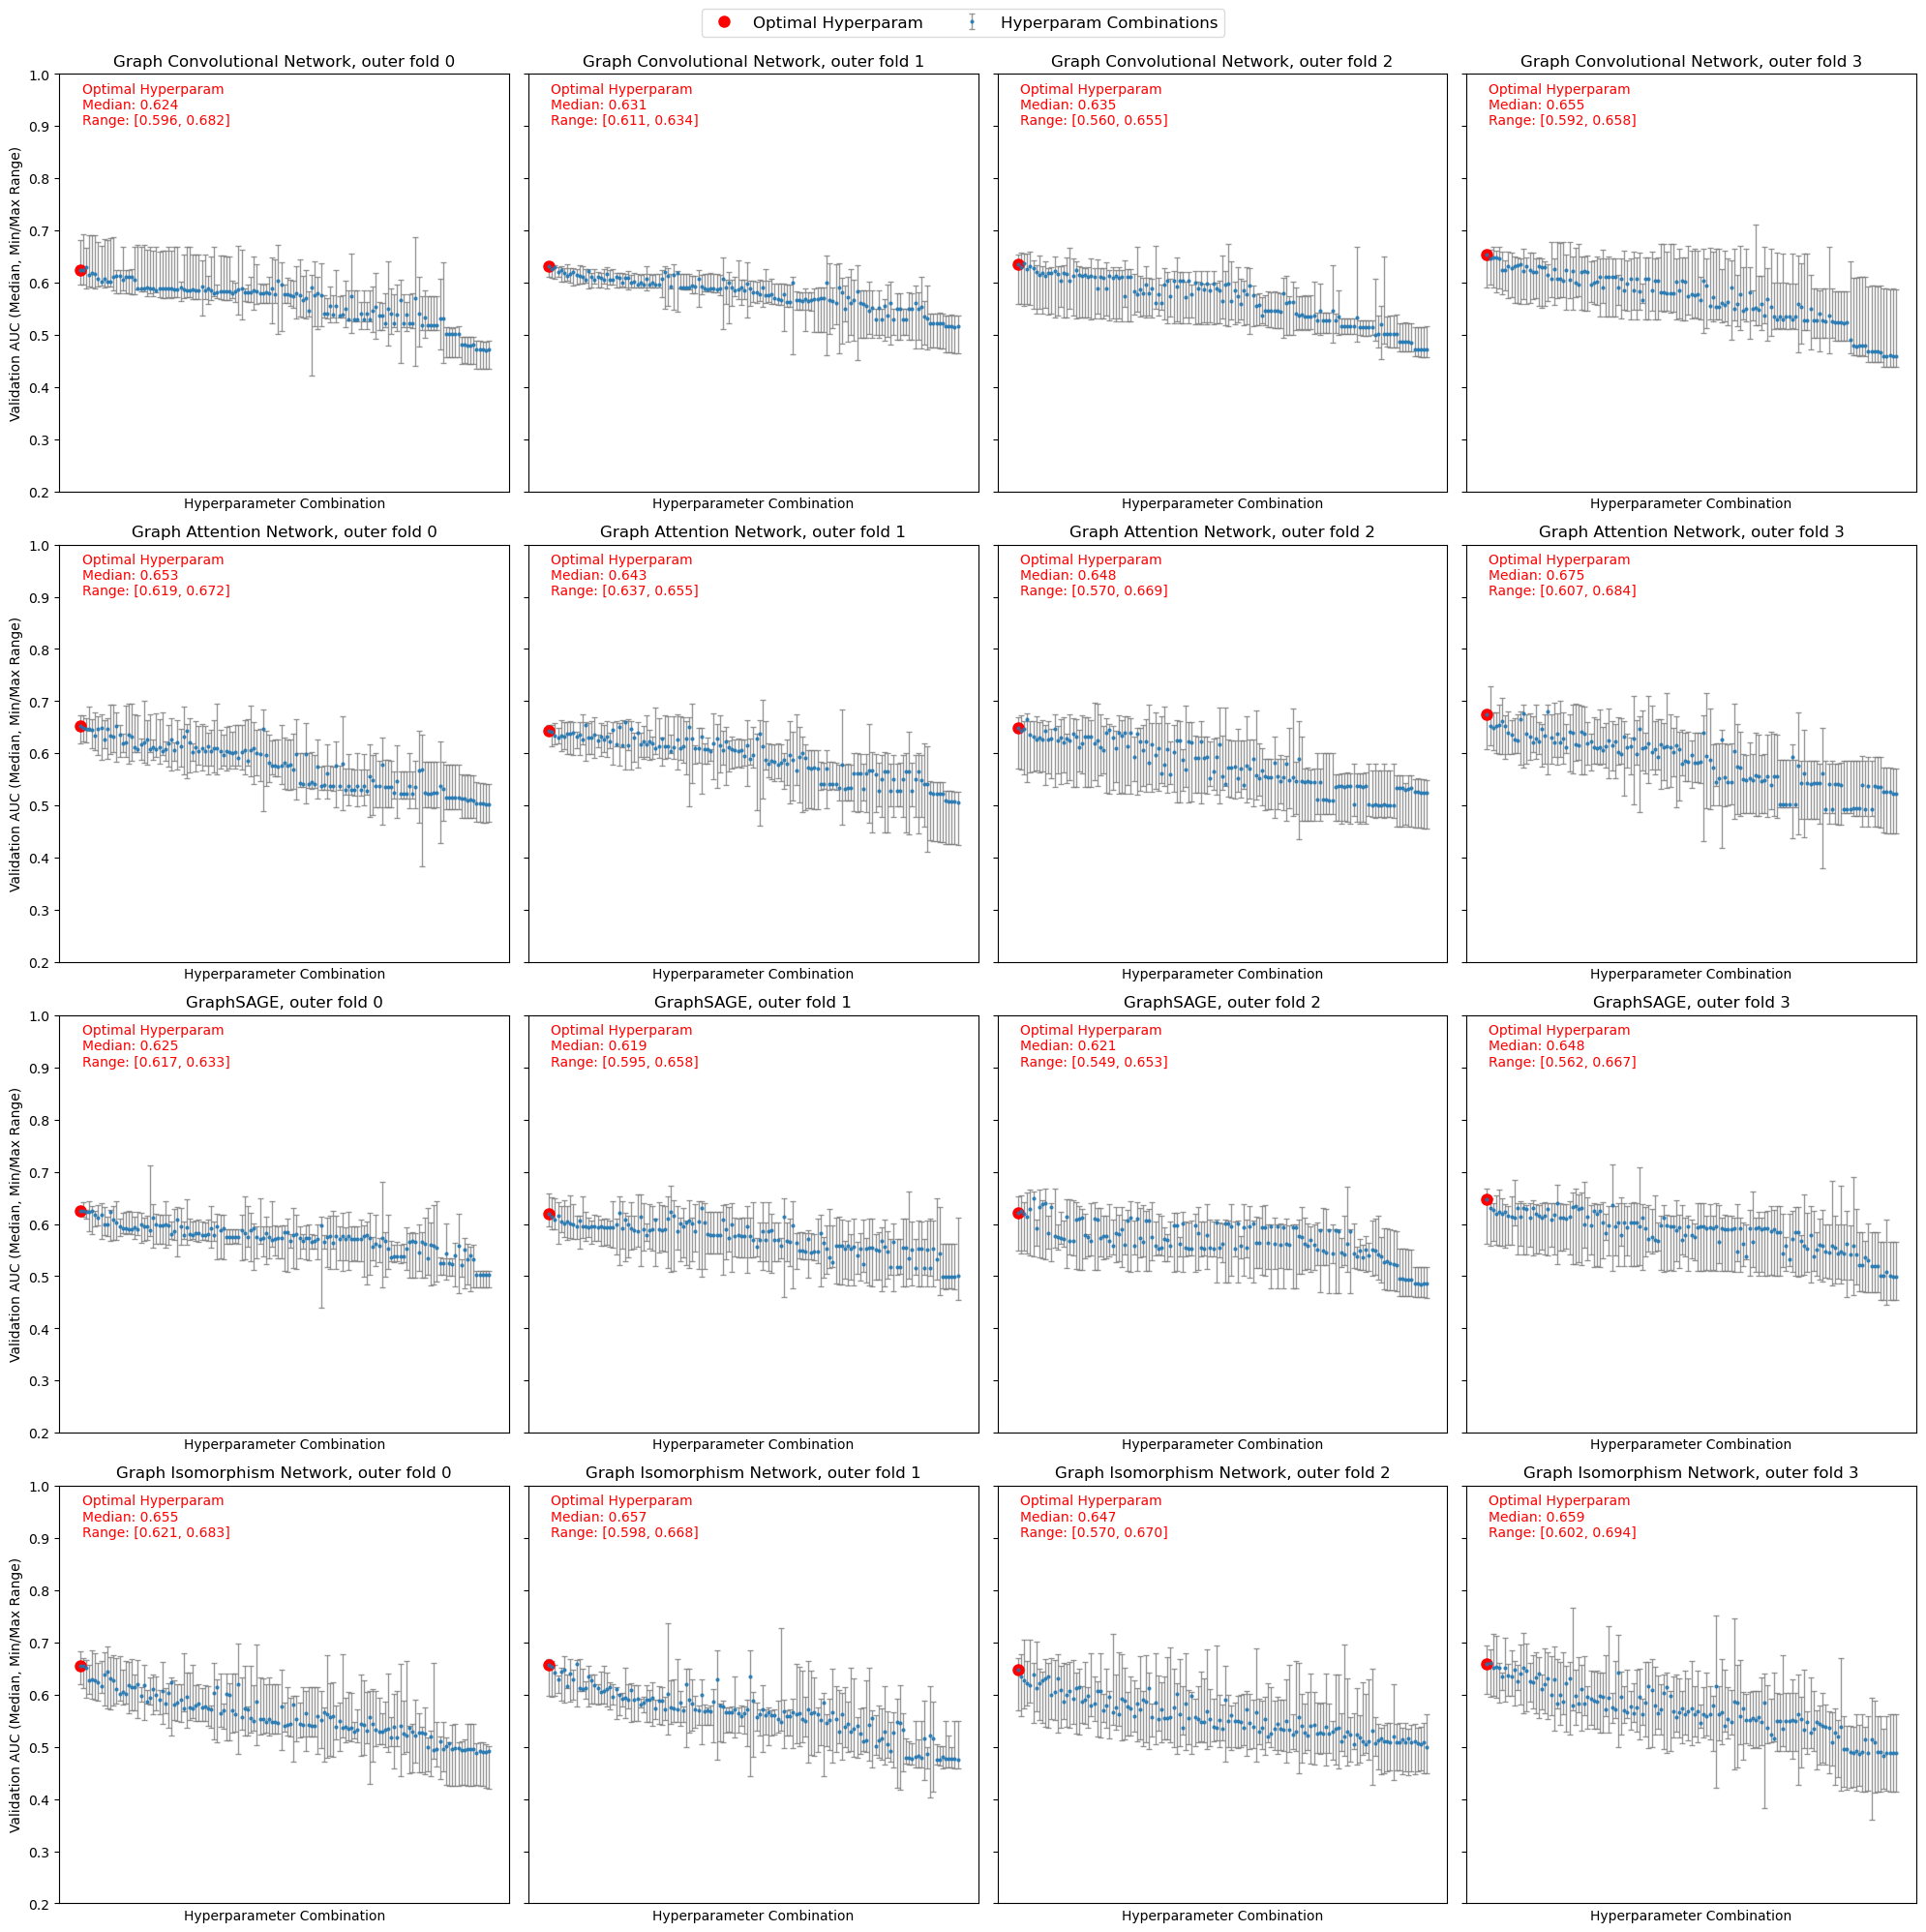

In [33]:
results_dir = 'results/grid_search/bace'
hyperparam_df = pd.read_csv(os.path.join(results_dir, 'grid_search_results.csv'))
grid_search_hyperparameters_ranking = plot_hyperparameter_performance_ranking(hyperparam_df, save_dir = results_dir,
                                                                             ylim = (0.2, 1), prefix = 'BACE')

For model GCN, mean val_auc of the best seed across 20 inner folds: 0.633 ± 0.048
For model GAT, mean val_auc of the best seed across 20 inner folds: 0.641 ± 0.064
For model GraphSAGE, mean val_auc of the best seed across 20 inner folds: 0.638 ± 0.062
For model GIN, mean val_auc of the best seed across 20 inner folds: 0.660 ± 0.071


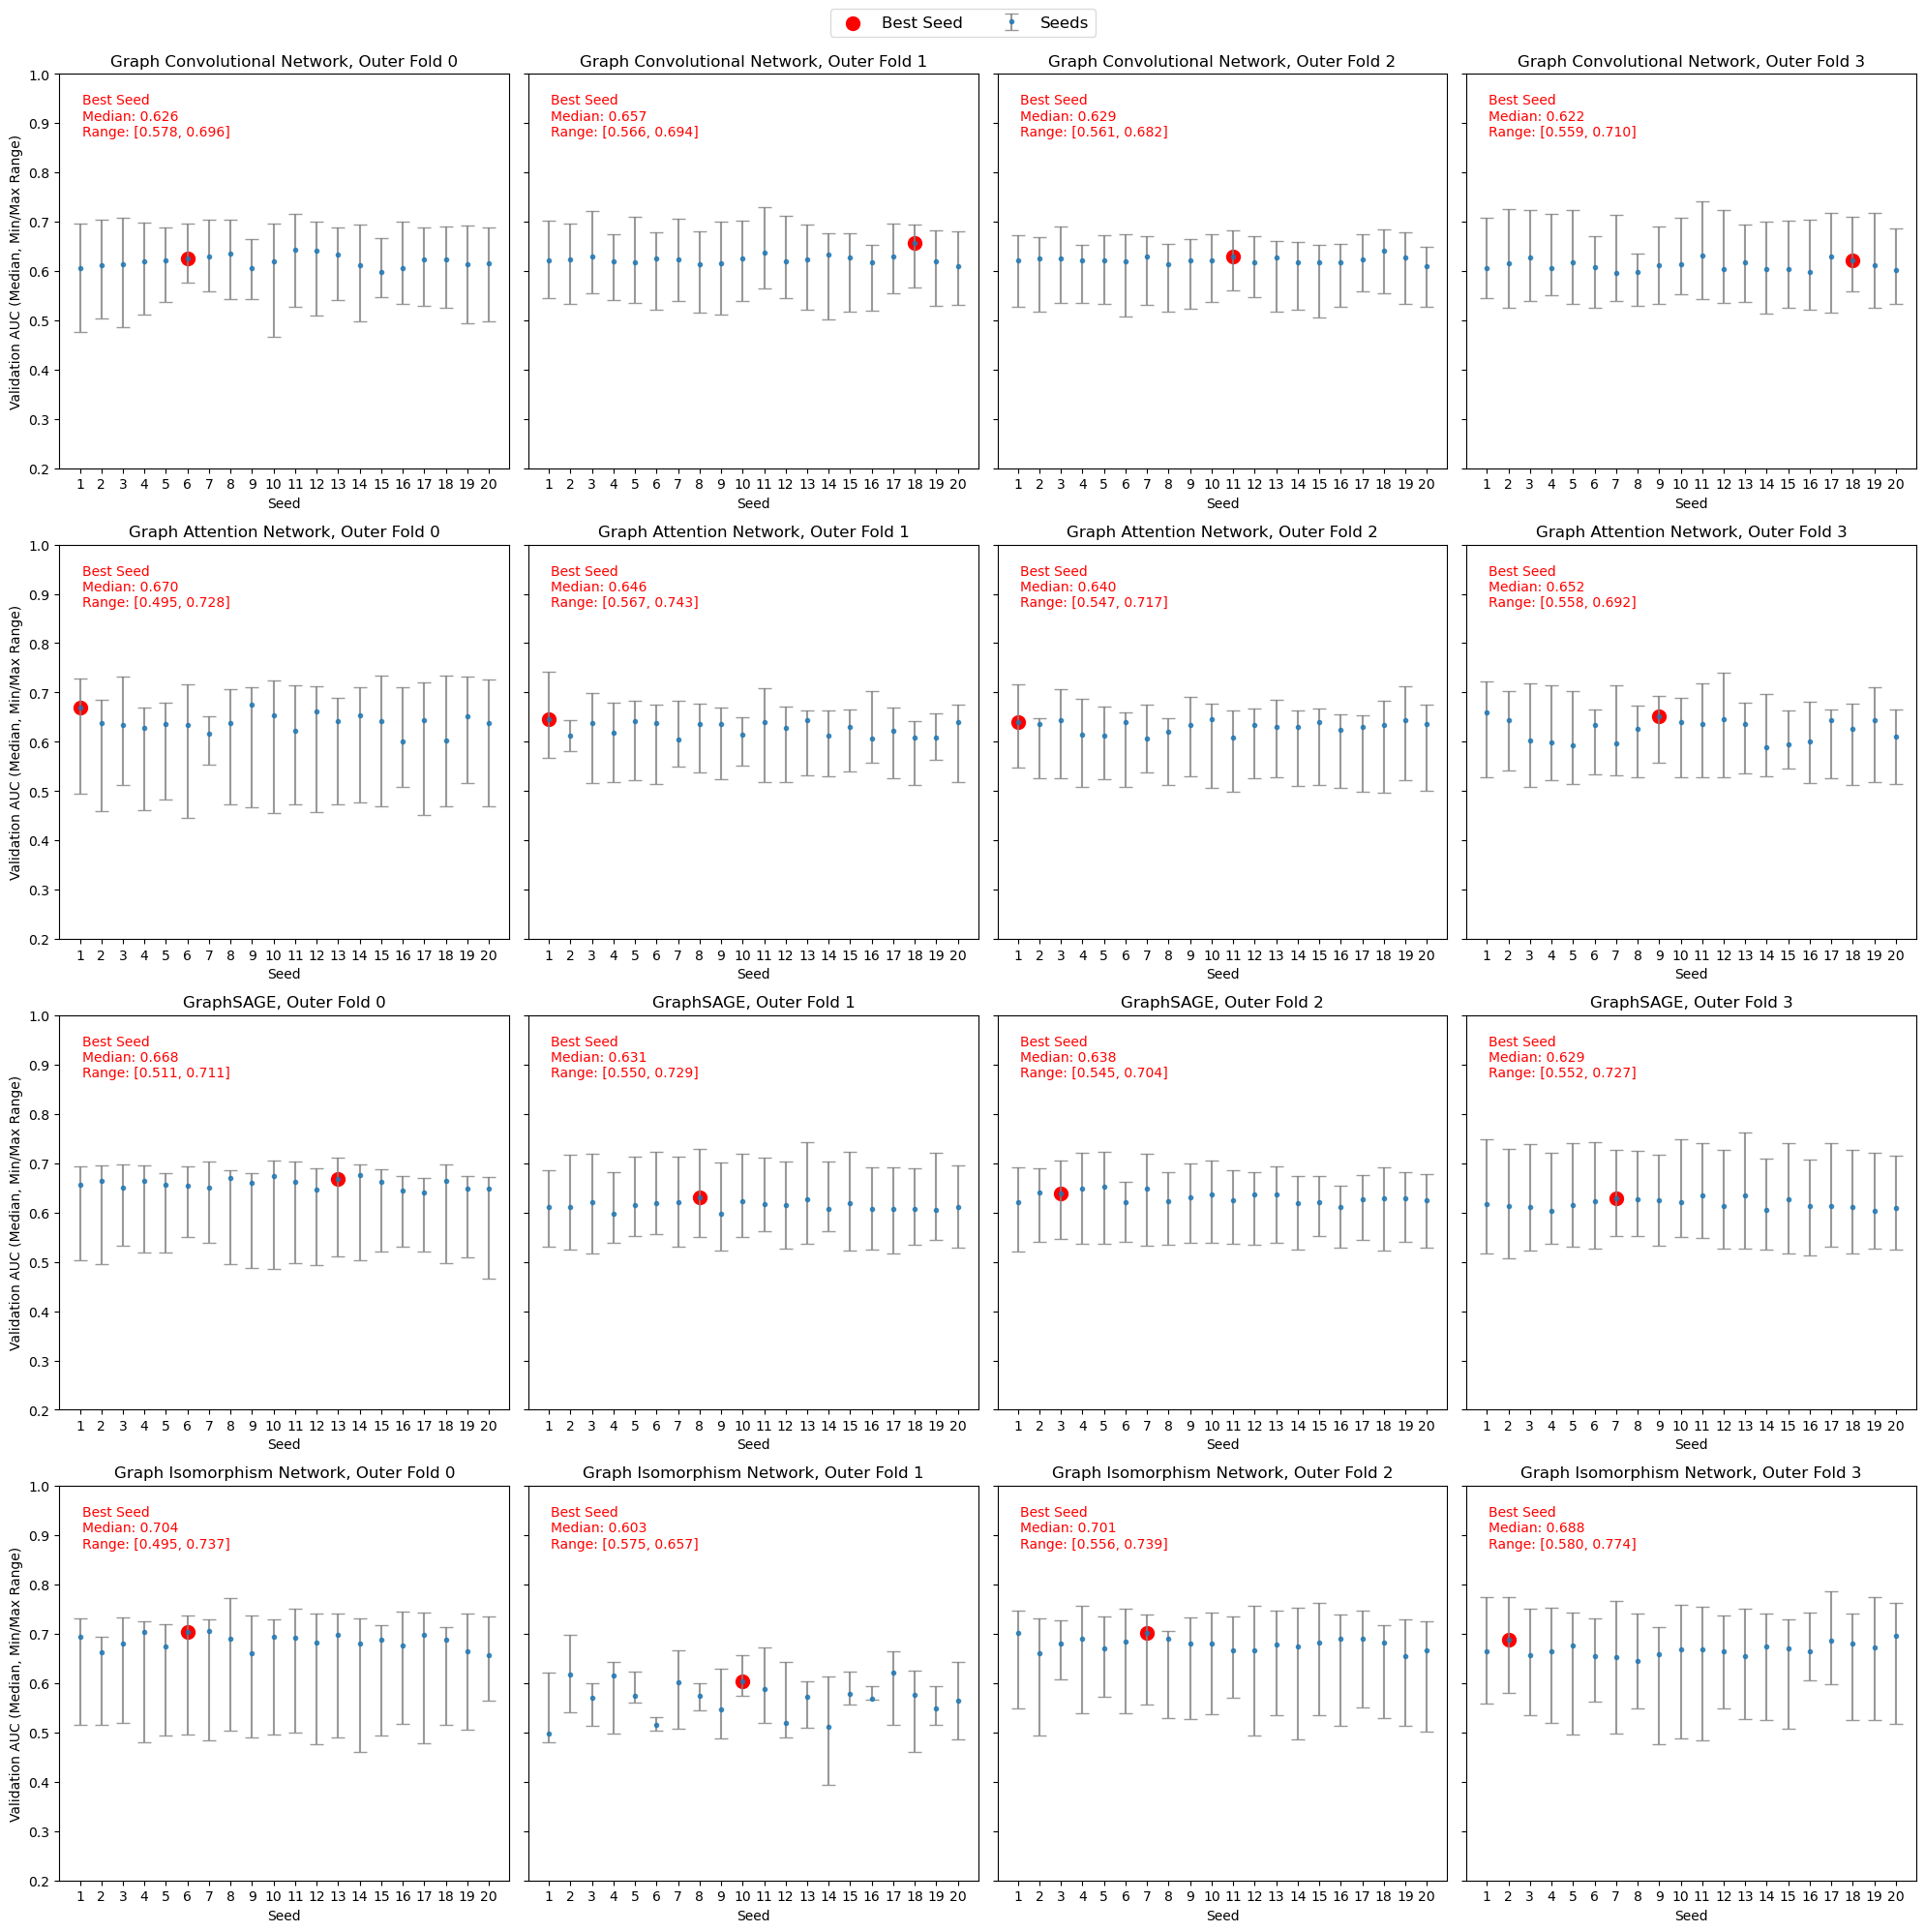

In [34]:
save_dir="results/grid_search/bace/initial_model_p20_20"
with open(os.path.join(save_dir, 'results_init.pkl'), 'rb') as f:
    results_init = pickle.load(f)
    
best_model_paths = select_best_models(results_init, save_dir)
plot_seed_performance(results_init, best_model_paths, save_dir = save_dir, ylim = (0.2, 1), prefix = 'BACE')

{'GCN_Optimised': 8, 'GAT_Optimised': 3, 'GraphSAGE_Optimised': 7, 'GIN_Optimised': 1} 

For model GCN, mean val_auc of the last significant run across 20 inner folds: 0.897 ± 0.055
For model GAT, mean val_auc of the last significant run across 20 inner folds: 0.807 ± 0.070
For model GraphSAGE, mean val_auc of the last significant run across 20 inner folds: 0.964 ± 0.020
For model GIN, mean val_auc of the last significant run across 20 inner folds: 0.622 ± 0.080


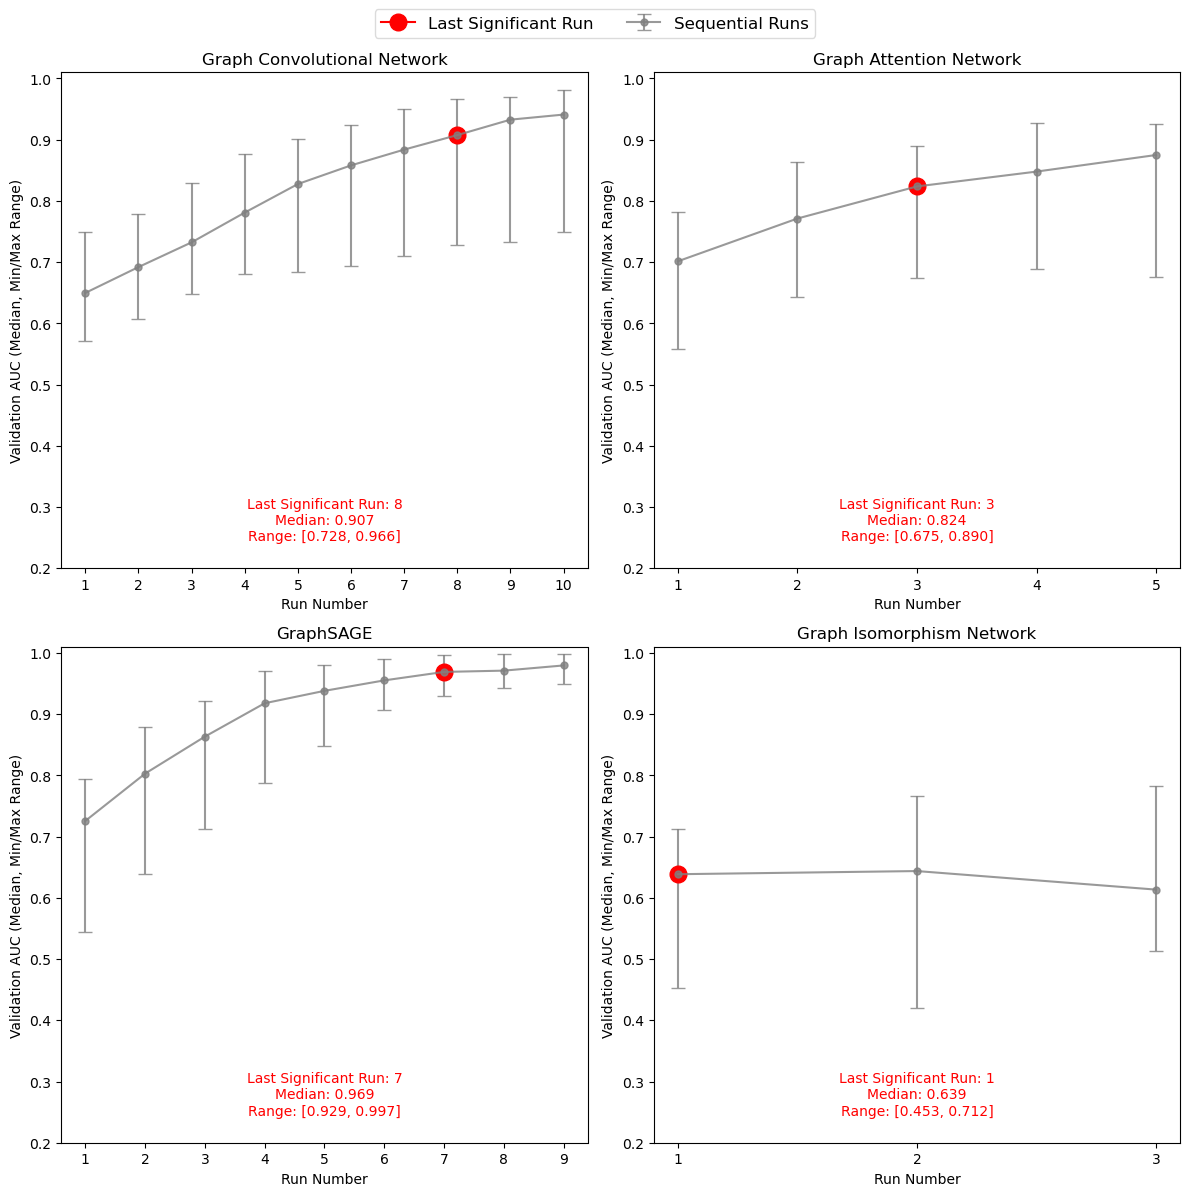

In [35]:
save_dir_ws = os.path.join(save_dir, 'warm_starts_p50')
with open(os.path.join(save_dir_ws, 'last_significant_run.pkl'), 'rb') as f:
   last_significant_run = pickle.load(f)
with open(os.path.join(save_dir_ws, 'results.pkl'), 'rb') as f:
    results = pickle.load(f)
print(last_significant_run,'\n')
plot_median_val_auc_with_error_bars(results, last_significant_run, save_dir = save_dir_ws, 
                                    ylim = (0.2, 1.01), prefix = 'BACE')

In [36]:
models = {
    'GCN_Optimised': GNNModel,
    'GAT_Optimised': GNNModel,
    'GraphSAGE_Optimised': GNNModel,
    'GIN_Optimised': GINModel
}

loaded_models = load_best_models(
    models=models,
    best_model_paths=best_model_paths,
    all_optimised_hyperparameters=grid_search_hyperparameters_ranking,
    pytorch_custom_dataset = bace_cus_2_std
)

final_test_results = test_final_models_on_outer_cv(
    loaded_models=loaded_models, 
    all_optimised_hyperparameters=grid_search_hyperparameters_ranking, 
    pytorch_custom_dataset=bace_cus_2_std,
    last_significant_run=last_significant_run,
    save_dir=save_dir_ws
)


Testing final GCN_Optimised model on outer CV test sets...
  Outer Fold 1/4
    Inner Fold 1/5
Loading model from results/grid_search/bace/initial_model_p20_20/warm_starts_p50/GCN_Optimised_outer0_inner0_run8.pt
Outer Fold 1, Inner Fold 1: Test AUC: 0.8122, Test Accuracy: 0.7467, Test F1: 0.7225, Test MCC: 0.4895
    Inner Fold 2/5
Loading model from results/grid_search/bace/initial_model_p20_20/warm_starts_p50/GCN_Optimised_outer0_inner1_run8.pt
Outer Fold 1, Inner Fold 2: Test AUC: 0.8100, Test Accuracy: 0.7467, Test F1: 0.7241, Test MCC: 0.4900
    Inner Fold 3/5
Loading model from results/grid_search/bace/initial_model_p20_20/warm_starts_p50/GCN_Optimised_outer0_inner2_run8.pt
Outer Fold 1, Inner Fold 3: Test AUC: 0.8257, Test Accuracy: 0.7599, Test F1: 0.7267, Test MCC: 0.5144
    Inner Fold 4/5
Loading model from results/grid_search/bace/initial_model_p20_20/warm_starts_p50/GCN_Optimised_outer0_inner3_run8.pt
Outer Fold 1, Inner Fold 4: Test AUC: 0.8259, Test Accuracy: 0.7573, T

### ClinTox

In [5]:
### Binary classification -> Multi-label classification
### Therefore, loss function changes from Binary Crossentropy (BCELogitLoss) -> CrossEntropy

import ast

class Graph_custom(InMemoryDataset):
    def __init__(self, dataframe, root, smiles_col='smiles', label_col='label', test=False, transform=None, pre_transform=None):
        self.test = test
        self.dataframe = dataframe
        self.smiles_col = smiles_col
        self.label_col = label_col
        self._data = None
        self.error_indices = []
        super(Graph_custom, self).__init__(root, transform, pre_transform)
        
    @property
    def raw_file_names(self):
        """
        (The download func. is not implemented here)  
        """
        return 'dataframe'  # Placeholder

    @property
    def processed_file_names(self):
        """If these files are found in raw_dir, processing is skipped"""
        return ['data_test.pt' if self.test else 'data.pt']

    def download(self):
        pass

    def process(self):
        data_list = []
        for index, mol in tqdm(self.dataframe.iterrows(), total=self.dataframe.shape[0]):
            try:
                mol_obj = Chem.MolFromSmiles(mol[self.smiles_col])

                # Generate 3D coordinates
                mol_obj = Chem.AddHs(mol_obj)
                AllChem.EmbedMolecule(mol_obj, randomSeed=42, 
                                      useRandomCoords=True, maxAttempts=5000)
                AllChem.MMFFOptimizeMolecule(mol_obj)
                mol_obj = Chem.RemoveHs(mol_obj)
                AllChem.ComputeGasteigerCharges(mol_obj)

                # Get node features
                node_feats = self._get_node_features(mol_obj)
                # Get edge features
                edge_feats = self._get_edge_features(mol_obj)
                # Get adjacency info
                edge_index = self._get_adjacency_info(mol_obj)
                # Get labels info
                label = self._get_labels(mol[self.label_col]) 

                # Create data object
                data = Data(x=node_feats, 
                            edge_index=edge_index,
                            edge_attr=edge_feats,
                            y=label,
                            smiles=mol[self.smiles_col])
                data_list.append(data)
            except Exception as e:
                print(f"Error processing molecule at index {index}: {e}")
                self.error_indices.append(index)

        if self.test:
            torch.save(data_list, os.path.join(self.processed_dir, 'data_test.pt'))
        else:
            torch.save(data_list, os.path.join(self.processed_dir, 'data.pt'))

    def _get_node_features(self, mol):
        """ 
        Returns a matrix / 2d array of the shape
        [Number of Nodes, Node Feature size]
        """
        all_node_feats = []

        for atom in mol.GetAtoms():
            node_feats = []
            # Feature 1: Atomic number        
            node_feats.append(atom.GetAtomicNum())
            # Feature 2: Atom degree -> Number of directly-bonded neighbours
            node_feats.append(atom.GetDegree())
            # Feature 3: Formal charge -> charge of the atom
            node_feats.append(atom.GetFormalCharge())
            # Feature 4: Hybridization -> hybridization state i.e. sp3
            node_feats.append(int(atom.GetHybridization()))
            # Feature 5: Aromaticity
            node_feats.append(int(atom.GetIsAromatic()))
            # Feature 6: Total Num Hs
            node_feats.append(atom.GetTotalNumHs())
            # Feature 7: Radical Electrons
            node_feats.append(atom.GetNumRadicalElectrons())
            # Feature 8: In Ring
            node_feats.append(int(atom.IsInRing()))
            # Feature 9: Chirality
            node_feats.append(int(atom.GetChiralTag()))

            # Feature 10: Gasteiger Charges
            node_feats.append(atom.GetDoubleProp("_GasteigerCharge"))
            # Feature 11: Total Valence
            node_feats.append(atom.GetTotalValence())
            # Feature 12: Explicit Valence
            node_feats.append(atom.GetExplicitValence())

            # Append node features to matrix
            all_node_feats.append(node_feats)

        all_node_feats = np.asarray(all_node_feats)
        return torch.tensor(all_node_feats, dtype=torch.float)

    def _get_edge_features(self, mol):
        """ 
        Returns a matrix / 2d array of the shape
        [Number of edges, Edge Feature size]
        """
        conf = mol.GetConformer()
        all_edge_feats = []
        
        for bond in mol.GetBonds():
            edge_feats = []
            # Feature 1: Bond type (as double)
            edge_feats.append(bond.GetBondTypeAsDouble())
            # Feature 2: Bond length
            edge_feats.append(np.round(rdMolTransforms.GetBondLength(conf, bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()), 3))
            # Feature 3: Rings
            edge_feats.append(int(bond.IsInRing()))
            # Append edge features to matrix (twice, per direction)
            all_edge_feats += [edge_feats, edge_feats]

        all_edge_feats = np.asarray(all_edge_feats)
        return torch.tensor(all_edge_feats, dtype=torch.float)

    def _get_adjacency_info(self, mol):
        edge_indices = []
        for bond in mol.GetBonds():
            i = bond.GetBeginAtomIdx()
            j = bond.GetEndAtomIdx()
            edge_indices += [[i, j], [j, i]]

        edge_indices = torch.tensor(edge_indices)
        edge_indices = edge_indices.t().to(torch.long).view(2, -1)
        return edge_indices

    def _get_labels(self, label):
        if isinstance(label, str):
            label = ast.literal_eval(label)
        label = np.array(label, dtype=np.int64) 
        return torch.tensor(label, dtype=torch.int64)

    def len(self):
        return self.dataframe.shape[0]

    def get(self, idx):
        if self._data is None:
            if self.test:
                self._data = torch.load(os.path.join(self.processed_dir, 'data_test.pt'))
            else:
                self._data = torch.load(os.path.join(self.processed_dir, 'data.pt'))
        return self._data[idx]

class Graph_basic(InMemoryDataset):
    def __init__(self, dataframe, root, smiles_col='smiles', label_col='label', test=False, transform=None, pre_transform=None):
        self.test = test
        self.dataframe = dataframe
        self.smiles_col = smiles_col
        self.label_col = label_col
        self._data = None
        self.error_indices = []
        super(Graph_basic, self).__init__(root, transform, pre_transform)
        
    @property
    def raw_file_names(self):
        return 'dataframe'

    @property
    def processed_file_names(self):
        return ['data_test.pt' if self.test else 'data.pt']

    def download(self):
        pass

    def process(self):
        data_list = []
        for index, mol in tqdm(self.dataframe.iterrows(), total=self.dataframe.shape[0]):
            try:
                mol_obj = Chem.MolFromSmiles(mol[self.smiles_col])

                # Get node features
                node_feats = self._get_node_features(mol_obj)
                # Get edge features
                edge_feats = self._get_edge_features(mol_obj)
                # Get adjacency info
                edge_index = self._get_adjacency_info(mol_obj)
                # Get labels info
                label = self._get_labels(mol[self.label_col])

                # Create data object
                data = Data(x=node_feats, 
                            edge_index=edge_index,
                            edge_attr=edge_feats,
                            y=label,
                            smiles=mol[self.smiles_col])
                data_list.append(data)
            except Exception as e:
                print(f"Error processing molecule at index {index}: {e}")
                self.error_indices.append(index)

        if self.test:
            torch.save(data_list, os.path.join(self.processed_dir, 'data_test.pt'))
        else:
            torch.save(data_list, os.path.join(self.processed_dir, 'data.pt'))

    def _get_node_features(self, mol):
        """ 
        Return a matrix / 2D array of the shape [Number of Nodes, Node Feature size]
        with atomic number as the only node feature.
        """
        all_node_feats = []

        for atom in mol.GetAtoms():
            node_feats = []
            # Feature: Atomic number        
            node_feats.append(atom.GetAtomicNum())

            # Append node features to matrix
            all_node_feats.append(node_feats)

        all_node_feats = np.asarray(all_node_feats)
        return torch.tensor(all_node_feats, dtype=torch.float)

    def _get_edge_features(self, mol):
        """ 
        Return a matrix / 2D array of the shape [Number of edges, Edge Feature size]
        with bond type as the only edge feature.
        """
        all_edge_feats = []
        
        for bond in mol.GetBonds():
            edge_feats = []
            # Feature: Bond type (as double)
            edge_feats.append(bond.GetBondTypeAsDouble())

            # Append edge features to matrix (twice, per direction)
            all_edge_feats += [edge_feats, edge_feats]

        all_edge_feats = np.asarray(all_edge_feats)
        return torch.tensor(all_edge_feats, dtype=torch.float)

    def _get_adjacency_info(self, mol):
        edge_indices = []
        for bond in mol.GetBonds():
            i = bond.GetBeginAtomIdx()
            j = bond.GetEndAtomIdx()
            edge_indices += [[i, j], [j, i]]

        edge_indices = torch.tensor(edge_indices)
        edge_indices = edge_indices.t().to(torch.long).view(2, -1)
        return edge_indices

    def _get_labels(self, label):
        if isinstance(label, str):
            label = ast.literal_eval(label)
        label = np.array(label, dtype=np.int64) 
        return torch.tensor(label, dtype=torch.int64) 

    def len(self):
        return self.dataframe.shape[0]

    def get(self, idx):
        if self._data is None:
            if self.test:
                self._data = torch.load(os.path.join(self.processed_dir, 'data_test.pt'))
            else:
                self._data = torch.load(os.path.join(self.processed_dir, 'data.pt'))
        return self._data[idx]

In [6]:
class GNNModel(torch.nn.Module):
    def __init__(self, conv_type, hidden_channels, num_features, num_classes=3, batch_norm=False, weight_init=True, dropout_rate=0.0):  # changed labels
        super(GNNModel, self).__init__()
        self.conv1 = conv_type(num_features, hidden_channels*2)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels*2) if batch_norm else None

        self.conv2 = conv_type(hidden_channels*2, hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels) if batch_norm else None

        self.conv3 = conv_type(hidden_channels, hidden_channels//2)

        self.dropout = torch.nn.Dropout(dropout_rate) if dropout_rate > 0 else None
        self.lin = torch.nn.Linear(hidden_channels//2, num_classes)
        if weight_init:
            self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, torch_geometric.nn.MessagePassing):
            for param in module.parameters():
                if param.dim() > 1:  
                    torch.nn.init.xavier_uniform_(param)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        if self.bn1:
            x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x, edge_index)
        if self.bn2:
            x = self.bn2(x)
        x = F.relu(x)

        x = self.conv3(x, edge_index)
        x = F.relu(x)
        if self.dropout:
            x = self.dropout(x)

        x = torch_geometric.nn.global_mean_pool(x, batch)
        x = self.lin(x)
        return x 

class GINModel(torch.nn.Module):
    def __init__(self, hidden_channels, num_features, num_classes=3, batch_norm=False, weight_init=True, dropout_rate=0.0): 
        super(GINModel, self).__init__()
        # Define MLP for GINConv
        def mlp(input_dim, output_dim):
            return torch.nn.Sequential(
                torch.nn.Linear(input_dim, output_dim),
                torch.nn.ReLU(),
                torch.nn.Linear(output_dim, output_dim)
            )

        self.conv1 = torch_geometric.nn.GINConv(mlp(num_features, hidden_channels*2))
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels*2) if batch_norm else None

        self.conv2 = torch_geometric.nn.GINConv(mlp(hidden_channels*2, hidden_channels))
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels) if batch_norm else None

        self.conv3 = torch_geometric.nn.GINConv(mlp(hidden_channels, hidden_channels//2))

        self.dropout = torch.nn.Dropout(dropout_rate) if dropout_rate > 0 else None
        self.lin = torch.nn.Linear(hidden_channels//2, num_classes)

        # Apply Xavier initialization
        if weight_init:
            self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, GINConv):
            for layer in module.nn:
                if isinstance(layer, torch.nn.Linear):
                    torch.nn.init.xavier_uniform_(layer.weight)
                    if layer.bias is not None:
                        torch.nn.init.zeros_(layer.bias)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        if self.bn1:
            x = self.bn1(x)
            x = F.relu(x)

        x = self.conv2(x, edge_index)
        if self.bn2:
            x = self.bn2(x)
            x = F.relu(x)

        x = self.conv3(x, edge_index)
        if self.dropout:
            x = self.dropout(x)

        x = torch_geometric.nn.global_mean_pool(x, batch)
        x = self.lin(x)
        return x  

def train(model, loader, optimiser, criterion, device): 
    model.train()
    total_loss = 0
    correct = 0
    for data in loader:
        data = data.to(device)
        optimiser.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y.squeeze())  # Use CrossEntropyLoss with class indices
        loss.backward()
        optimiser.step()
        total_loss += loss.item()
        pred = out.argmax(dim=1)  
        correct += pred.eq(data.y.squeeze()).sum().item() 
    accuracy = correct / len(loader.dataset)  
    return total_loss / len(loader), accuracy  

def evaluate(model, loader, criterion, device): 
    model.eval()
    total_loss = 0
    correct = 0
    preds = []
    labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out, data.y.squeeze())  # Use CrossEntropyLoss with class indices
            total_loss += loss.item()
            pred = out.argmax(dim=1)  # changed labels
            correct += pred.eq(data.y.squeeze()).sum().item()
            preds.extend(pred.cpu().numpy())
            labels.extend(data.y.squeeze().cpu().numpy())
    accuracy = correct / len(loader.dataset) 


    try:
        all_probs = []
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)
            probs = F.softmax(out, dim=1)
            all_probs.append(probs.cpu().detach())
        all_probs = torch.cat(all_probs, dim=0).numpy()
        auc = roc_auc_score(labels, all_probs, multi_class='ovr', average='macro')
    except ValueError:
        auc = float('nan')
    f1 = f1_score(labels, preds, average='macro')  
    # Compute MCC
    mcc = matthews_corrcoef(labels, preds) 
    return total_loss / len(loader), accuracy, auc, f1, mcc 

class EarlyStopping:
    def __init__(self, patience=10, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0

    def __call__(self, val_score, model):
        score = -val_score
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_score, model)
        elif score < self.best_score - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_score, model)
            self.counter = 0

    def save_checkpoint(self, val_score, model):
        self.best_model = model

In [7]:
def initialise_and_train_models(models, all_optimised_hyperparameters, pytorch_custom_dataset, seeds, use_early_stopping, num_epochs, patience, save_dir):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    best_model_paths = {}
    results_init = {name: {'seed': [], 'outer_fold': [], 'inner_fold': [], 'val_auc': [], 'val_accuracy': [], 'val_f1': [], 'val_mcc': []}
                    for name in models.keys()}

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    num_features = pytorch_custom_dataset[0].num_features
    num_classes = 3  # We have three classes for ClinTox

    for name, model_class in models.items():
        print(f"Initialising models for {name}...")
        best_model_paths[name] = []

        outer_data_loaders = load_datasets(pytorch_custom_dataset, all_optimised_hyperparameters[name])

        for outer_fold in range(len(outer_data_loaders)):
            print(f"  Outer Fold {outer_fold +1}/{len(outer_data_loaders)}")
            optimised_params = all_optimised_hyperparameters[name][outer_fold]
            hidden_channels = int(optimised_params['hidden_channels'])
            dropout_rate = optimised_params['dropout_rate']
            batch_size = int(optimised_params['batch_size'])
            learning_rate = optimised_params['learning_rate']

            for seed in seeds:
                print(f"    Seed {seed}")
                # Set random seed
                torch.manual_seed(seed)
                if torch.cuda.is_available():
                    torch.cuda.manual_seed(seed)

                if "GCN" in name:
                    conv_type = GCNConv
                elif "GAT" in name:
                    conv_type = GATConv
                elif "GraphSAGE" in name:
                    conv_type = SAGEConv
                else:
                    conv_type = None  

                if model_class == GINModel:
                    model = model_class(
                        hidden_channels=hidden_channels,
                        num_features=num_features,
                        num_classes=num_classes,
                        batch_norm=False,
                        weight_init=True,
                        dropout_rate=dropout_rate
                    ).to(device)
                else:
                    model = model_class(
                        conv_type=conv_type,
                        hidden_channels=hidden_channels,
                        num_features=num_features,
                        num_classes=num_classes,
                        batch_norm=False,
                        weight_init=True,
                        dropout_rate=dropout_rate
                    ).to(device)


                optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
                criterion = torch.nn.CrossEntropyLoss() 


                val_auc_list = []
                for inner_fold, (train_loader, val_loader, _) in enumerate(outer_data_loaders[outer_fold]):
                    print(f"      Inner Fold {inner_fold +1}/{len(outer_data_loaders[outer_fold])}")

                    early_stopping = EarlyStopping(patience=patience, delta=0)

                    for epoch in range(1, num_epochs +1):
                        train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
                        val_loss, val_acc, val_auc, _, _ = evaluate(model, val_loader, criterion, device)

                        if use_early_stopping:
                            early_stopping(val_auc, model)
                            if early_stopping.early_stop:
                                print(f"Early stopping at epoch {epoch}")
                                break

                    best_model = early_stopping.best_model if use_early_stopping else model

                    _, val_acc, val_auc, val_f1, val_mcc = evaluate(best_model, val_loader, criterion, device)
                    val_auc_list.append(val_auc)

                    # Record results
                    results_init[name]['seed'].append(seed)
                    results_init[name]['outer_fold'].append(outer_fold)
                    results_init[name]['inner_fold'].append(inner_fold)

                    results_init[name]['val_auc'].append(val_auc)
                    results_init[name]['val_accuracy'].append(val_acc)
                    results_init[name]['val_f1'].append(val_f1)
                    results_init[name]['val_mcc'].append(val_mcc)

                avg_val_auc = np.mean(val_auc_list)
                print(f"  Average val_auc: {avg_val_auc}")

                model_filepath = os.path.join(save_dir, f"{name}_outer{outer_fold}_seed{seed}.pt")
                torch.save(model.state_dict(), model_filepath)
                print(f"    Saved model with seed {seed} to {model_filepath}")

        with open(os.path.join(save_dir, 'results_init.pkl'), 'wb') as f:
            pickle.dump(results_init, f)

    return results_init
    
def load_best_models(models, best_model_paths, all_optimised_hyperparameters, pytorch_custom_dataset):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    loaded_models = {}

    num_features = pytorch_custom_dataset[0].num_features
    num_classes = 3

    for name, model_class in models.items():
        loaded_models[name] = []
        for outer_fold, model_path in enumerate(best_model_paths[name]):
            optimised_params = all_optimised_hyperparameters[name][outer_fold]
            hidden_channels = int(optimised_params['hidden_channels'])
            dropout_rate = optimised_params['dropout_rate']

            if "GCN" in name:
                conv_type = GCNConv
            elif "GAT" in name:
                conv_type = GATConv
            elif "GraphSAGE" in name:
                conv_type = SAGEConv
            else:
                conv_type = None

            if model_class == GINModel:
                model = model_class(
                    hidden_channels=hidden_channels,
                    num_features=num_features,
                    num_classes=num_classes,
                    batch_norm=False,
                    weight_init=True,
                    dropout_rate=dropout_rate
                ).to(device)
            else:
                model = model_class(
                    conv_type=conv_type,
                    hidden_channels=hidden_channels,
                    num_features=num_features,
                    num_classes=num_classes,
                    batch_norm=False,
                    weight_init=True,
                    dropout_rate=dropout_rate
                ).to(device)

            model.load_state_dict(torch.load(model_path))
            model = model.to(device)
            loaded_models[name].append(model)
    return loaded_models

def nestedCV_with_warm_starts(loaded_models, all_optimised_hyperparameters, pytorch_custom_dataset,
    save_dir, num_runs=30, num_epochs=100, use_early_stopping=True, patience=10, alpha=0.05):
    results = {name: {'epoch': [], 'run_epoch': [], 'train_loss': [], 'val_loss': [], 
                      'run': [],'outer_fold': [], 'inner_fold': [], 
                      'val_accuracy': [], 'val_auc': [], 'val_f1': [], 'val_mcc': []}
            for name in loaded_models.keys()}

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    num_features = pytorch_custom_dataset[0].num_features
    num_classes = 3

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    m = 2
    alpha_corrected = 1 - (1 - alpha) ** (1 / m)

    last_significant_run = {name: None for name in loaded_models.keys()}

    for name, models_list in loaded_models.items():
        print(f"\nRunning {name} model...")

        outer_data_loaders = load_datasets(pytorch_custom_dataset, all_optimised_hyperparameters[name])

        for run in range(1, num_runs + 1): 
            print(f"Run {run}/{num_runs}")

            for outer_fold, inner_data_loaders in enumerate(outer_data_loaders):
                print(f"Outer Fold {outer_fold + 1}/{len(outer_data_loaders)}")
                start_time = time.time()
                
                seed = run
                torch.manual_seed(seed)
                if torch.cuda.is_available():
                    torch.cuda.manual_seed(seed)

                for inner_fold, (train_loader, val_loader, _) in enumerate(inner_data_loaders):
                    print(f"  Inner Fold {inner_fold + 1}/{len(inner_data_loaders)}")

                    model = models_list[outer_fold]  
                    model = model.to(device)  

                    optimised_params = all_optimised_hyperparameters[name][outer_fold]
                    learning_rate = optimised_params['learning_rate']

                    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
                    criterion = torch.nn.CrossEntropyLoss()

                    best_val_auc = 0
                    early_stopping = EarlyStopping(patience=patience, delta=0)

                    for epoch in range(1, num_epochs + 1):
                        train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
                        val_loss, val_acc, val_auc, _, _ = evaluate(model, val_loader, criterion, device)

                        results[name]['epoch'].append(epoch)
                        results[name]['run_epoch'].append(seed)
                        results[name]['train_loss'].append(train_loss)
                        results[name]['val_loss'].append(val_loss)

                        if use_early_stopping:
                            early_stopping(val_auc, model)
                            if early_stopping.early_stop:
                                print(f"Early stopping at epoch {epoch}")
                                break

                    best_model = early_stopping.best_model if use_early_stopping else model

                    results[name]['run'].append(seed)
                    results[name]['outer_fold'].append(outer_fold)
                    results[name]['inner_fold'].append(inner_fold)

                    _, val_acc, val_auc, val_f1, val_mcc = evaluate(best_model, val_loader, criterion, device)

                    results[name]['val_auc'].append(val_auc)
                    results[name]['val_accuracy'].append(val_acc)
                    results[name]['val_f1'].append(val_f1)
                    results[name]['val_mcc'].append(val_mcc)

                    print(f"Run {run}, Outer Fold {outer_fold}, Inner Fold {inner_fold}, Val AUC: {val_auc:.4f}")

                    model_filepath = os.path.join(save_dir, f"{name}_outer{outer_fold}_inner{inner_fold}_run{run}.pt")
                    torch.save(best_model.state_dict(), model_filepath)
                    print(f"Saved model for run {run} to {model_filepath}")

                    end_time = time.time()
                    total_time = (end_time - start_time) / 60
                    print(f"Inner Fold total time taken: {total_time:.2f} minutes")

            if run >= 3:
                auc_run_current = results[name]['val_auc'][-20:]
                auc_run_prev_1 = results[name]['val_auc'][-40:-20]
                auc_run_prev_2 = results[name]['val_auc'][-60:-40]

                u_stat_1, p_value_1 = mannwhitneyu(auc_run_current, auc_run_prev_1, method="exact")
                u_stat_2, p_value_2 = mannwhitneyu(auc_run_current, auc_run_prev_2, method="exact")

                if p_value_1 > alpha_corrected and p_value_2 > alpha_corrected:
                    print(f"Run {run} stopped making significant improvements for model {name}. Stopping warm starts.")
                    last_significant_run[name] = run - 2
                    break

    with open(os.path.join(save_dir, 'results.pkl'), 'wb') as f:
        pickle.dump(results, f)

    with open(os.path.join(save_dir, 'last_significant_run.pkl'), 'wb') as f:
        pickle.dump(last_significant_run, f)

    return results, last_significant_run

def test_final_models_on_outer_cv(loaded_models, all_optimised_hyperparameters, pytorch_custom_dataset, last_significant_run, save_dir):
    results = {name: {'outer_fold': [], 'inner_fold': [], 'test_accuracy': [], 'test_f1': [], 'test_auc': [], 'test_mcc': []}
               for name in loaded_models.keys()}
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    for name, models_list in loaded_models.items():
        print(f"\nTesting final {name} model on outer CV test sets...")
        last_run = last_significant_run[name]  # Get the last significant run for this model

        outer_data_loaders = load_datasets(pytorch_custom_dataset, all_optimised_hyperparameters[name])
        
        for outer_fold, inner_data_loaders in enumerate(outer_data_loaders):
            print(f"  Outer Fold {outer_fold + 1}/{len(outer_data_loaders)}")
            
            # Use the pre-loaded model for this outer fold
            model = models_list[outer_fold] 
            model = model.to(device)  
            
            for inner_fold, (_, _, test_loader) in enumerate(inner_data_loaders):
                print(f"    Inner Fold {inner_fold + 1}/{len(inner_data_loaders)}")
                
                # Load the model's weights for this inner fold and last significant run
                model_filepath = f"{save_dir}/{name}_outer{outer_fold}_inner{inner_fold}_run{last_run}.pt"
                print(f"Loading model from {model_filepath}")
                
                # Load the model's state dict
                model.load_state_dict(torch.load(model_filepath))
                model = model.to(device)
                

                criterion = torch.nn.CrossEntropyLoss()

                test_loss, test_acc, test_auc, test_f1, test_mcc = evaluate(model, test_loader, criterion, device)

                results[name]['outer_fold'].append(outer_fold)
                results[name]['inner_fold'].append(inner_fold)
                results[name]['test_accuracy'].append(test_acc)
                results[name]['test_f1'].append(test_f1)
                results[name]['test_auc'].append(test_auc)
                results[name]['test_mcc'].append(test_mcc)

                print(f"Outer Fold {outer_fold + 1}, Inner Fold {inner_fold + 1}: Test AUC: {test_auc:.4f}, Test Accuracy: {test_acc:.4f}, Test F1: {test_f1:.4f}, Test MCC: {test_mcc:.4f}")

    print("\nSummary of Metrics (Mean ± Std) for Each Model:")
    header_format = "{:<26} {:<17} {:<25} {:<23} {:<20}"
    row_format = "{:<26} {:.4f} ± {:.4f} \t {:.4f} ± {:.4f} \t {:.4f} ± {:.4f} \t {:.4f} ± {:.4f}"

    print(header_format.format("Model", "AUC", "Accuracy", "F1", "MCC"))

    for name in loaded_models.keys():
        auc_mean = np.mean(results[name]['test_auc'])
        auc_std = np.std(results[name]['test_auc'])
        
        acc_mean = np.mean(results[name]['test_accuracy'])
        acc_std = np.std(results[name]['test_accuracy'])
        
        f1_mean = np.mean(results[name]['test_f1'])
        f1_std = np.std(results[name]['test_f1'])
        
        mcc_mean = np.mean(results[name]['test_mcc'])
        mcc_std = np.std(results[name]['test_mcc'])
        
        print(row_format.format(name, auc_mean, auc_std, acc_mean, acc_std, f1_mean, f1_std, mcc_mean, mcc_std))
    
    return results

def convert_labels_to_class_indices(pytorch_custom_dataset):
    for data in pytorch_custom_dataset:
        label_tuple = tuple(data.y.numpy())
        data.y = torch.tensor([label_mapping[label_tuple]], dtype=torch.long)

label_mapping = {
    (1, 0): 0,  # Class 0
    (0, 1): 1,  # Class 1
    (1, 1): 2   # Class 2
}

In [8]:
# Generated from Final_feature_enginnering.ipynb
df_clintox_filtered_cleaned = pd.read_csv('chem_data/clintox2_standardised_cleaned.csv', index_col = 0)

clintox_min = Graph_basic(dataframe = df_clintox_filtered_cleaned,
                              smiles_col = 'smiles',
                             label_col = 'label',
                             root = 'custom_data/minimal_feature/clintox2_min'
                            ) 

convert_labels_to_class_indices(clintox_min)

clintox_cus_2_std = Graph_custom(dataframe = df_clintox_filtered_cleaned,
                              smiles_col = 'smiles_std',
                             label_col = 'label',
                             root = 'custom_data/clintox2/cus2_std/'
                            )

convert_labels_to_class_indices(clintox_cus_2_std)

##### Basic molecular graph

For model GCN, mean val_auc of optimal hyperparameters across 20 inner folds: 0.513 ± 0.074
For model GAT, mean val_auc of optimal hyperparameters across 20 inner folds: 0.512 ± 0.082
For model GraphSAGE, mean val_auc of optimal hyperparameters across 20 inner folds: 0.521 ± 0.084
For model GIN, mean val_auc of optimal hyperparameters across 20 inner folds: 0.502 ± 0.091


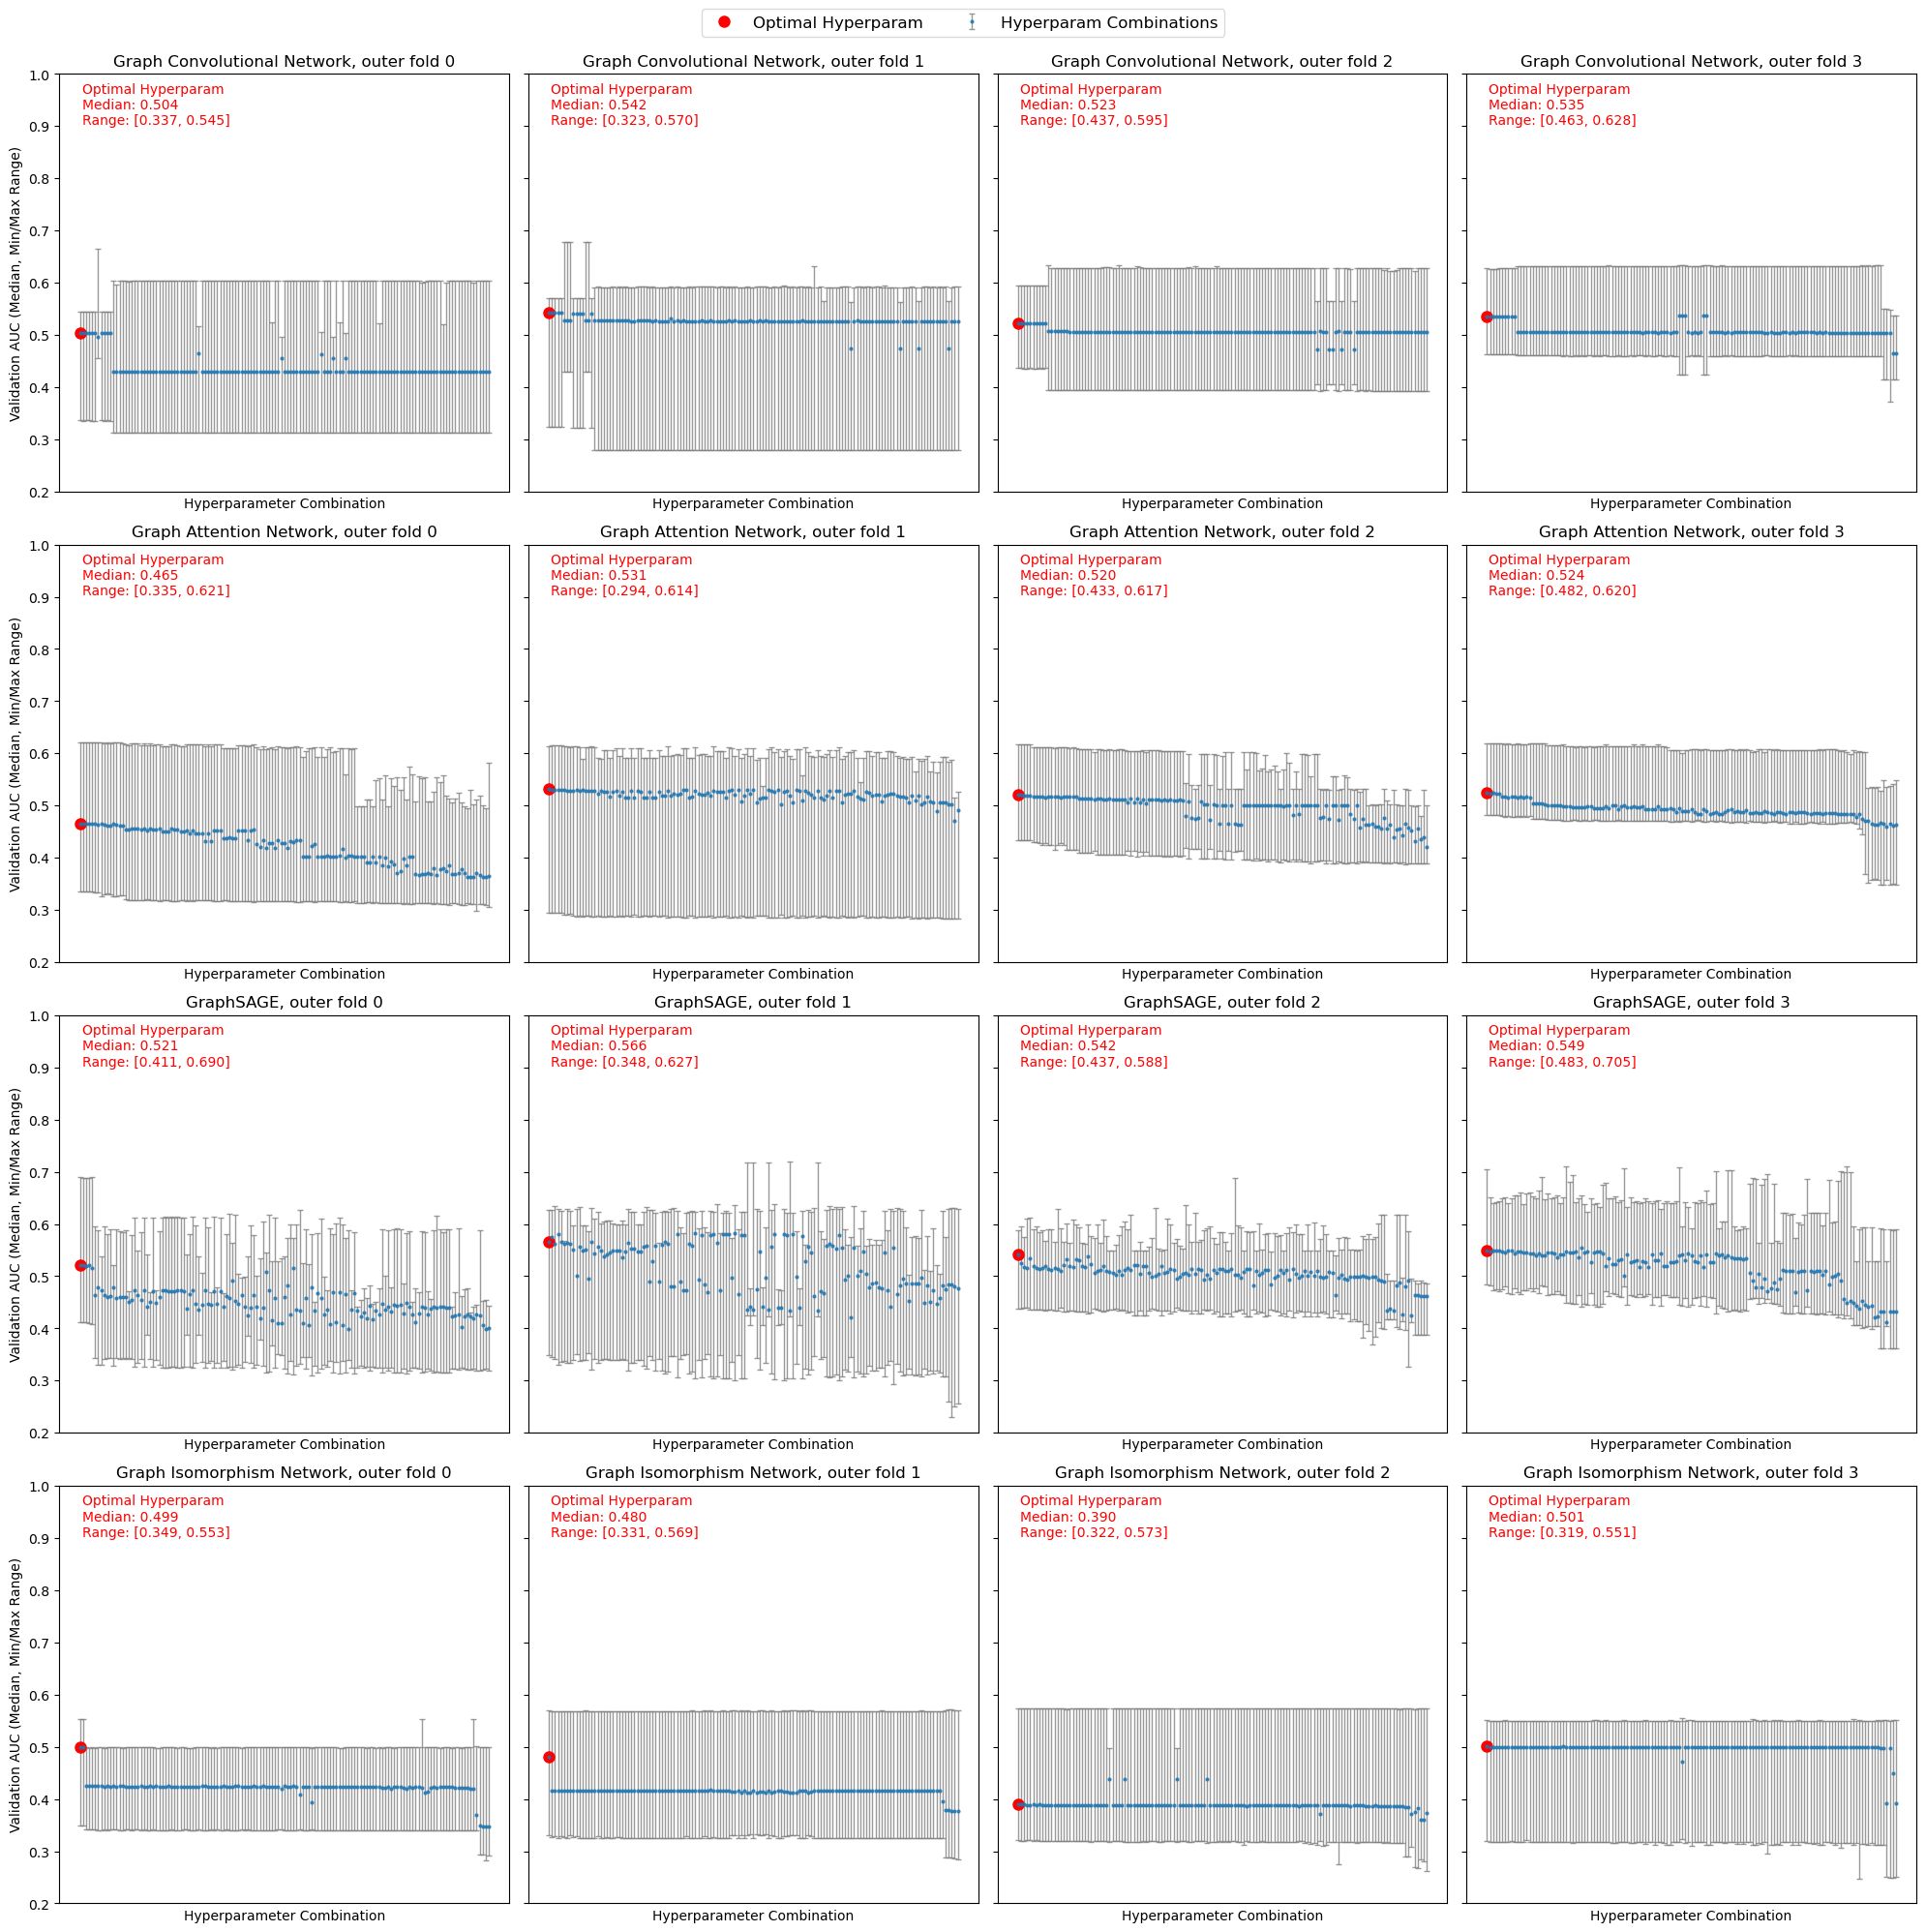

In [9]:
results_dir = 'results/grid_search/clintox2_min'
hyperparam_df = pd.read_csv(os.path.join(results_dir, 'grid_search_results.csv'))
grid_search_hyperparameters_ranking = plot_hyperparameter_performance_ranking(hyperparam_df, save_dir = results_dir,
                                                                             ylim = (0.2, 1), prefix = 'Clintox_min')

For model GCN, mean val_auc of the best seed across 20 inner folds: 0.503 ± 0.090
For model GAT, mean val_auc of the best seed across 20 inner folds: 0.507 ± 0.089
For model GraphSAGE, mean val_auc of the best seed across 20 inner folds: 0.557 ± 0.080
For model GIN, mean val_auc of the best seed across 20 inner folds: 0.443 ± 0.074


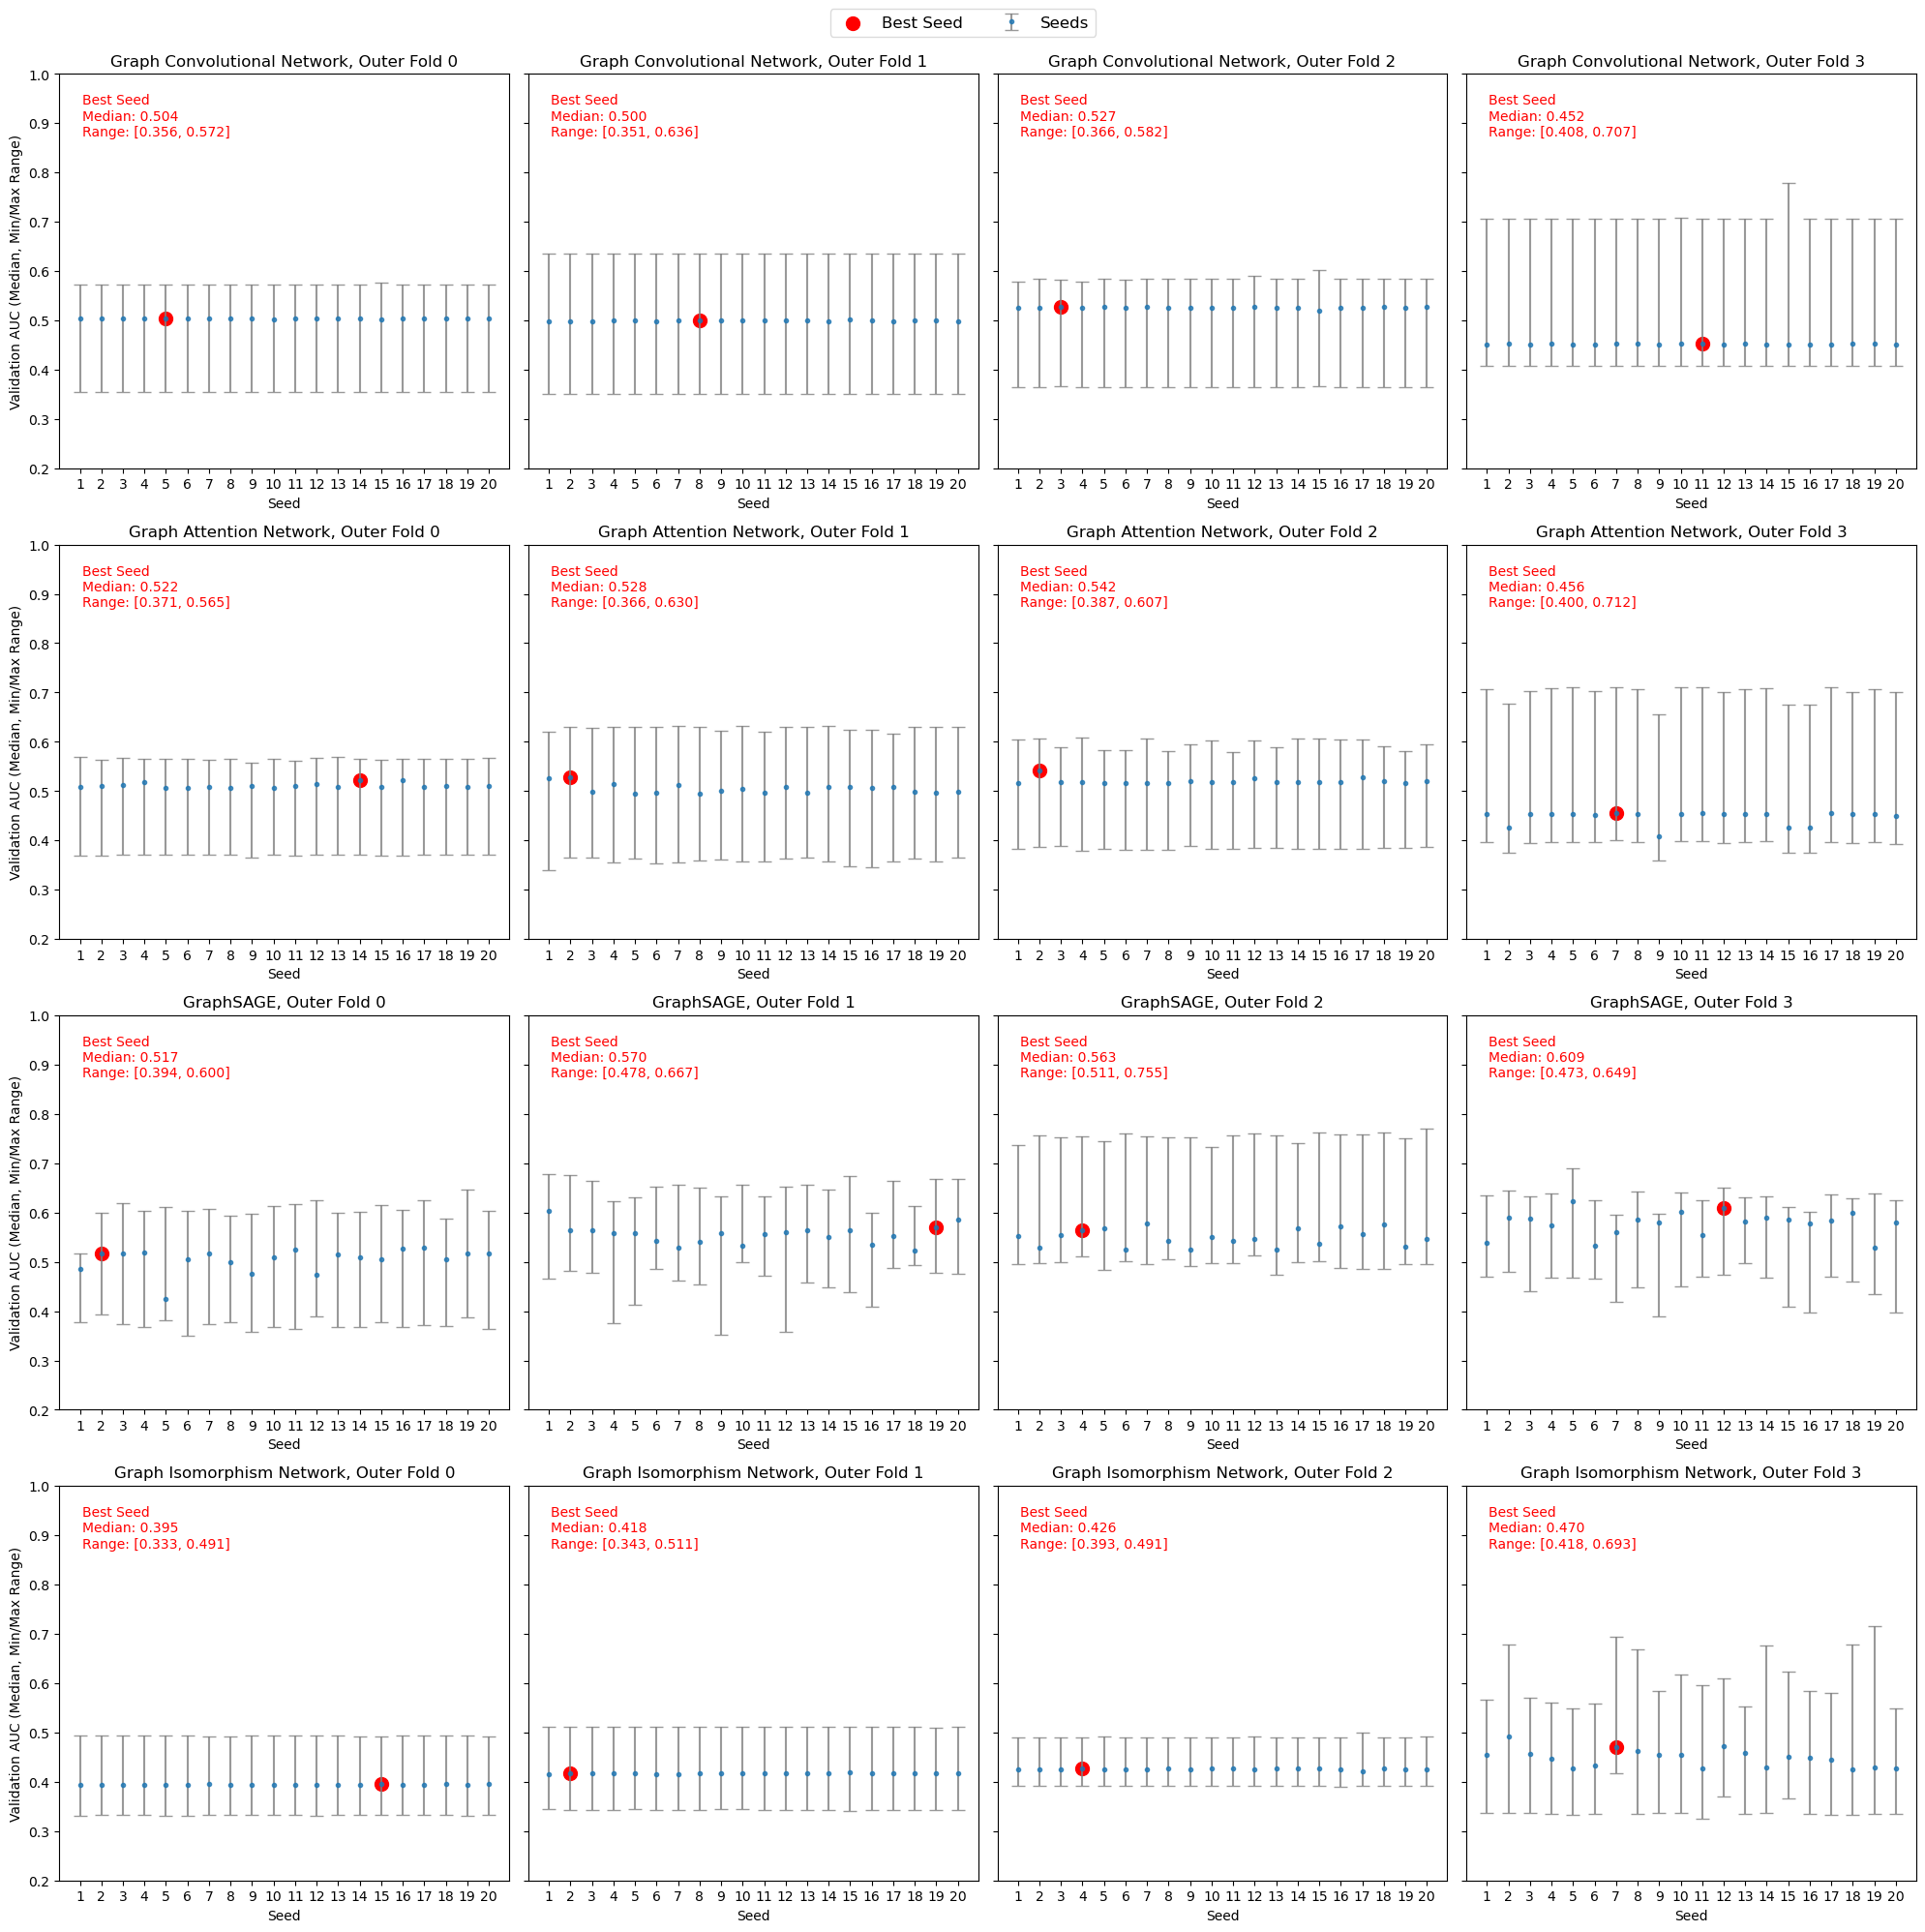

In [10]:
save_dir="results/grid_search/clintox2_min/initial_model_p20_20"
with open(os.path.join(save_dir, 'results_init.pkl'), 'rb') as f:
    results_init = pickle.load(f)
    
best_model_paths = select_best_models(results_init, save_dir)
plot_seed_performance(results_init, best_model_paths, save_dir = save_dir, ylim = (0.2, 1.0), prefix = 'Clintox_min')

{'GCN_Optimised': 1, 'GAT_Optimised': 1, 'GraphSAGE_Optimised': 2, 'GIN_Optimised': 1} 

For model GCN, mean val_auc of the last significant run across 20 inner folds: 0.503 ± 0.091
For model GAT, mean val_auc of the last significant run across 20 inner folds: 0.488 ± 0.094
For model GraphSAGE, mean val_auc of the last significant run across 20 inner folds: 0.659 ± 0.115
For model GIN, mean val_auc of the last significant run across 20 inner folds: 0.454 ± 0.074


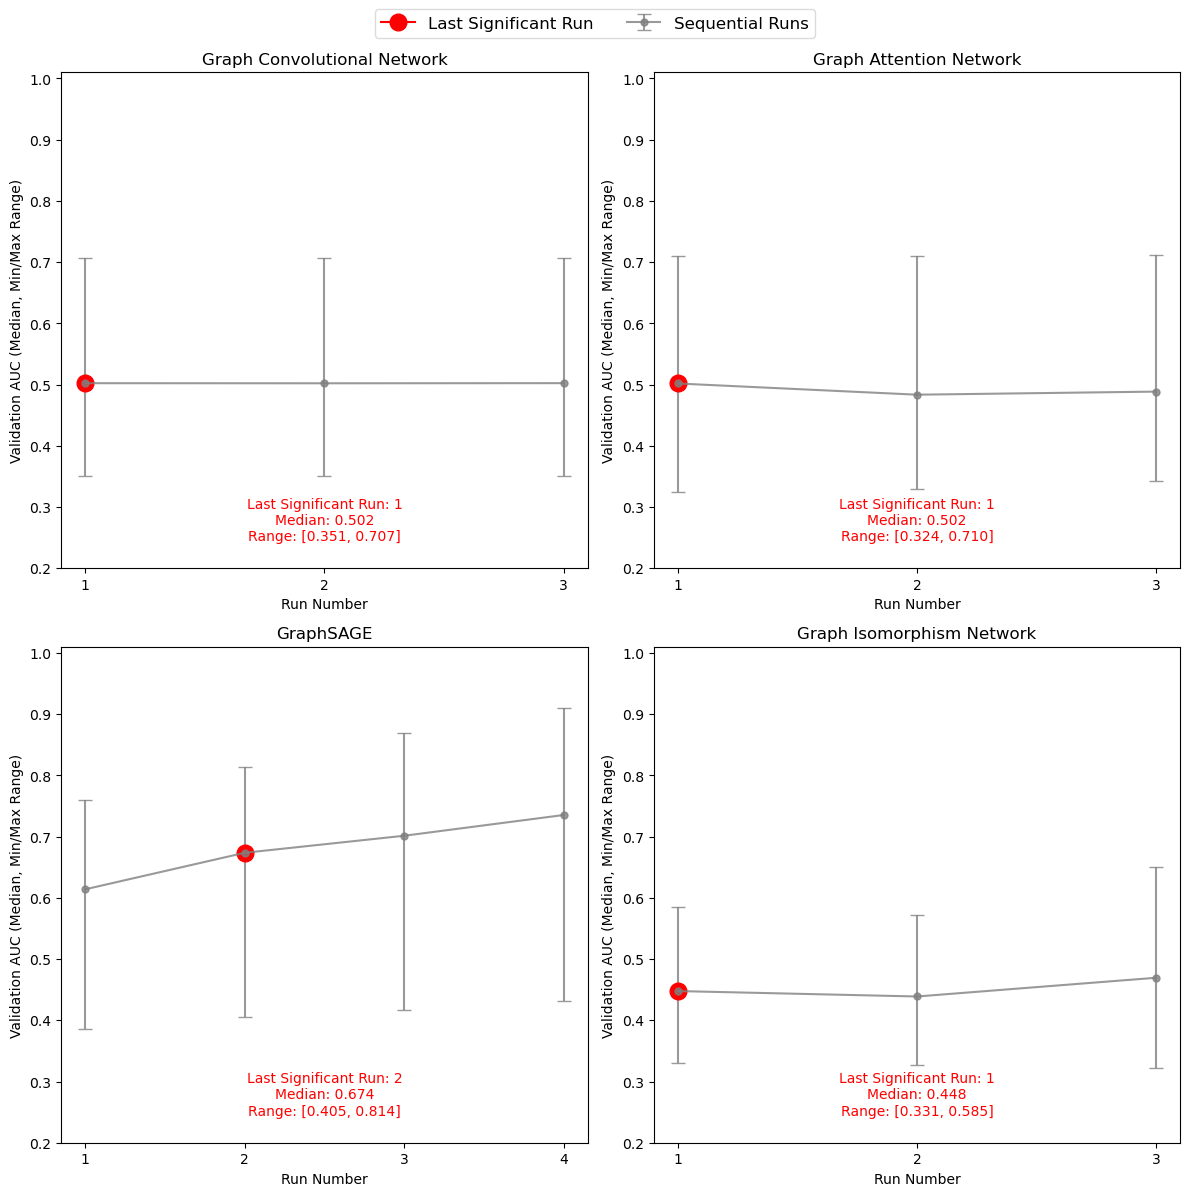

In [11]:
save_dir_ws = os.path.join(save_dir, 'warm_starts_p50')
with open(os.path.join(save_dir_ws, 'last_significant_run.pkl'), 'rb') as f:
   last_significant_run = pickle.load(f)
with open(os.path.join(save_dir_ws, 'results.pkl'), 'rb') as f:
    results = pickle.load(f)
print(last_significant_run,'\n')
plot_median_val_auc_with_error_bars(results, last_significant_run, save_dir = save_dir_ws, 
                                    ylim = (0.2, 1.01), prefix = 'Clintox_min')

In [12]:
models = {
    'GCN_Optimised': GNNModel,
    'GAT_Optimised': GNNModel,
    'GraphSAGE_Optimised': GNNModel,
    'GIN_Optimised': GINModel
}

loaded_models = load_best_models(
    models=models,
    best_model_paths=best_model_paths,
    all_optimised_hyperparameters=grid_search_hyperparameters_ranking,
    pytorch_custom_dataset=clintox_min # for num_features, num_labels
)

save_dir_ws = os.path.join(save_dir, 'warm_starts_p50')

# Test it on the corresponding outer fold test sets
final_test_results = test_final_models_on_outer_cv(
    loaded_models=loaded_models, 
    all_optimised_hyperparameters=grid_search_hyperparameters_ranking, 
    pytorch_custom_dataset=clintox_min,
    last_significant_run=last_significant_run,
    save_dir=save_dir_ws
)


Testing final GCN_Optimised model on outer CV test sets...
  Outer Fold 1/4
    Inner Fold 1/5
Loading model from results/grid_search/clintox2_min/initial_model_p20_20/warm_starts_p50/GCN_Optimised_outer0_inner0_run1.pt
Outer Fold 1, Inner Fold 1: Test AUC: 0.6233, Test Accuracy: 0.9282, Test F1: 0.3209, Test MCC: 0.0000
    Inner Fold 2/5
Loading model from results/grid_search/clintox2_min/initial_model_p20_20/warm_starts_p50/GCN_Optimised_outer0_inner1_run1.pt
Outer Fold 1, Inner Fold 2: Test AUC: 0.6233, Test Accuracy: 0.9282, Test F1: 0.3209, Test MCC: 0.0000
    Inner Fold 3/5
Loading model from results/grid_search/clintox2_min/initial_model_p20_20/warm_starts_p50/GCN_Optimised_outer0_inner2_run1.pt
Outer Fold 1, Inner Fold 3: Test AUC: 0.6233, Test Accuracy: 0.9282, Test F1: 0.3209, Test MCC: 0.0000
    Inner Fold 4/5
Loading model from results/grid_search/clintox2_min/initial_model_p20_20/warm_starts_p50/GCN_Optimised_outer0_inner3_run1.pt
Outer Fold 1, Inner Fold 4: Test AUC: 

##### Custom molecular graph

For model GCN, mean val_auc of optimal hyperparameters across 20 inner folds: 0.636 ± 0.111
For model GAT, mean val_auc of optimal hyperparameters across 20 inner folds: 0.636 ± 0.109
For model GraphSAGE, mean val_auc of optimal hyperparameters across 20 inner folds: 0.634 ± 0.108
For model GIN, mean val_auc of optimal hyperparameters across 20 inner folds: 0.637 ± 0.107


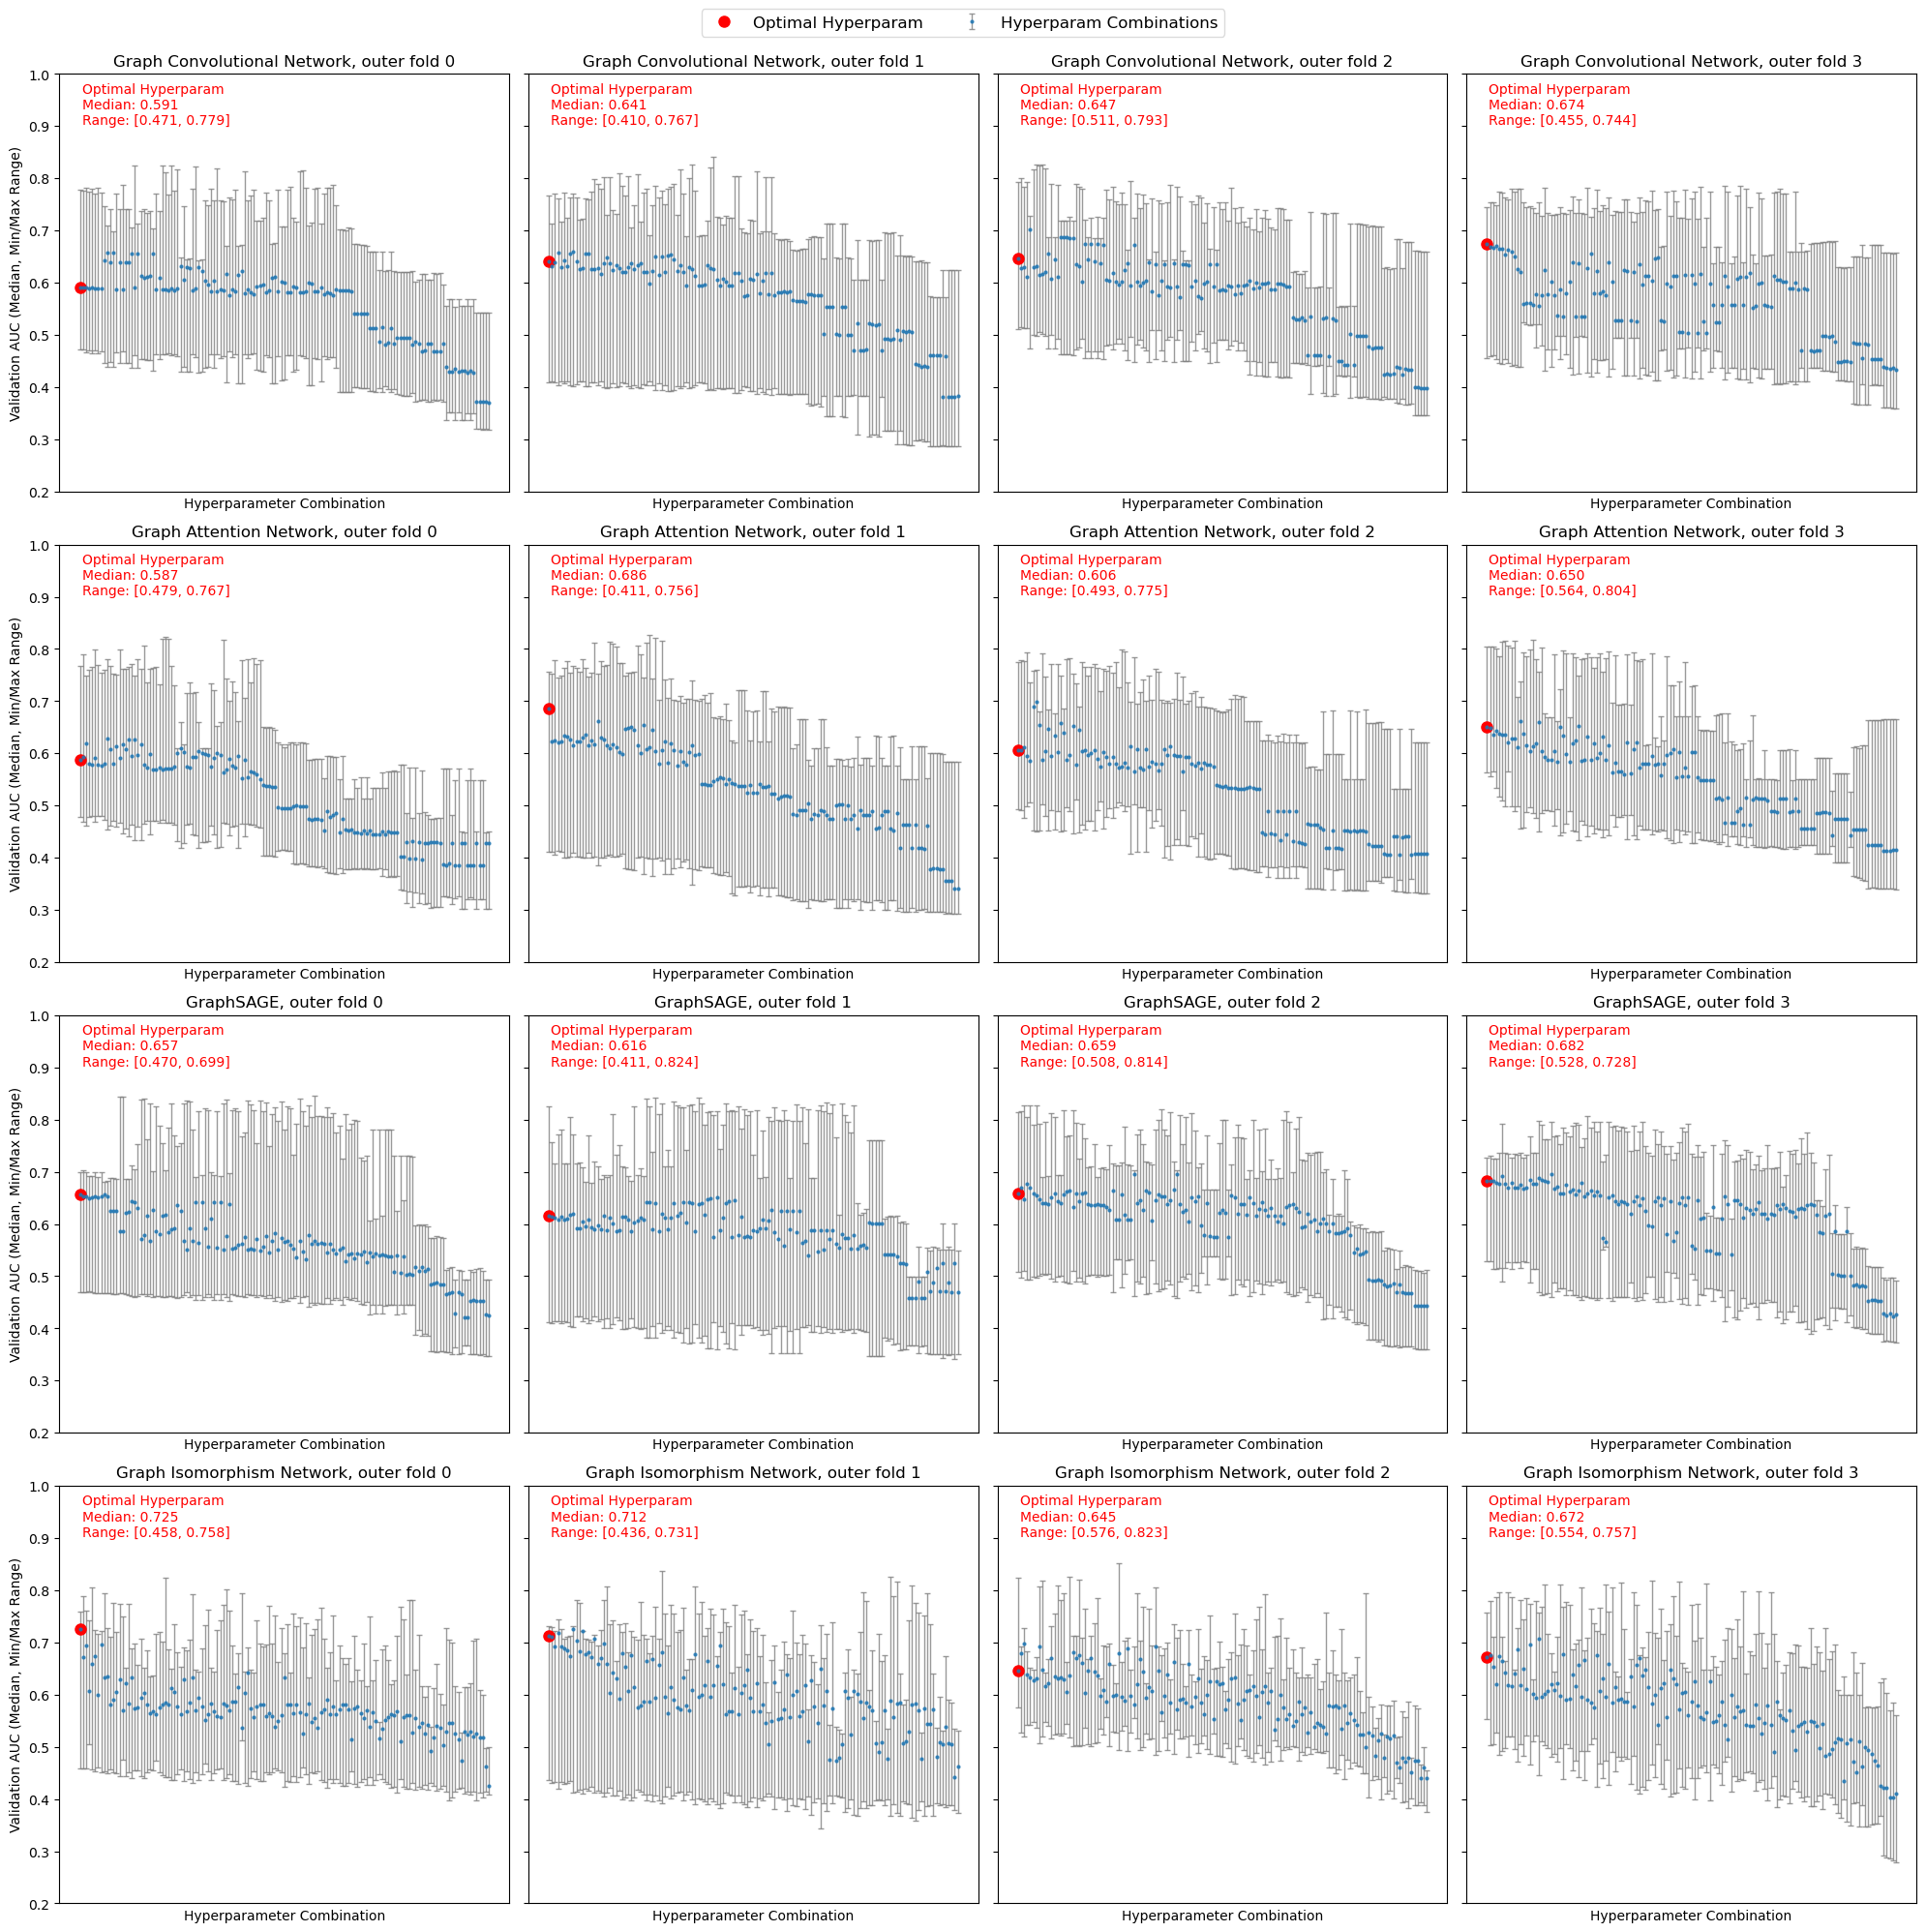

In [13]:
results_dir = 'results/grid_search/clintox2'
hyperparam_df = pd.read_csv(os.path.join(results_dir, 'grid_search_results.csv'))
grid_search_hyperparameters_ranking = plot_hyperparameter_performance_ranking(hyperparam_df, save_dir = results_dir,
                                                                             ylim = (0.2, 1), prefix = 'Clintox')

For model GCN, mean val_auc of the best seed across 20 inner folds: 0.700 ± 0.075
For model GAT, mean val_auc of the best seed across 20 inner folds: 0.760 ± 0.091
For model GraphSAGE, mean val_auc of the best seed across 20 inner folds: 0.745 ± 0.110
For model GIN, mean val_auc of the best seed across 20 inner folds: 0.691 ± 0.056


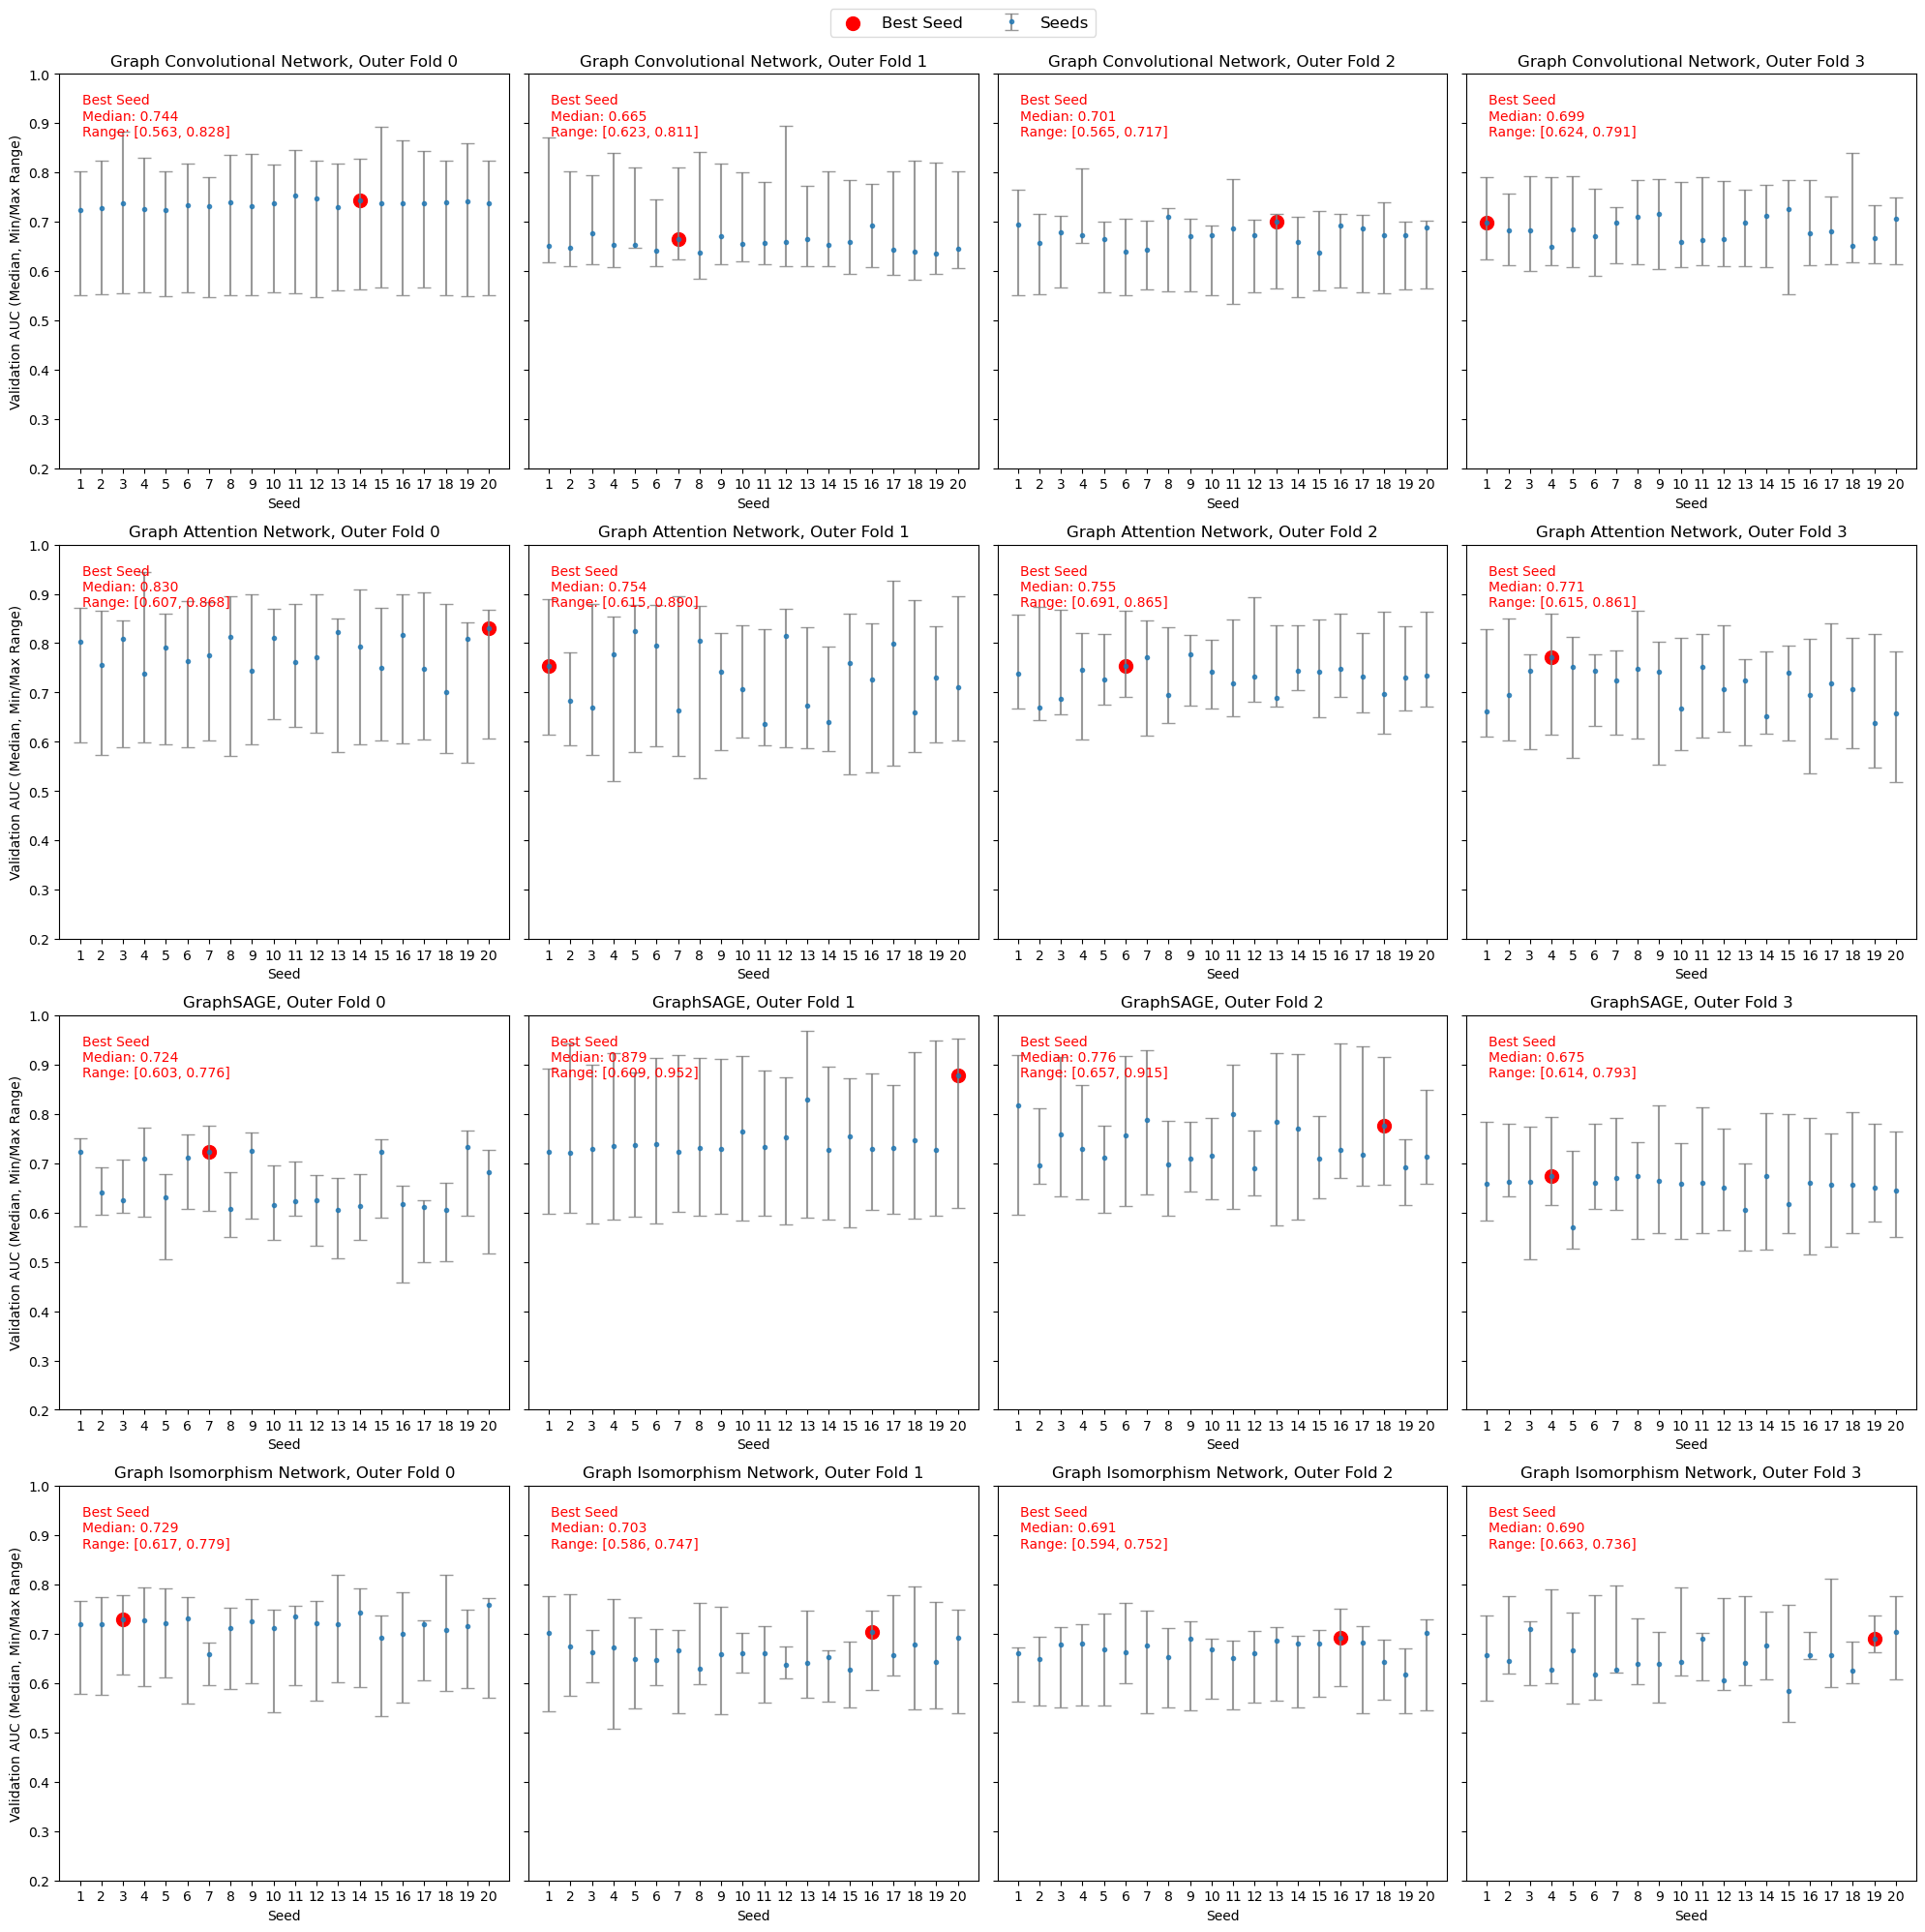

In [14]:
save_dir="results/grid_search/clintox2/initial_model_p20_20"
with open(os.path.join(save_dir, 'results_init.pkl'), 'rb') as f:
    results_init = pickle.load(f)
    
best_model_paths = select_best_models(results_init, save_dir)
plot_seed_performance(results_init, best_model_paths, save_dir = save_dir, ylim = (0.2, 1.0), prefix = 'Clintox')

{'GCN_Optimised': 4, 'GAT_Optimised': 3, 'GraphSAGE_Optimised': 2, 'GIN_Optimised': 4} 

For model GCN, mean val_auc of the last significant run across 20 inner folds: 0.965 ± 0.020
For model GAT, mean val_auc of the last significant run across 20 inner folds: 0.932 ± 0.033
For model GraphSAGE, mean val_auc of the last significant run across 20 inner folds: 0.905 ± 0.065
For model GIN, mean val_auc of the last significant run across 20 inner folds: 0.934 ± 0.049


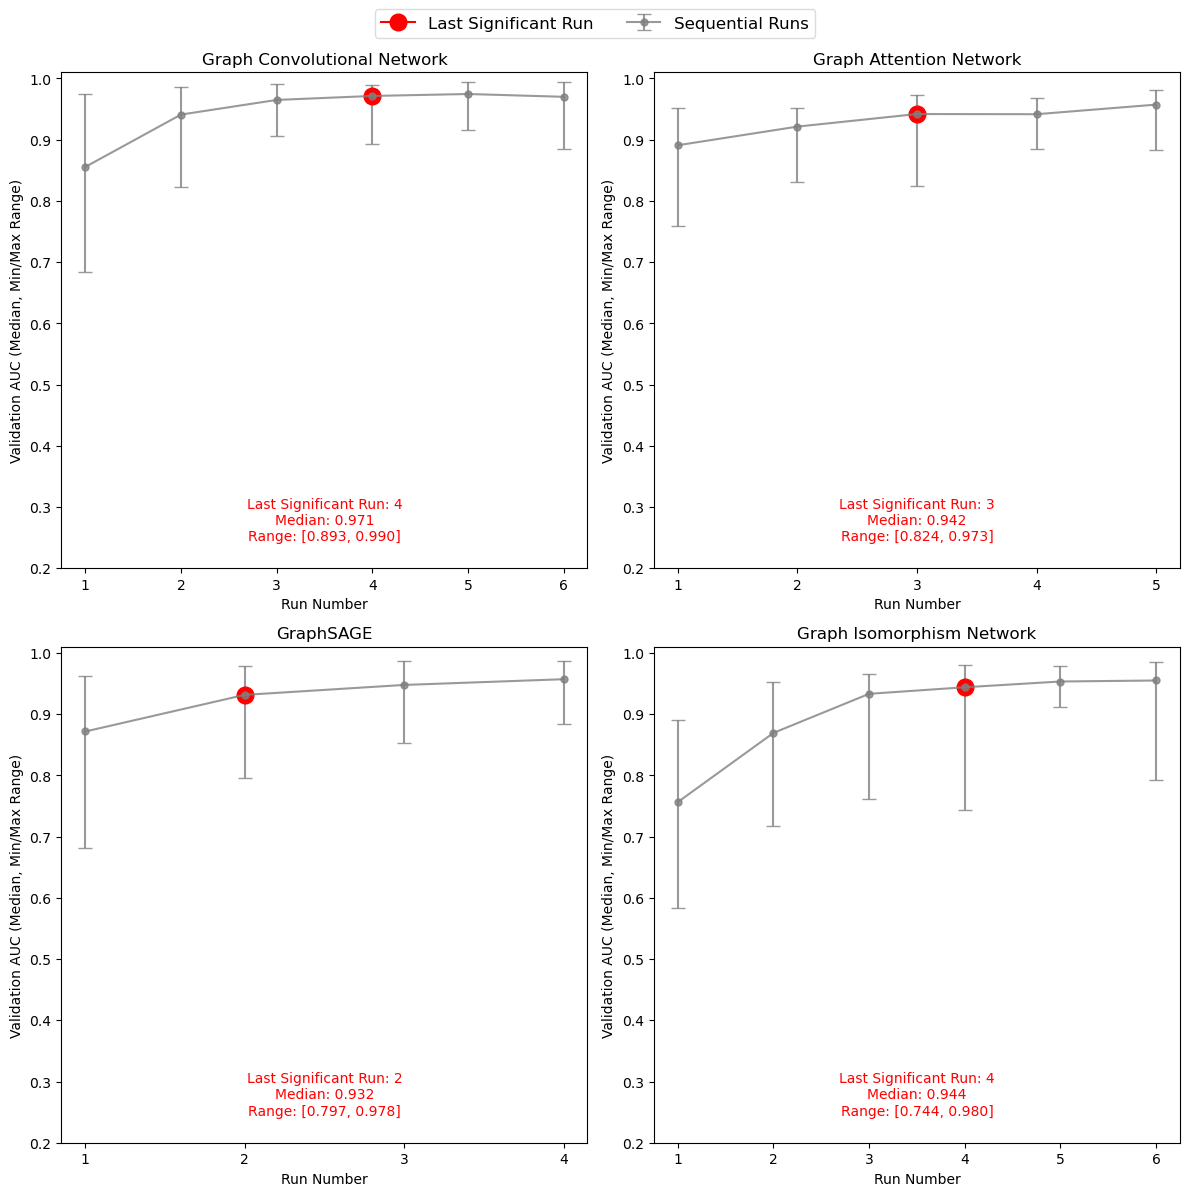

In [15]:
save_dir_ws = os.path.join(save_dir, 'warm_starts_p50')
with open(os.path.join(save_dir_ws, 'last_significant_run.pkl'), 'rb') as f:
   last_significant_run = pickle.load(f)
with open(os.path.join(save_dir_ws, 'results.pkl'), 'rb') as f:
    results = pickle.load(f)
print(last_significant_run,'\n')
plot_median_val_auc_with_error_bars(results, last_significant_run, save_dir = save_dir_ws, 
                                    ylim = (0.2, 1.01), prefix = 'Clintox')

In [16]:
models = {
    'GCN_Optimised': GNNModel,
    'GAT_Optimised': GNNModel,
    'GraphSAGE_Optimised': GNNModel,
    'GIN_Optimised': GINModel
}

loaded_models = load_best_models(
    models=models,
    best_model_paths=best_model_paths,
    all_optimised_hyperparameters=grid_search_hyperparameters_ranking,
    pytorch_custom_dataset=clintox_cus_2_std # for num_features, num_labels
)

save_dir_ws = os.path.join(save_dir, 'warm_starts_p50')

# Test it on the corresponding outer fold test sets
final_test_results = test_final_models_on_outer_cv(
    loaded_models=loaded_models, 
    all_optimised_hyperparameters=grid_search_hyperparameters_ranking, 
    pytorch_custom_dataset=clintox_cus_2_std,
    last_significant_run=last_significant_run,
    save_dir=save_dir_ws
)


Testing final GCN_Optimised model on outer CV test sets...
  Outer Fold 1/4
    Inner Fold 1/5
Loading model from results/grid_search/clintox2/initial_model_p20_20/warm_starts_p50/GCN_Optimised_outer0_inner0_run4.pt
Outer Fold 1, Inner Fold 1: Test AUC: 0.9318, Test Accuracy: 0.9475, Test F1: 0.8283, Test MCC: 0.5760
    Inner Fold 2/5
Loading model from results/grid_search/clintox2/initial_model_p20_20/warm_starts_p50/GCN_Optimised_outer0_inner1_run4.pt
Outer Fold 1, Inner Fold 2: Test AUC: 0.9288, Test Accuracy: 0.9503, Test F1: 0.8147, Test MCC: 0.5693
    Inner Fold 3/5
Loading model from results/grid_search/clintox2/initial_model_p20_20/warm_starts_p50/GCN_Optimised_outer0_inner2_run4.pt
Outer Fold 1, Inner Fold 3: Test AUC: 0.9231, Test Accuracy: 0.9392, Test F1: 0.7489, Test MCC: 0.4921
    Inner Fold 4/5
Loading model from results/grid_search/clintox2/initial_model_p20_20/warm_starts_p50/GCN_Optimised_outer0_inner3_run4.pt
Outer Fold 1, Inner Fold 4: Test AUC: 0.9264, Test Acc